In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 

In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 6.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.9/423.9 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3



# 1. PROBLEM STATEMENT: PREDICTING THE HOSPITAL READMISSION FOR DIABETICS.

In [2]:
# Unplanned readmissions can result in increased healthcare costs, 
# reduced patient quality of life, and increased burden on healthcare resources. 
# Predicting which diabetic patients are at a higher risk of readmission can enable 
# healthcare providers to intervene with targeted interventions and preventive measures..

# 2.Data Preperation

In [3]:
df=pd.read_csv('diabetic_data.csv')
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

In [4]:
df.shape

(101766, 50)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [6]:
df['admission_type_id'].value_counts()

1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64

In [7]:
admission_type_mapping = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    5: 'Not Available',
    6: 'NULL',
    7: 'Trauma Center',
    8: 'Not Mapped'
}

In [8]:
df['admission_type_id'] = df['admission_type_id'].replace(admission_type_mapping)

In [9]:
df['admission_type_id'].value_counts()

Emergency        53990
Elective         18869
Urgent           18480
NULL              5291
Not Available     4785
Not Mapped         320
Trauma Center       21
Newborn             10
Name: admission_type_id, dtype: int64

In [10]:
df1 = df[(~df['admission_type_id'].isin(['NULL','Not Available','Not Mapped'])) 
         & (~df['discharge_disposition_id'].isin([11,13,14,19,18,20,21,25,26]))]

In [11]:
df1['admission_type_id'].value_counts()

Emergency        50217
Elective         17689
Urgent           17564
Trauma Center       18
Newborn             10
Name: admission_type_id, dtype: int64

In [12]:


df1['discharge_disposition_id'].value_counts()

1     55137
3     12063
6     11384
22     1941
2      1864
5      1040
4       802
7       559
23      375
28      101
8        94
15       63
24       48
9        16
27        5
17        3
12        3
Name: discharge_disposition_id, dtype: int64

In [13]:
disposition_mapping = {
    1: 'Discharged to home',
    2: 'transferred to another short-term hospital',
    3: 'transferred to SNF',
    4: 'transferred to ICF',
    5: 'transferred to another type of inpatient care institution',
    6: 'transferred to home with home health service',
    7: 'Left AMA',
    8: 'transferred to home under care of Home IV provider',
    9: 'Admitted as an inpatient to this hospital',
    10: 'discharged to another hospital for neonatal aftercare',
    
    12: 'Still patient or expected to return for outpatient services',
    15: 'transferred within this institution to Medicare approved swing bed',
    16: 'referred another institution for outpatient services',
    17: 'referred to this institution for outpatient services',
    
   
 
    22: 'transferred to another rehab fac including rehab units of a hospital .',
    23: 'transferred to a long term care hospital.',
    24: 'transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
  

    30: 'transferred to another Type of Health Care Institution not Defined Elsewhere',
    27: 'transferred to a federal health care facility.',
    28: 'referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
    29: 'transferred to a Critical Access Hospital (CAH)'
}

In [14]:
df1['discharge_disposition_id'] = df['discharge_disposition_id'].replace(disposition_mapping)

In [15]:
df1['discharge_disposition_id'].value_counts()

Discharged to home                                                                              55137
transferred to SNF                                                                              12063
transferred to home with home health service                                                    11384
transferred to another rehab fac including rehab units of a hospital .                           1941
transferred to another short-term hospital                                                       1864
transferred to another type of inpatient care institution                                        1040
transferred to ICF                                                                                802
Left AMA                                                                                          559
transferred to a long term care hospital.                                                         375
referred to a psychiatric hospital of psychiatric distinct part unit of a hospital

In [16]:
df1['race'].value_counts()

Caucasian          63384
AfricanAmerican    16702
?                   2091
Hispanic            1520
Other               1253
Asian                548
Name: race, dtype: int64

In [17]:
df1['race']=df1['race'].replace({'?':'Americans'})

In [18]:
df1['medical_specialty']=df1['medical_specialty'].replace({'?':'Others'})

# 3. Data Pre-Processing

In [19]:
df1['age'].value_counts()

[70-80)     21431
[60-70)     19113
[50-60)     14721
[80-90)     14250
[40-50)      8206
[30-40)      3262
[90-100)     2256
[20-30)      1474
[10-20)       639
[0-10)        146
Name: age, dtype: int64

In [20]:
df1['readmitted']=df1['readmitted'].replace({'>30':1,'<30':1,'NO':0})

In [21]:
df1['admission_type_id']=df1['admission_type_id'].astype('object')
df1['discharge_disposition_id']=df1['discharge_disposition_id'].astype('object')
df1['age']=df1['age'].astype('object')

In [22]:
# dropping few columns which does not help in model building and irreleavant to the problem statement.

In [23]:
df1.drop(columns=['admission_source_id','payer_code','weight','encounter_id','patient_nbr','examide',
                  'citoglipton'],axis=1,inplace=True)

In [24]:
df1.isnull().sum()

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide

In [25]:
df1['readmitted']=df1['readmitted'].astype('int64')

In [26]:
df1.shape

(85498, 43)

# 4. Feature Engineering

In [27]:
df1[df1=='?'].count()

race                           0
gender                         0
age                            0
admission_type_id              0
discharge_disposition_id       0
time_in_hospital               0
medical_specialty              0
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
diag_1                        18
diag_2                       331
diag_3                      1209
number_diagnoses               0
max_glu_serum                  0
A1Cresult                      0
metformin                      0
repaglinide                    0
nateglinide                    0
chlorpropamide                 0
glimepiride                    0
acetohexamide                  0
glipizide                      0
glyburide                      0
tolbutamide                    0
pioglitazone                   0
rosiglitazone                  0
acarbose  

In [28]:
diag_list= ['diag_1','diag_2','diag_3'] 

In [29]:
df1['diag_1']=df1['diag_1'].replace({'?':np.nan})
df1['diag_2']=df1['diag_2'].replace({'?':np.nan})
df1['diag_3']=df1['diag_3'].replace({'?':np.nan})

In [30]:
for i in diag_list:
    df1[i].fillna('NaN', inplace=True)

In [31]:
import re
def transformFunc(value):
    value = re.sub("V[0-9]*", "0", value) # V 
    value = re.sub("E[0-9]*", "0", value) # E 
    value = re.sub('NaN', "-1", value) # Nan 
    return value

def transformCategory(value):
    if value>=390 and value<=459 or value==785:
        category = 'Circulatory'
    elif value>=460 and value<=519 or value==786:
        category = 'Respiratory'
    elif value>=520 and value<=579 or value==787:
        category = 'Digestive'
    elif value==250:
        category = 'Diabetes'
    elif value>=800 and value<=999:
        category = 'Injury'          
    elif value>=710 and value<=739:
        category = 'Musculoskeletal'   
    elif value>=580 and value<=629 or value==788:
        category = 'Genitourinary'
    elif value>=140 and value<=239 :
        category = 'Neoplasms'
    elif value==-1:
        category = 'NAN'
    else :
        category = 'External Causes'

    return category

In [32]:
for col in diag_list:
    df1[col] = df1[col].apply(transformFunc)
    df1[col] = df1[col].astype(float)

In [33]:
for col in diag_list:
    df1[col] = df1[col].apply(transformCategory)

In [34]:
df1['diag_3'].value_counts()

External Causes    29478
Circulatory        25417
Diabetes            9689
Respiratory         6032
Genitourinary       5616
Digestive           3286
Injury              1657
Musculoskeletal     1638
Neoplasms           1476
NAN                 1209
Name: diag_3, dtype: int64

In [35]:
df1['diag_2'].value_counts()

External Causes    28309
Circulatory        26586
Respiratory         8921
Genitourinary       7187
Diabetes            5036
Digestive           3503
Injury              2079
Neoplasms           2035
Musculoskeletal     1511
NAN                  331
Name: diag_2, dtype: int64

In [36]:
df1['diag_1'].value_counts()

Circulatory        25464
External Causes    22694
Respiratory        11896
Digestive           8009
Injury              5985
Genitourinary       4388
Musculoskeletal     4109
Neoplasms           2714
Diabetes             221
NAN                   18
Name: diag_1, dtype: int64

In [37]:
df1=df1[(~df1['diag_1'].isin(['NAN'])) & (~df1['diag_2'].isin(['NAN'])) & (~df1['diag_3'].isin(['NAN']))]

In [38]:
df1.shape

(84192, 43)

In [39]:
df1['admission_type_id'].value_counts()

Emergency        49485
Elective         17383
Urgent           17296
Trauma Center       18
Newborn             10
Name: admission_type_id, dtype: int64

In [40]:
df1.head()

race  gender      age admission_type_id  \
1        Caucasian  Female  [10-20)         Emergency   
2  AfricanAmerican  Female  [20-30)         Emergency   
3        Caucasian    Male  [30-40)         Emergency   
4        Caucasian    Male  [40-50)         Emergency   
5        Caucasian    Male  [50-60)            Urgent   

  discharge_disposition_id  time_in_hospital medical_specialty  \
1       Discharged to home                 3            Others   
2       Discharged to home                 2            Others   
3       Discharged to home                 2            Others   
4       Discharged to home                 1            Others   
5       Discharged to home                 3            Others   

   num_lab_procedures  num_procedures  num_medications  ...  tolazamide  \
1                  59               0               18  ...          No   
2                  11               5               13  ...          No   
3                  44               1               16  ...          No   
4                  51               0                8  ...          No   
5                  31               6               16  ...          No   

   insulin  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
1       Up                   No                  No                       No   
2       No                   No                  No                       No   
3       Up                   No                  No                       No   
4   Steady                   No                  No                       No   
5   Steady                   No                  No                       No   

  metformin-rosiglitazone  metformin-pioglitazone change diabetesMed  \
1                      No                      No     Ch         Yes   
2                      No                      No     No         Yes   
3                      No                      No     Ch         Yes   
4                      No                      No     Ch         Yes   
5                      No                      No     No         Yes   

  readmitted  
1          1  
2          0  
3          0  
4          0  
5          1  

[5 rows x 43 columns]

In [52]:
num=df1.select_dtypes(include=np.number)
num

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1                      3                  59               0               18   
2                      2                  11               5               13   
3                      2                  44               1               16   
4                      1                  51               0                8   
5                      3                  31               6               16   
...                  ...                 ...             ...              ...   
101761                 3                  51               0               16   
101762                 5                  33               3               18   
101763                 1                  53               0                9   
101764                10                  45               2               21   
101765                 6                  13               3                3   

        number_outpatient  number_emergency  number_inpatient  \
1                       0                 0                 0   
2                       2                 0                 1   
3                       0                 0                 0   
4                       0                 0                 0   
5                       0                 0                 0   
...                   ...               ...               ...   
101761                  0                 0                 0   
101762                  0                 0                 1   
101763                  1                 0                 0   
101764                  0                 0                 1   
101765                  0                 0                 0   

        number_diagnoses  readmitted  
1                      9           1  
2                      6           0  
3                      7           0  
4                      5           0  
5                      9           1  
...                  ...         ...  
101761                 9           1  
101762                 9           0  
101763                13           0  
101764                 9           0  
101765                 9           0  

[84192 rows x 9 columns]

In [53]:
cat=df1.select_dtypes(include='object')
cat

race  gender      age admission_type_id  \
1             Caucasian  Female  [10-20)         Emergency   
2       AfricanAmerican  Female  [20-30)         Emergency   
3             Caucasian    Male  [30-40)         Emergency   
4             Caucasian    Male  [40-50)         Emergency   
5             Caucasian    Male  [50-60)            Urgent   
...                 ...     ...      ...               ...   
101761  AfricanAmerican    Male  [70-80)         Emergency   
101762  AfricanAmerican  Female  [80-90)         Emergency   
101763        Caucasian    Male  [70-80)         Emergency   
101764        Caucasian  Female  [80-90)            Urgent   
101765        Caucasian    Male  [70-80)         Emergency   

       discharge_disposition_id medical_specialty           diag_1  \
1            Discharged to home            Others  External Causes   
2            Discharged to home            Others  External Causes   
3            Discharged to home            Others  External Causes   
4            Discharged to home            Others        Neoplasms   
5            Discharged to home            Others      Circulatory   
...                         ...               ...              ...   
101761       transferred to SNF            Others  External Causes   
101762       transferred to ICF            Others        Digestive   
101763       Discharged to home            Others  External Causes   
101764       transferred to SNF   Surgery-General           Injury   
101765       Discharged to home            Others        Digestive   

                 diag_2           diag_3 max_glu_serum  ... troglitazone  \
1       External Causes  External Causes          None  ...           No   
2              Diabetes  External Causes          None  ...           No   
3       External Causes      Circulatory          None  ...           No   
4             Neoplasms         Diabetes          None  ...           No   
5           Circulatory         Diabetes          None  ...           No   
...                 ...              ...           ...  ...          ...   
101761  External Causes      Circulatory          None  ...           No   
101762  External Causes        Digestive          None  ...           No   
101763    Genitourinary  External Causes          None  ...           No   
101764  External Causes           Injury          None  ...           No   
101765        Digestive        Digestive          None  ...           No   

       tolazamide insulin glyburide-metformin glipizide-metformin  \
1              No      Up                  No                  No   
2              No      No                  No                  No   
3              No      Up                  No                  No   
4              No  Steady                  No                  No   
5              No  Steady                  No                  No   
...           ...     ...                 ...                 ...   
101761         No    Down                  No                  No   
101762         No  Steady                  No                  No   
101763         No    Down                  No                  No   
101764         No      Up                  No                  No   
101765         No      No                  No                  No   

       glimepiride-pioglitazone metformin-rosiglitazone  \
1                            No                      No   
2                            No                      No   
3                            No                      No   
4                            No                      No   
5                            No                      No   
...                         ...                     ...   
101761                       No                      No   
101762                       No                      No   
101763                       No                      No   
101764                       No                      No   
101765                       No           

# 4. Exploratory Data Analysis

In [43]:
# outlier treatment

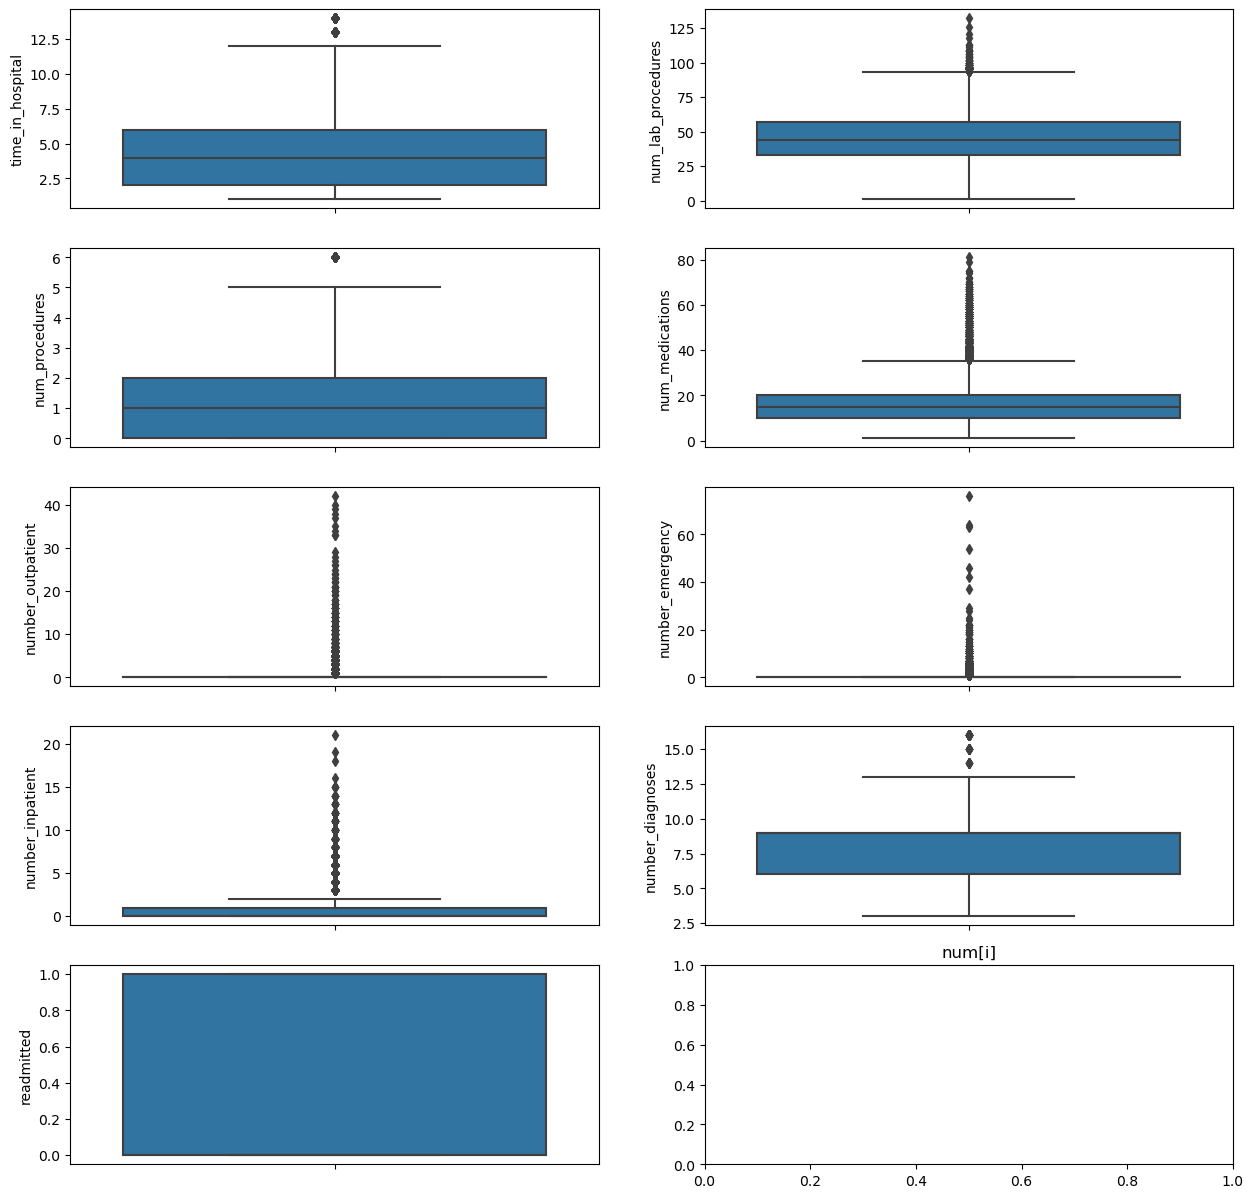

In [44]:
fig,ax=plt.subplots(5,2,figsize=(15,15))
for i,subplot in zip(num,ax.flatten()):
    sns.boxplot(y=num[i],ax=subplot)
    plt.title('num[i]')
plt.show()

In [45]:
# capping outliers with upper and lower limits

In [46]:
for i in num.drop(columns=['number_outpatient','number_emergency'],axis=1).columns:
    q1=num[i].quantile(0.25)
    q3=num[i].quantile(0.75)
    iqr=q3-q1
    uw=q3+1.5*iqr
    lw=q1-1.5*iqr
    num[i]=num[i].apply(lambda x: uw if x>uw else lw if x<lw else x)

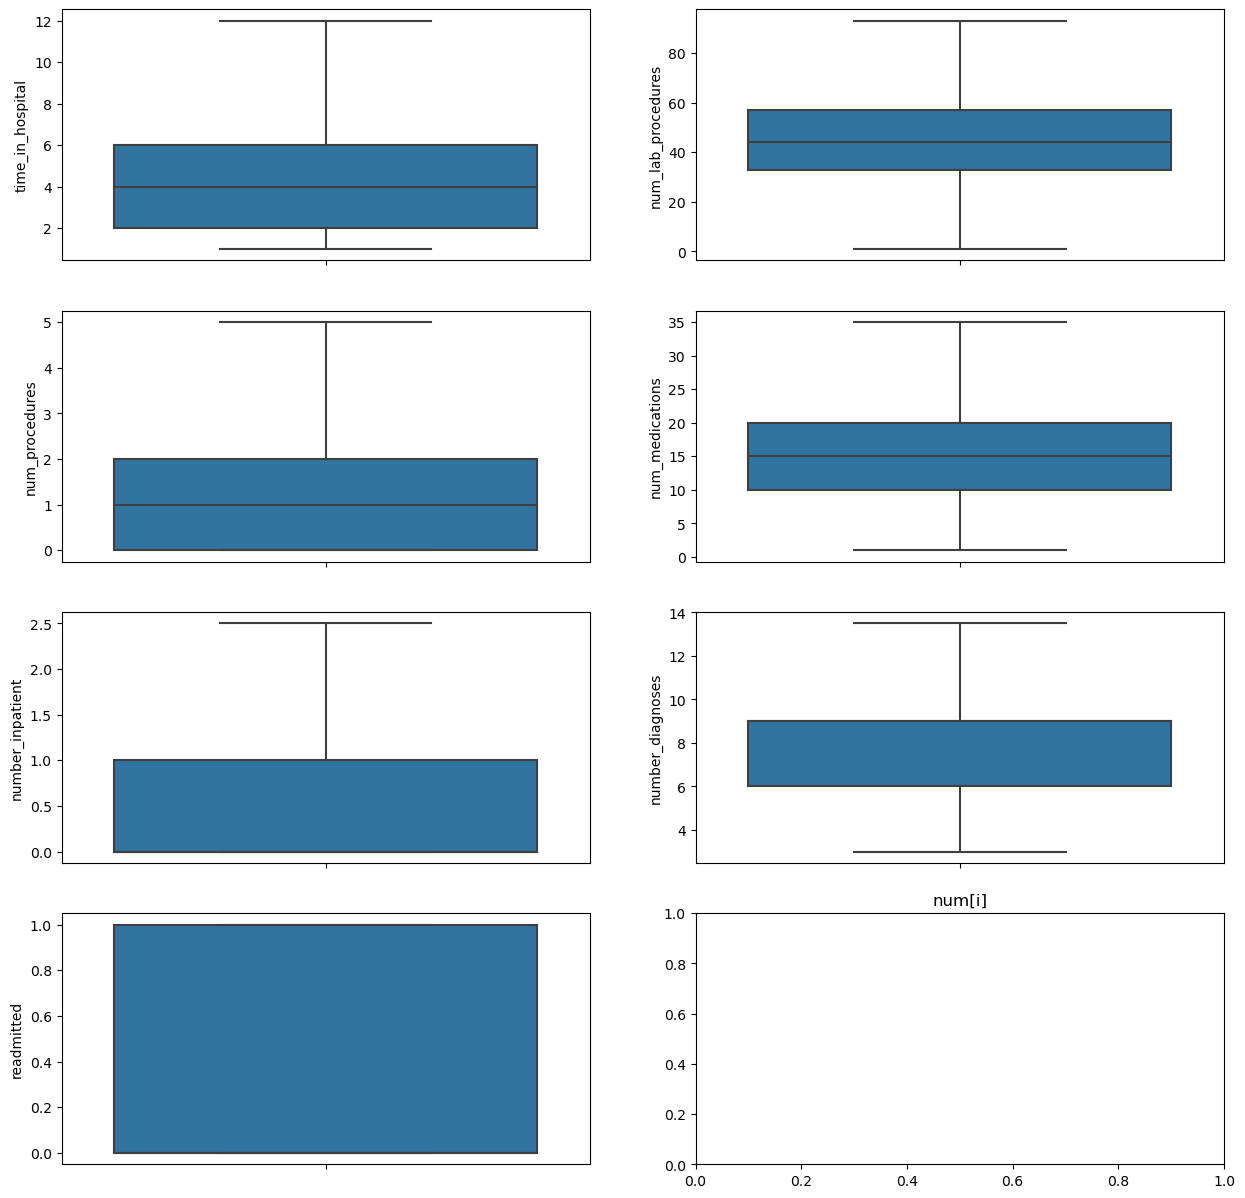

In [47]:
fig,ax=plt.subplots(4,2,figsize=(15,15))
for i,subplot in zip(num.drop(columns=['number_outpatient','number_emergency'],axis=1).columns,ax.flatten()):
    sns.boxplot(y=num[i],ax=subplot)
    plt.title('num[i]')   
    
plt.show()

In [54]:
num.describe()

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count      84192.000000        84192.000000    84192.000000     84192.000000   
mean           4.385274           43.285051        1.337443        16.037023   
std            2.961396           19.406565        1.710203         8.069645   
min            1.000000            1.000000        0.000000         1.000000   
25%            2.000000           33.000000        0.000000        10.000000   
50%            4.000000           44.000000        1.000000        15.000000   
75%            6.000000           57.000000        2.000000        20.000000   
max           14.000000          132.000000        6.000000        81.000000   

       number_outpatient  number_emergency  number_inpatient  \
count       84192.000000      84192.000000      84192.000000   
mean            0.359155          0.208298          0.641427   
std             1.253120          0.982500          1.270488   
min             0.000000          0.000000          0.000000   
25%             0.000000          0.000000          0.000000   
50%             0.000000          0.000000          0.000000   
75%             0.000000          0.000000          1.000000   
max            42.000000         76.000000         21.000000   

       number_diagnoses    readmitted  
count      84192.000000  84192.000000  
mean           7.551276      0.472468  
std            1.833253      0.499244  
min            3.000000      0.000000  
25%            6.000000      0.000000  
50%            9.000000      0.000000  
75%            9.000000      1.000000  
max           16.000000      1.000000

In [55]:
cat.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')

In [56]:
cat.describe()

race  gender      age admission_type_id discharge_disposition_id  \
count       84192   84192    84192             84192                    84192   
unique          6       3       10                 5                       17   
top     Caucasian  Female  [70-80)         Emergency       Discharged to home   
freq        62512   45414    21286             49485                    54016   

       medical_specialty       diag_1           diag_2           diag_3  \
count              84192        84192            84192            84192   
unique                71            9                9                9   
top               Others  Circulatory  External Causes  External Causes   
freq               41138        25358            27899            29446   

       max_glu_serum  ... troglitazone tolazamide insulin glyburide-metformin  \
count          84192  ...        84192      84192   84192               84192   
unique             4  ...            2          2       4                   4   
top             None  ...           No         No      No                  No   
freq           83157  ...        84190      84173   38073               83513   

       glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone  \
count                84192                    84192                   84192   
unique                   2                        2                       2   
top                     No                       No                      No   
freq                 84179                    84191                   84190   

       metformin-pioglitazone change diabetesMed  
count                   84192  84192       84192  
unique                      2      2           2  
top                        No     No         Yes  
freq                    84191  44392       65591  

[4 rows x 34 columns]

In [57]:
# visualizing the distribution of target variable(readmitted) in the data.

In [58]:
readmit_count=df1['readmitted'].value_counts(normalize=True)
readmit_count

0    0.527532
1    0.472468
Name: readmitted, dtype: float64

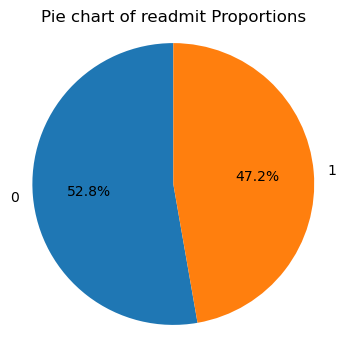

In [59]:
plt.figure(figsize=(4,4))
plt.pie(readmit_count, labels=readmit_count.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie chart of readmit Proportions')
plt.axis('equal')
plt.show()

In [60]:
# Univariate Analysis for numerical

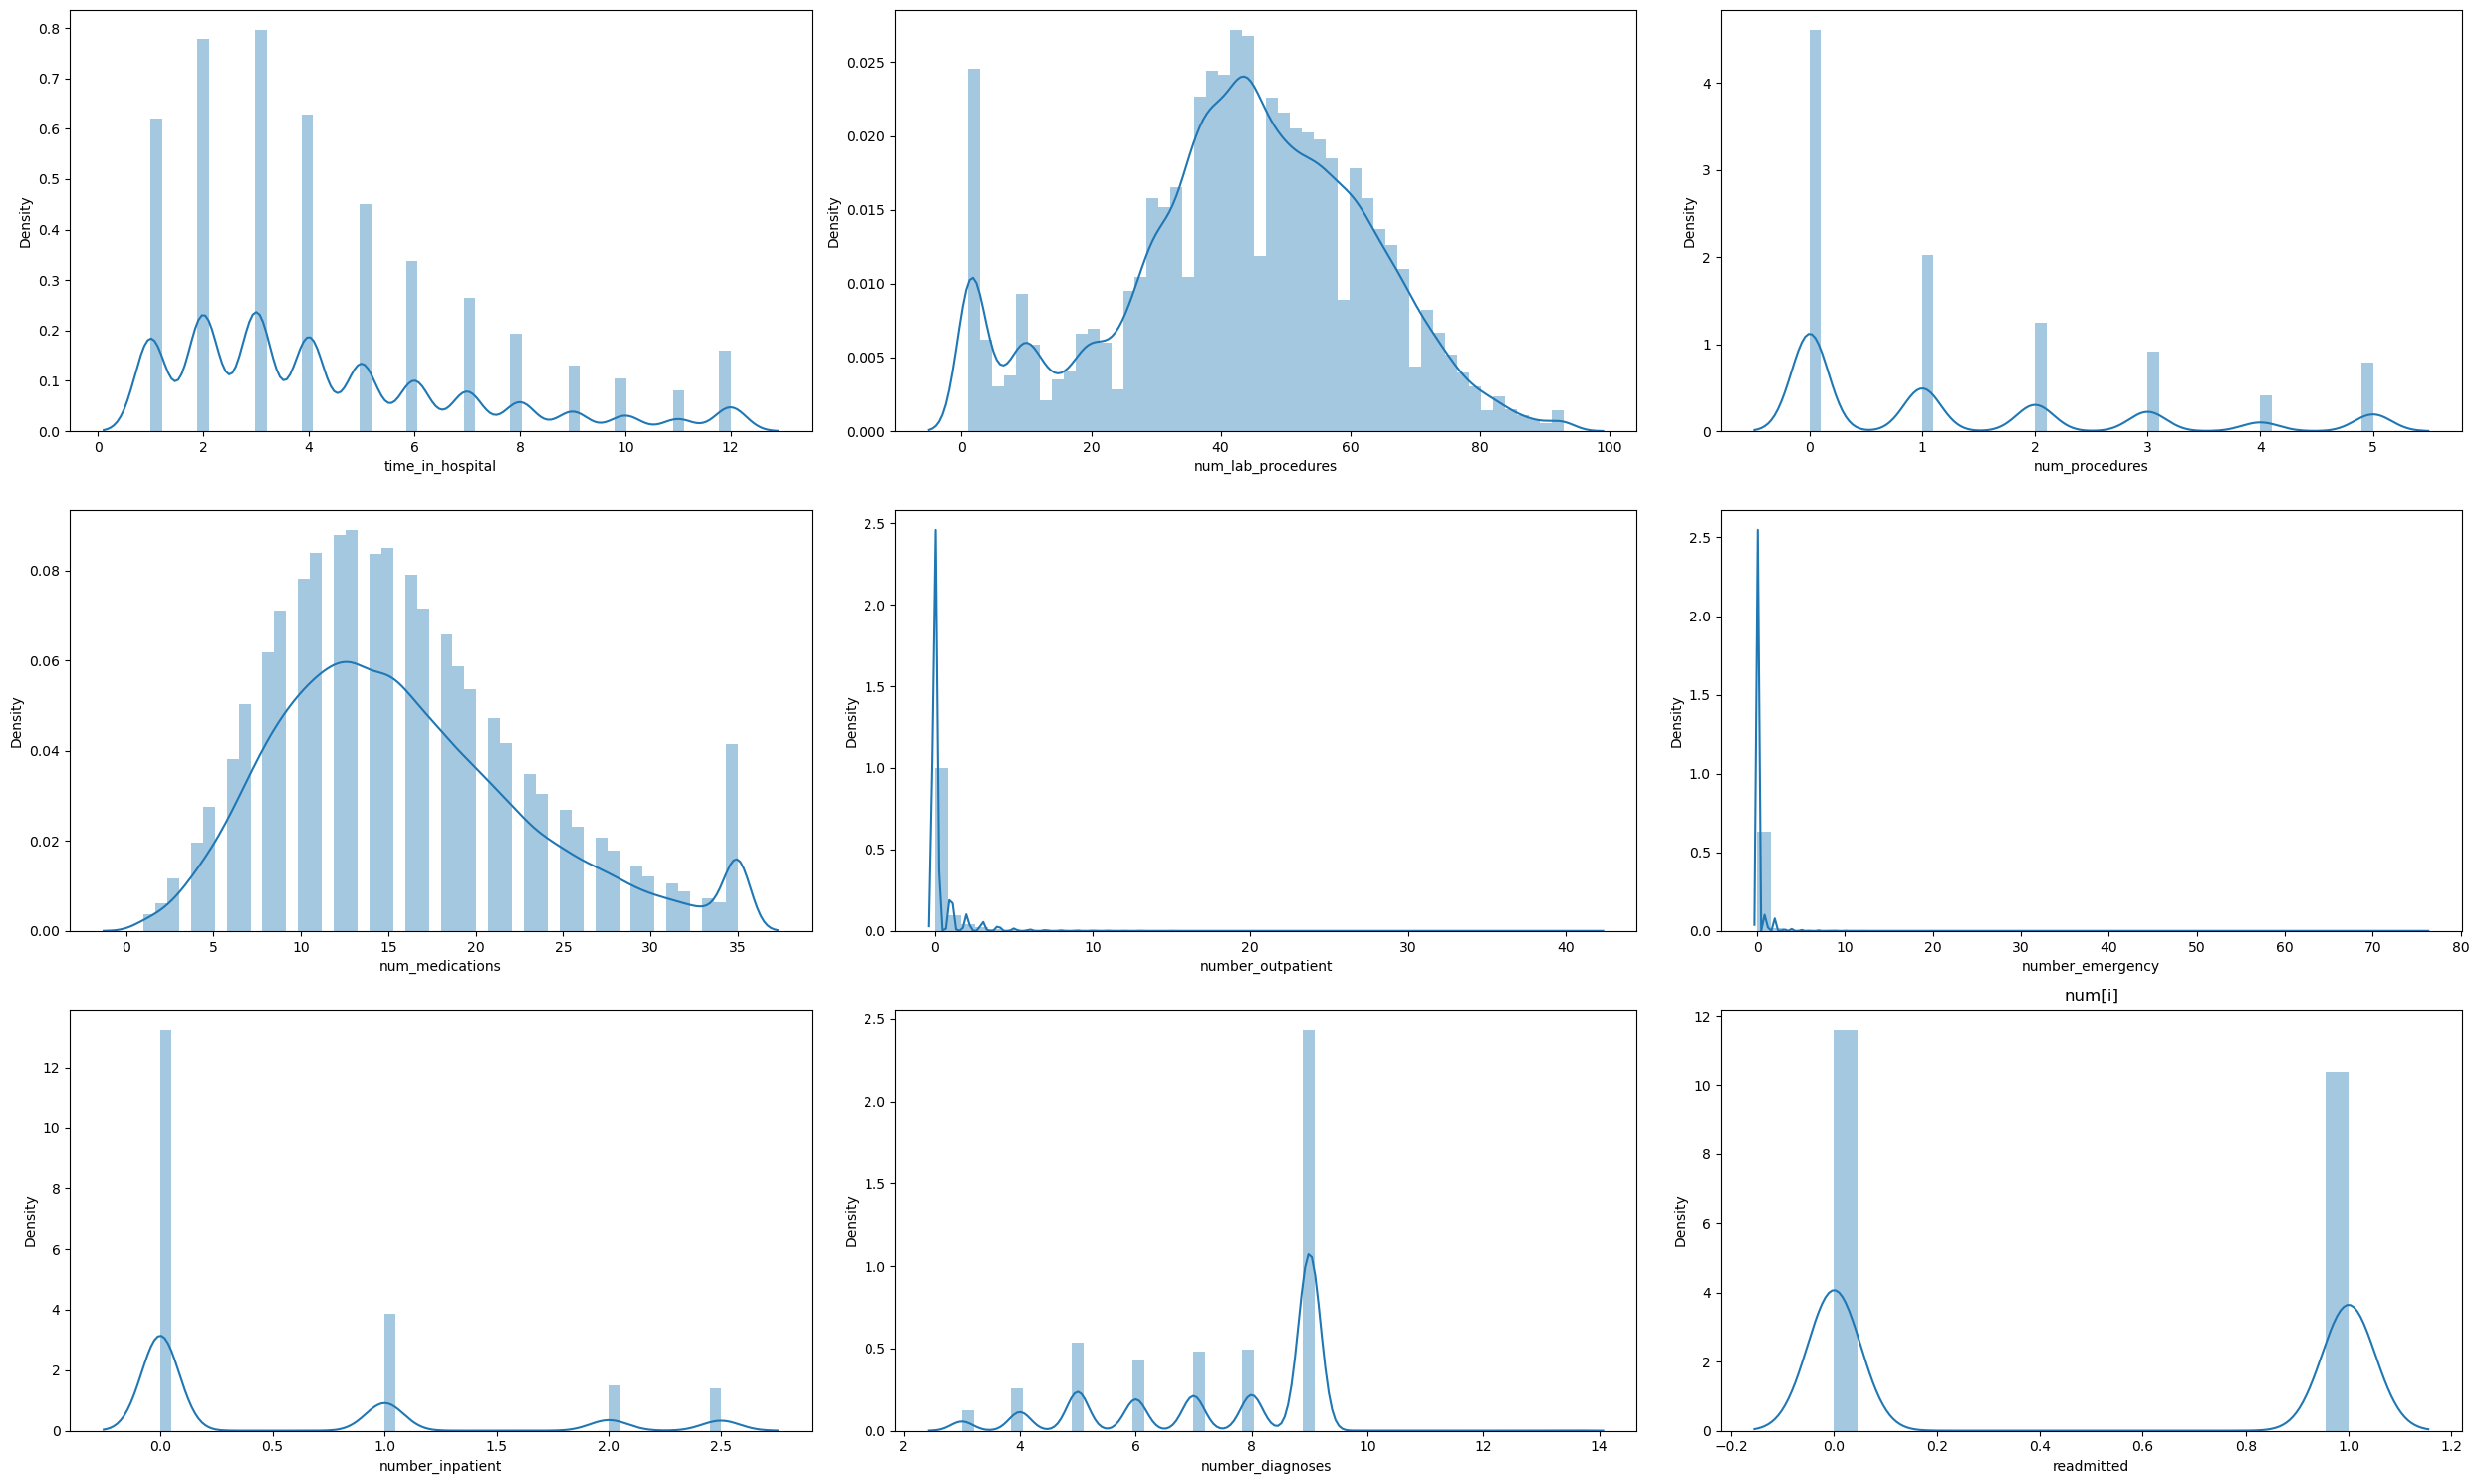

In [55]:
fig, ax= plt.subplots(3,3, figsize=(25,15))

for i, subplot in (zip(num.columns, ax.flatten())):
    sns.distplot(num[i], ax=subplot)
    plt.title('num[i]')

plt.tight_layout()
plt.show()

time_in_hospital


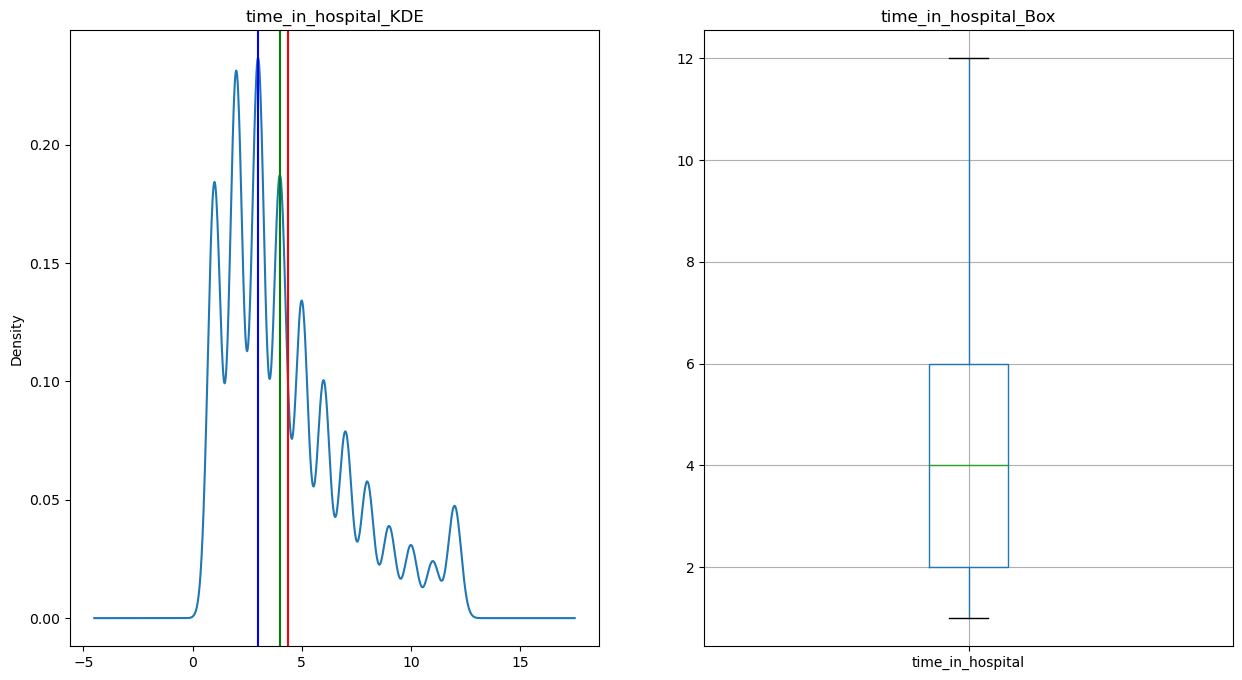

skewtime_in_hospital 1.0012596489617323
kurttime_in_hospital 0.33146431302164414
meantime_in_hospital 4.353513397947548
mediantime_in_hospital 4.0
modetime_in_hospital 3.0
stdtime_in_hospital 2.869330572896705
vartime_in_hospital 8.233057936559733
num_lab_procedures


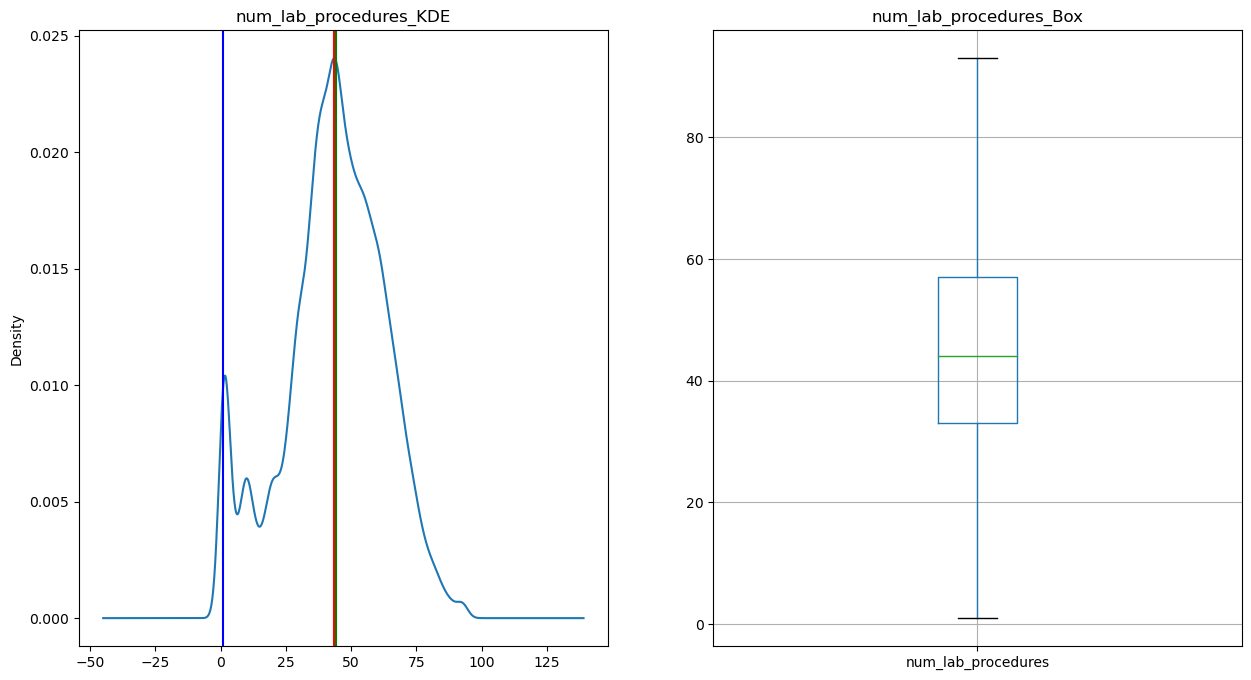

skewnum_lab_procedures -0.32629016125374755
kurtnum_lab_procedures -0.1938604583703305
meannum_lab_procedures 43.27532307107564
mediannum_lab_procedures 44.0
modenum_lab_procedures 1.0
stdnum_lab_procedures 19.37846091499254
varnum_lab_procedures 375.5247474338935
num_procedures


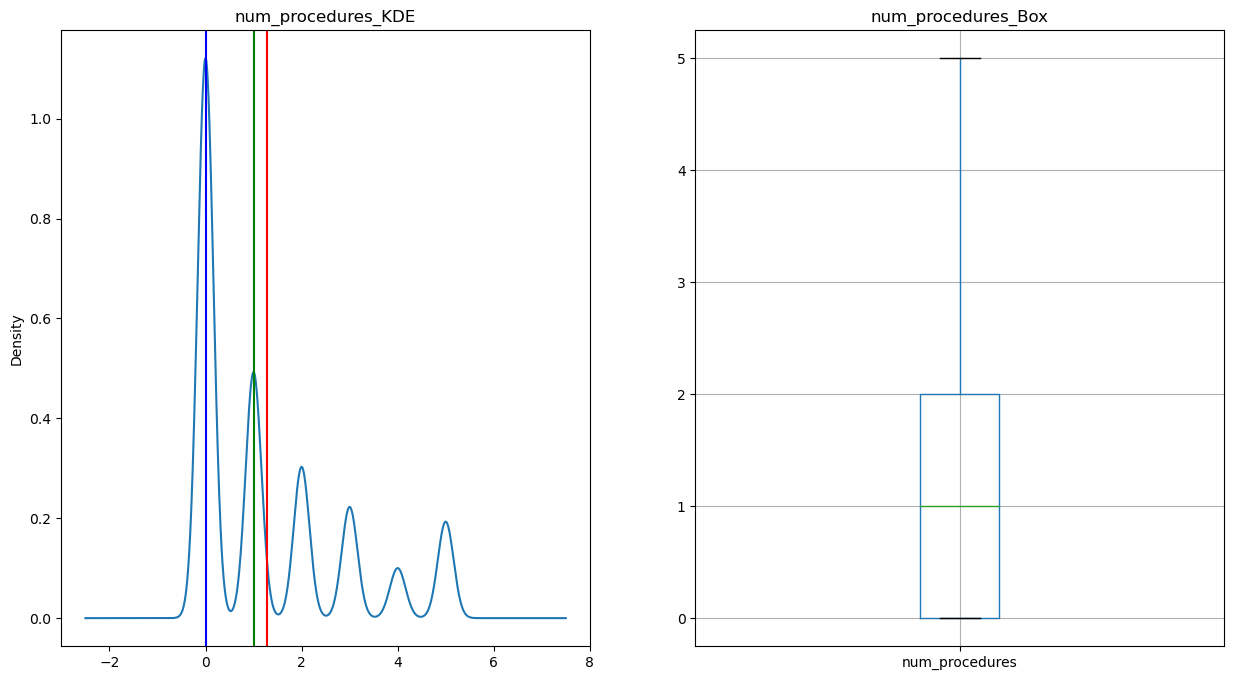

skewnum_procedures 1.1061886389554223
kurtnum_procedures 0.07883820254902352
meannum_procedures 1.2879014633219308
mediannum_procedures 1.0
modenum_procedures 0.0
stdnum_procedures 1.584264763062768
varnum_procedures 2.5098948394823286
num_medications


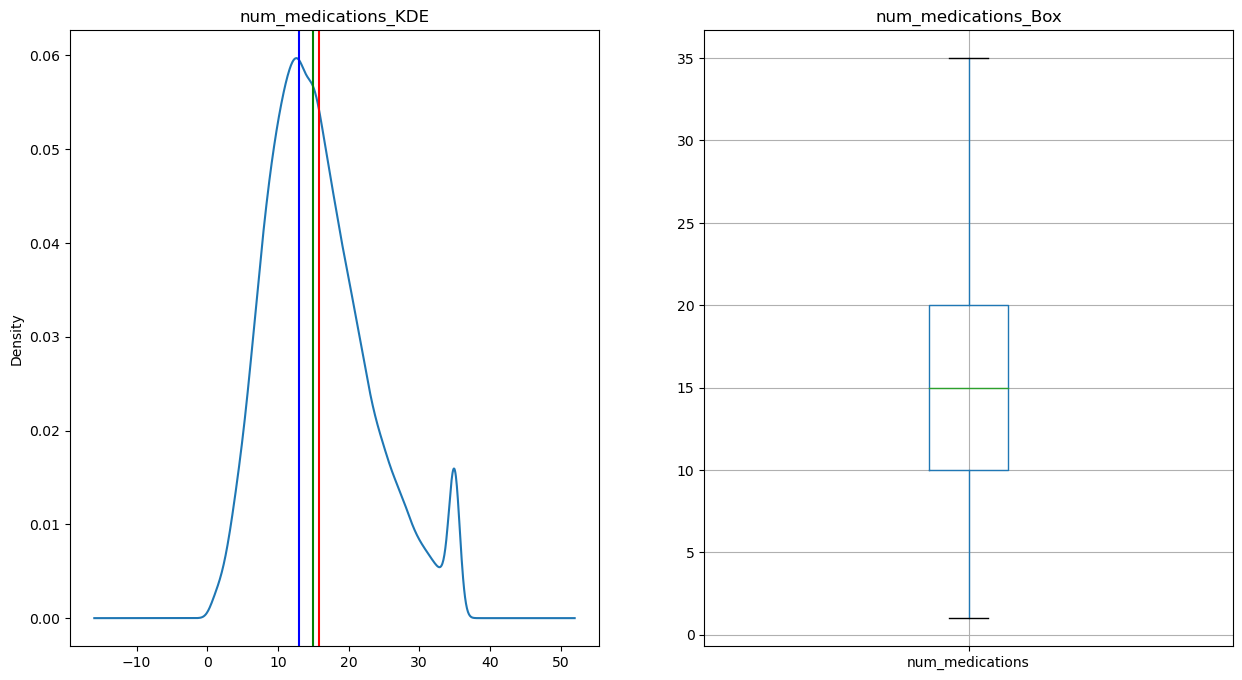

skewnum_medications 0.6728846101911212
kurtnum_medications 0.0945723846809754
meannum_medications 15.828190326871912
mediannum_medications 15.0
modenum_medications 13.0
stdnum_medications 7.342432702596382
varnum_medications 53.9113179921568
number_outpatient


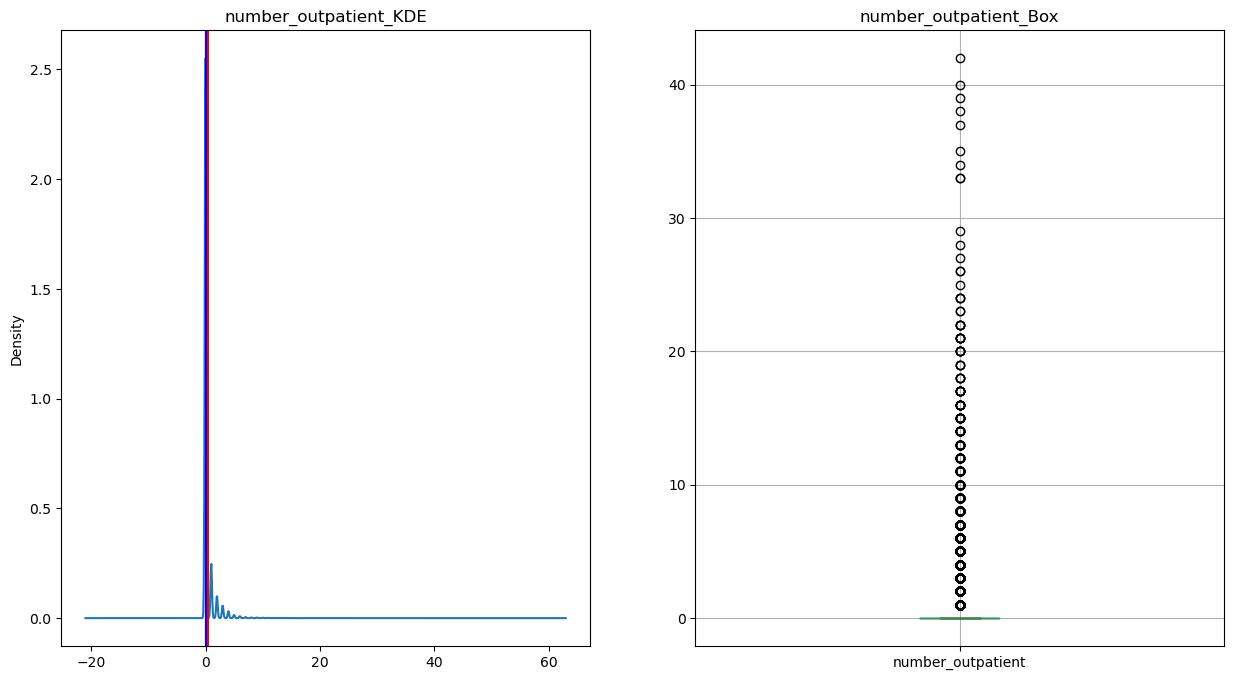

skewnumber_outpatient 8.794054207020851
kurtnumber_outpatient 146.21838525660158
meannumber_outpatient 0.3591552641581148
mediannumber_outpatient 0.0
modenumber_outpatient 0
stdnumber_outpatient 1.2531196031969527
varnumber_outpatient 1.5703087399164883
number_emergency


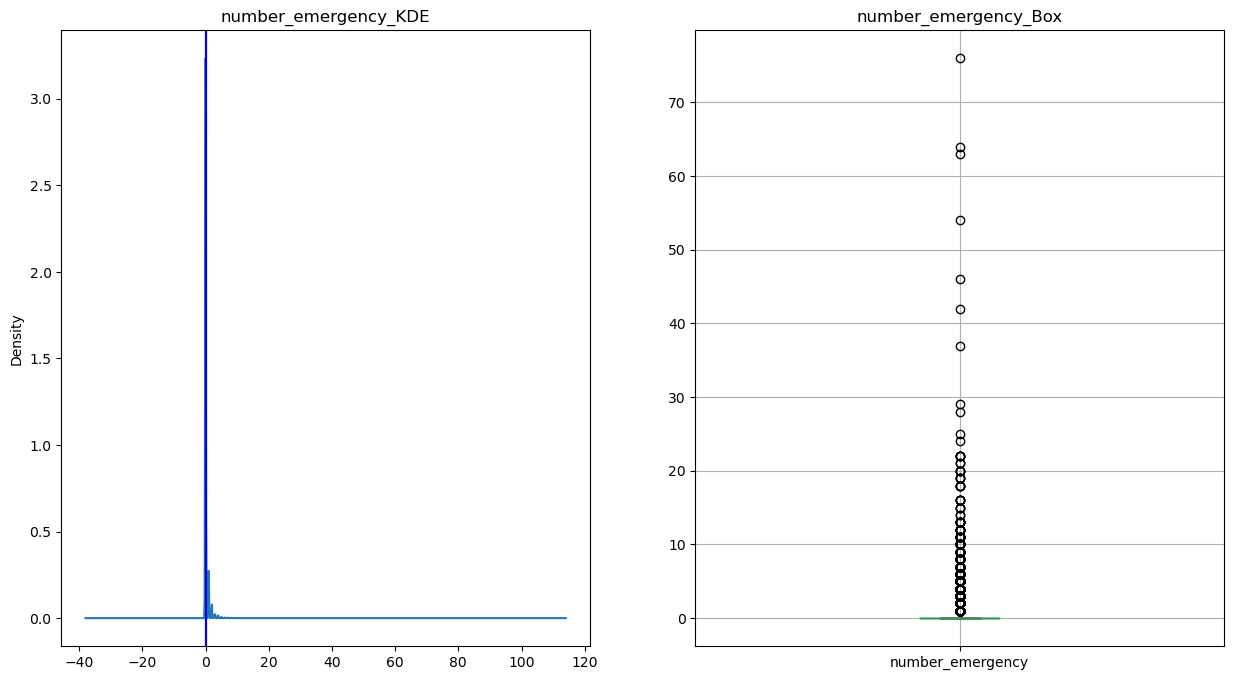

skewnumber_emergency 22.850362919065933
kurtnumber_emergency 1148.22975782827
meannumber_emergency 0.2082977004941087
mediannumber_emergency 0.0
modenumber_emergency 0
stdnumber_emergency 0.9824999077144982
varnumber_emergency 0.9653060686589976
number_inpatient


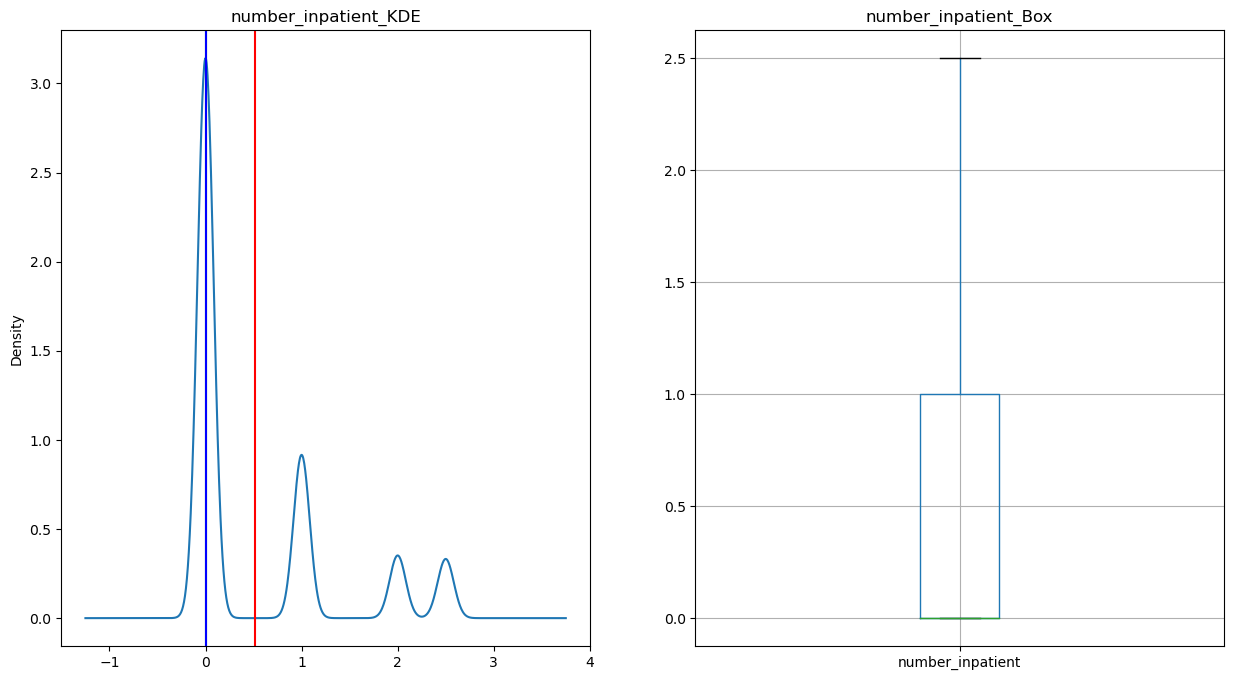

skewnumber_inpatient 1.338909985163846
kurtnumber_inpatient 0.43821159720758995
meannumber_inpatient 0.5165930254656025
mediannumber_inpatient 0.0
modenumber_inpatient 0.0
stdnumber_inpatient 0.8128040479685537
varnumber_inpatient 0.6606504203940669
number_diagnoses


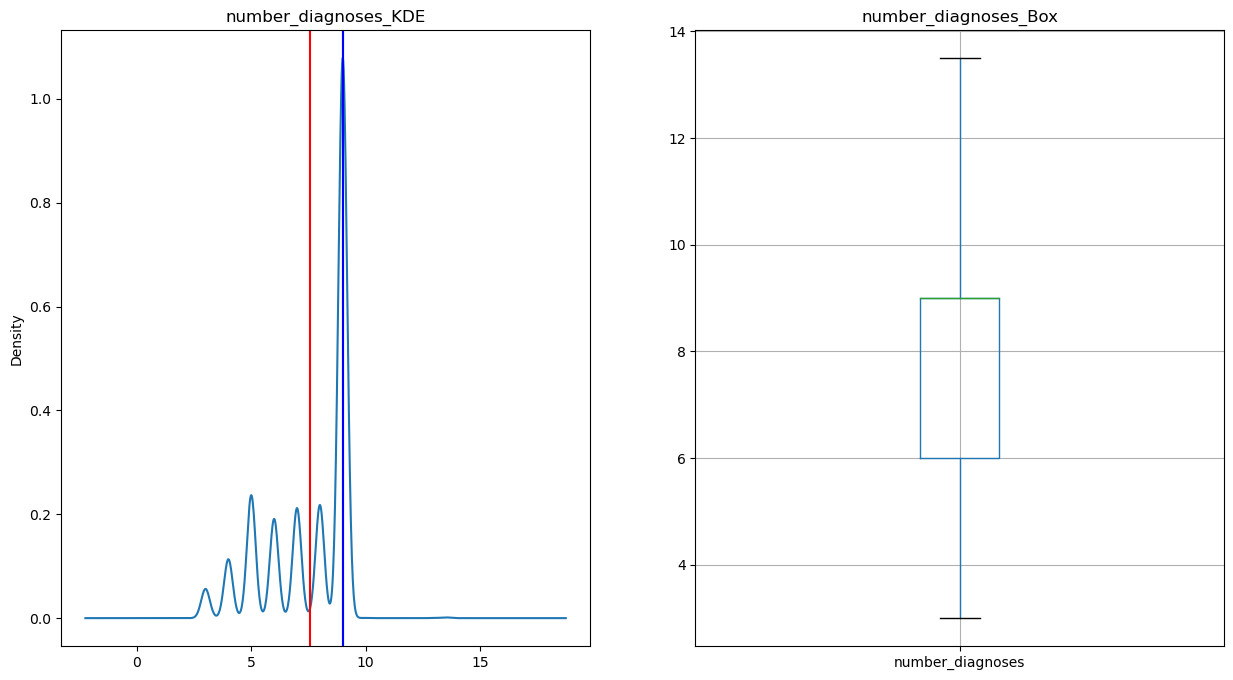

skewnumber_diagnoses -0.8807589650848986
kurtnumber_diagnoses -0.4339908476914722
meannumber_diagnoses 7.549814709236032
mediannumber_diagnoses 9.0
modenumber_diagnoses 9.0
stdnumber_diagnoses 1.8275752578047981
varnumber_diagnoses 3.3400313229402743
readmitted


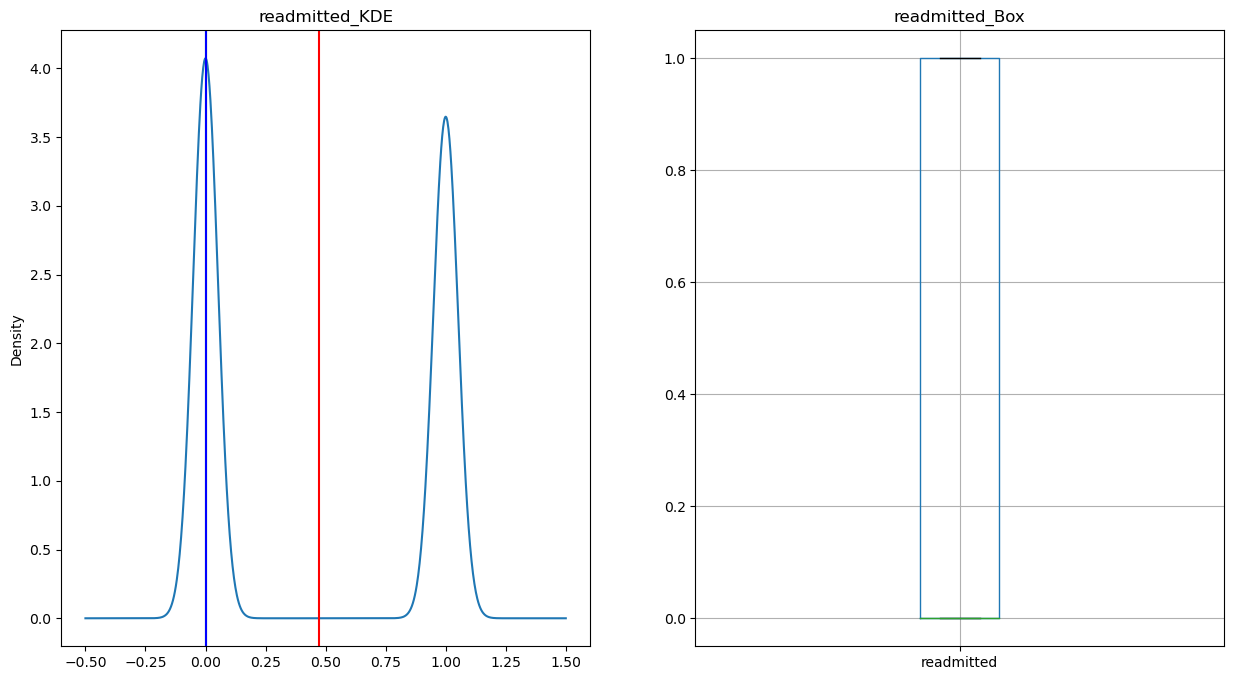

skewreadmitted 0.11029853627578236
kurtreadmitted -1.9878814560332971
meanreadmitted 0.47246769289243634
medianreadmitted 0.0
modereadmitted 0
stdreadmitted 0.499244361510507
varreadmitted 0.2492449325000338


In [56]:
for i in num.columns:
    print(i)
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    num[i].plot(kind='kde')
    plt.axvline(num[i].mean(),color='r')
    plt.axvline(num[i].median(),color='g')
    plt.axvline(num[i].mode()[0],color='b')
    plt.title(i+'_KDE')
    plt.subplot(1,2,2)
    plt.title(i+'_Box')
    num[[i]].boxplot()
    plt.show()
    print('skew'+i,num[i].skew())
    print('kurt'+i,num[i].kurt())
    print('mean'+i,num[i].mean())
    print('median'+i,num[i].median())
    print('mode'+i,num[i].mode()[0])
    print('std'+i,num[i].std())
    print('var'+i,num[i].var())

In [57]:
# Univariate Analysis for categorical data

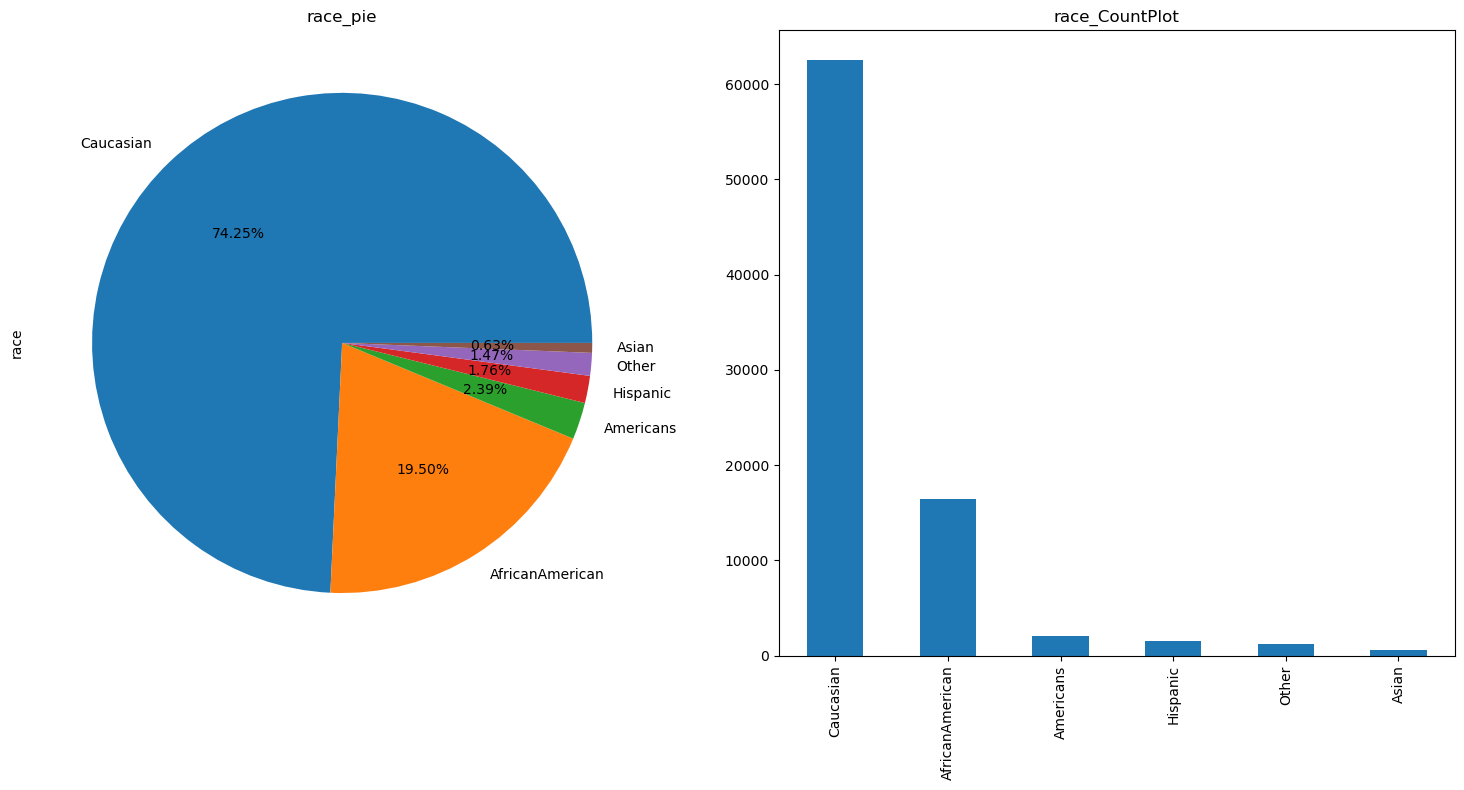

unique ['Caucasian' 'AfricanAmerican' 'Americans' 'Other' 'Asian' 'Hispanic']
mode 0    Caucasian
Name: race, dtype: object
count of all sub categories Caucasian          62512
AfricanAmerican    16417
Americans           2011
Hispanic            1479
Other               1239
Asian                534
Name: race, dtype: int64


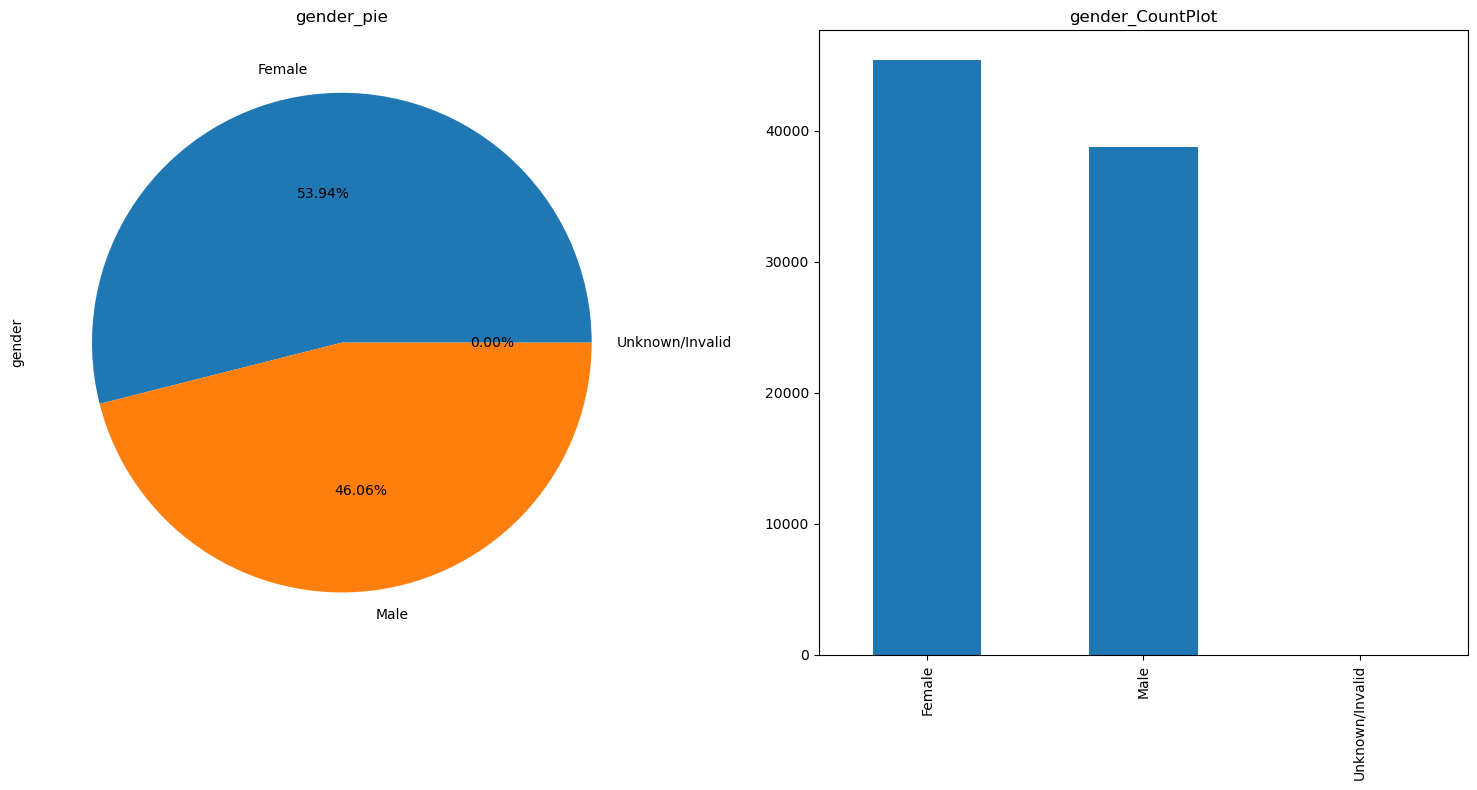

unique ['Female' 'Male' 'Unknown/Invalid']
mode 0    Female
Name: gender, dtype: object
count of all sub categories Female             45414
Male               38775
Unknown/Invalid        3
Name: gender, dtype: int64


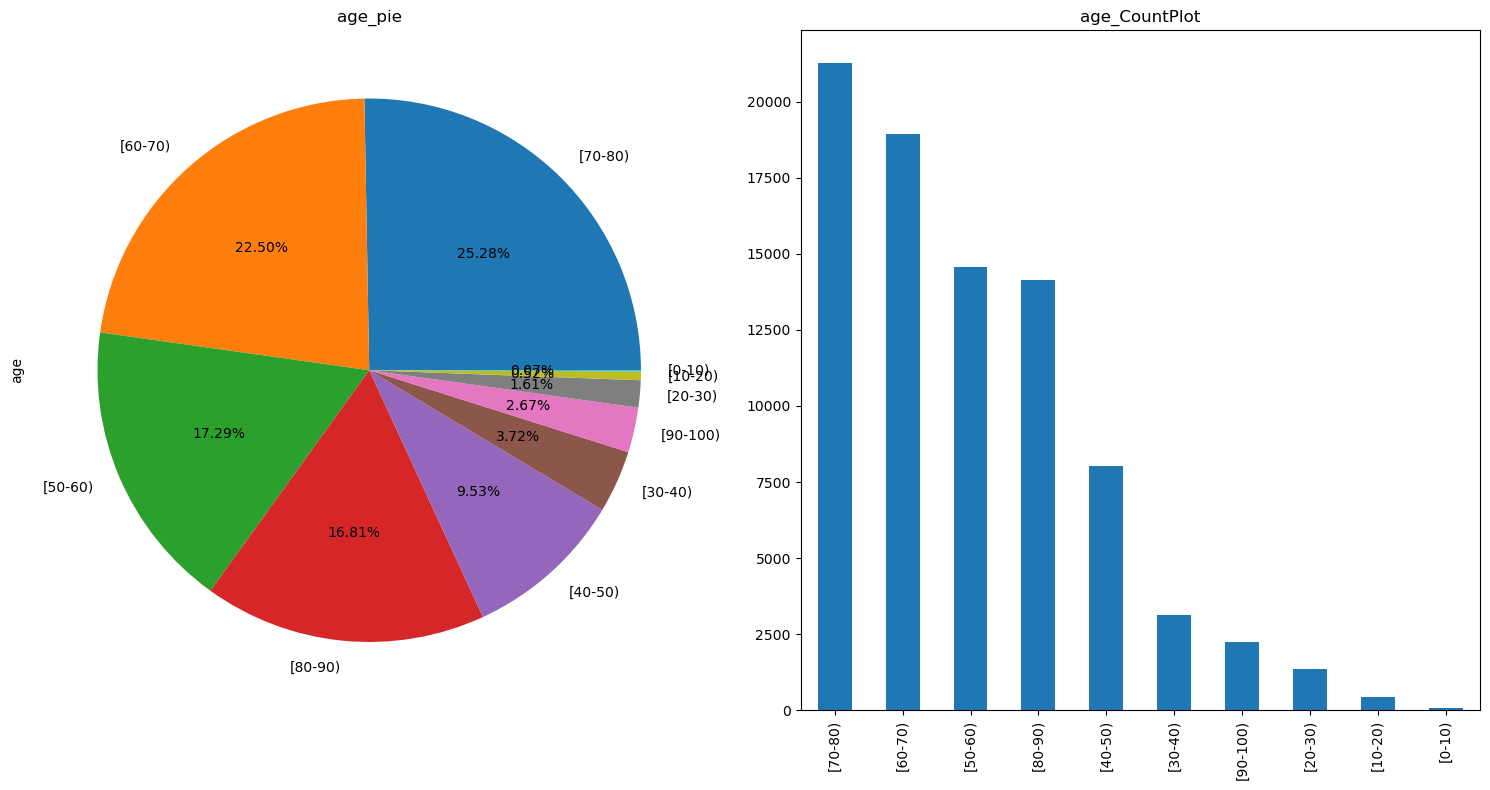

unique ['[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)'
 '[80-90)' '[90-100)' '[0-10)']
mode 0    [70-80)
Name: age, dtype: object
count of all sub categories [70-80)     21286
[60-70)     18939
[50-60)     14555
[80-90)     14152
[40-50)      8027
[30-40)      3129
[90-100)     2251
[20-30)      1358
[10-20)       436
[0-10)         59
Name: age, dtype: int64


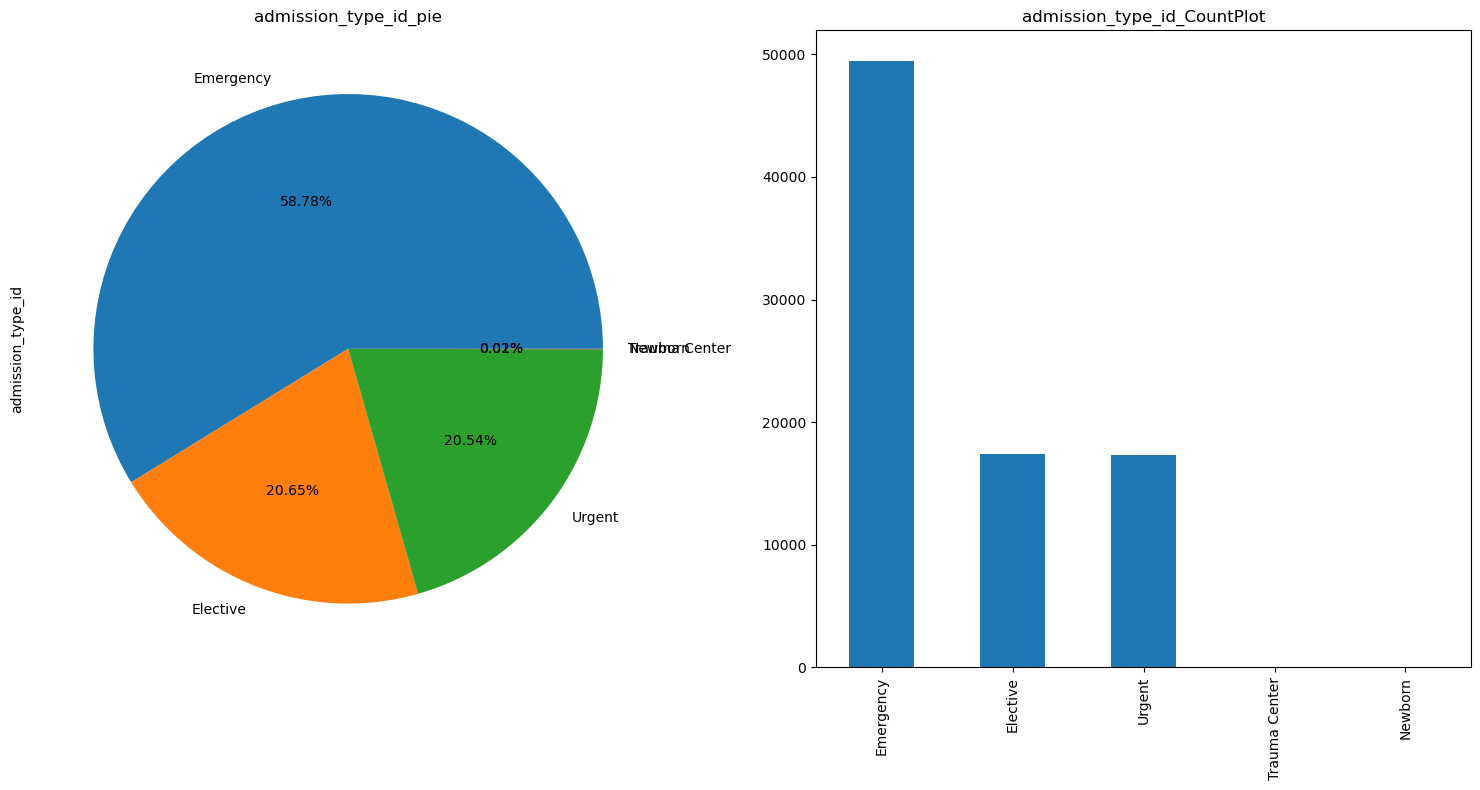

unique ['Emergency' 'Urgent' 'Elective' 'Newborn' 'Trauma Center']
mode 0    Emergency
Name: admission_type_id, dtype: object
count of all sub categories Emergency        49485
Elective         17383
Urgent           17296
Trauma Center       18
Newborn             10
Name: admission_type_id, dtype: int64


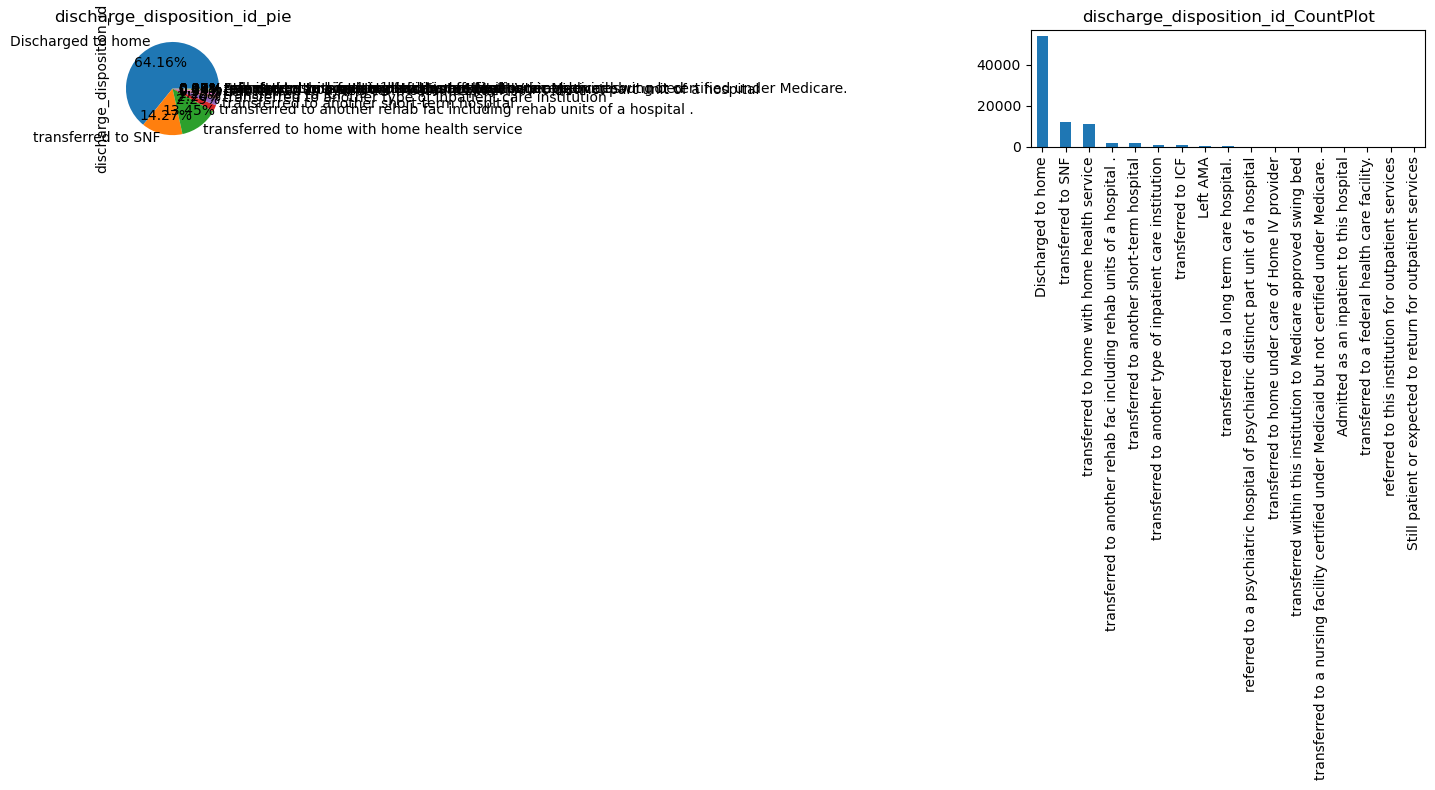

unique ['Discharged to home' 'transferred to SNF'
 'transferred to home with home health service'
 'transferred to another short-term hospital'
 'transferred to another type of inpatient care institution' 'Left AMA'
 'transferred to ICF' 'transferred to home under care of Home IV provider'
 'Still patient or expected to return for outpatient services'
 'transferred to another rehab fac including rehab units of a hospital .'
 'referred to this institution for outpatient services'
 'Admitted as an inpatient to this hospital'
 'transferred to a long term care hospital.'
 'transferred within this institution to Medicare approved swing bed'
 'transferred to a nursing facility certified under Medicaid but not certified under Medicare.'
 'referred to a psychiatric hospital of psychiatric distinct part unit of a hospital'
 'transferred to a federal health care facility.']
mode 0    Discharged to home
Name: discharge_disposition_id, dtype: object
count of all sub categories Discharged to home  

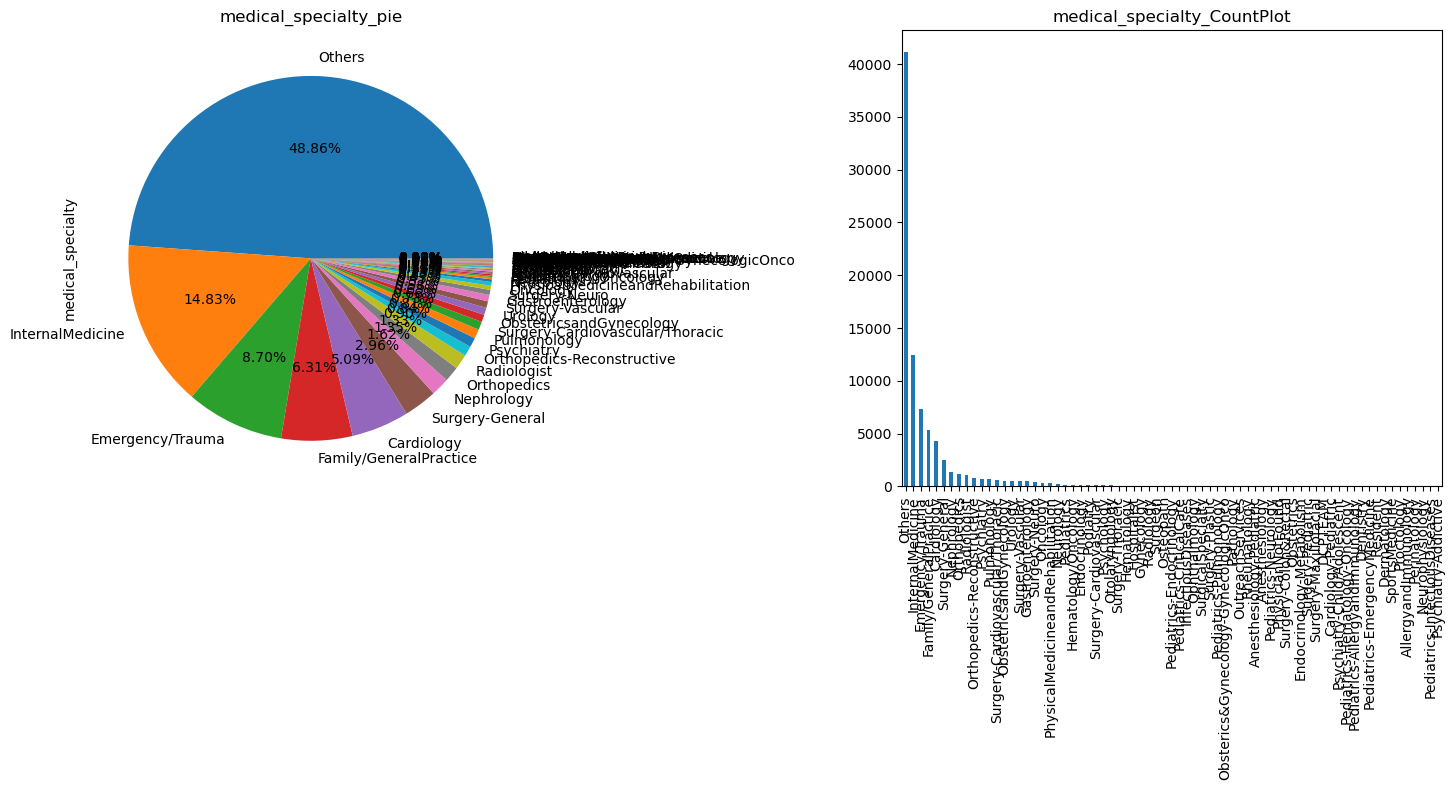

unique ['Others' 'InternalMedicine' 'Family/GeneralPractice' 'Cardiology'
 'Surgery-General' 'Orthopedics' 'Gastroenterology' 'Nephrology'
 'Orthopedics-Reconstructive' 'Pulmonology' 'Psychiatry' 'Surgery-Neuro'
 'Obsterics&Gynecology-GynecologicOnco' 'Endocrinology' 'Urology'
 'Radiology' 'ObstetricsandGynecology' 'Pediatrics'
 'Pediatrics-Hematology-Oncology' 'Surgery-Cardiovascular/Thoracic'
 'Anesthesiology-Pediatric' 'Emergency/Trauma' 'Pediatrics-CriticalCare'
 'Neurology' 'Pediatrics-Endocrinology' 'Hematology/Oncology'
 'Psychiatry-Child/Adolescent' 'Surgery-Colon&Rectal'
 'Pediatrics-Pulmonology' 'Gynecology' 'Pediatrics-Neurology'
 'Surgery-Plastic' 'Psychology' 'Ophthalmology' 'Surgery-Pediatric'
 'PhysicalMedicineandRehabilitation' 'Otolaryngology' 'InfectiousDiseases'
 'Podiatry' 'Anesthesiology' 'Oncology' 'Pediatrics-EmergencyMedicine'
 'Surgery-Maxillofacial' 'Pediatrics-InfectiousDiseases'
 'Pediatrics-AllergyandImmunology' 'Surgeon' 'Surgery-Vascular'
 'Osteopath' 'Su

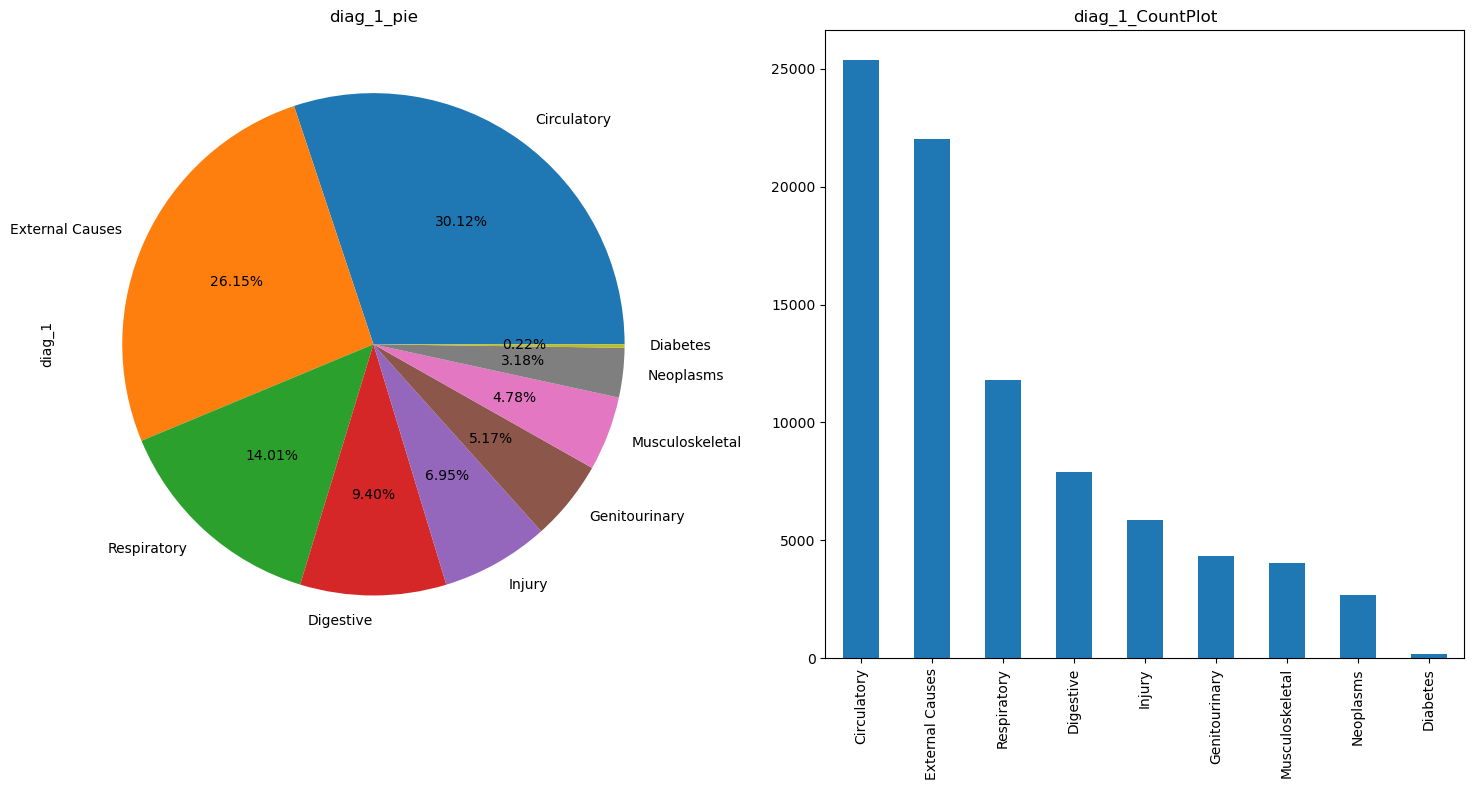

unique ['External Causes' 'Neoplasms' 'Circulatory' 'Respiratory' 'Injury'
 'Musculoskeletal' 'Digestive' 'Genitourinary' 'Diabetes']
mode 0    Circulatory
Name: diag_1, dtype: object
count of all sub categories Circulatory        25358
External Causes    22019
Respiratory        11799
Digestive           7914
Injury              5853
Genitourinary       4354
Musculoskeletal     4028
Neoplasms           2680
Diabetes             187
Name: diag_1, dtype: int64


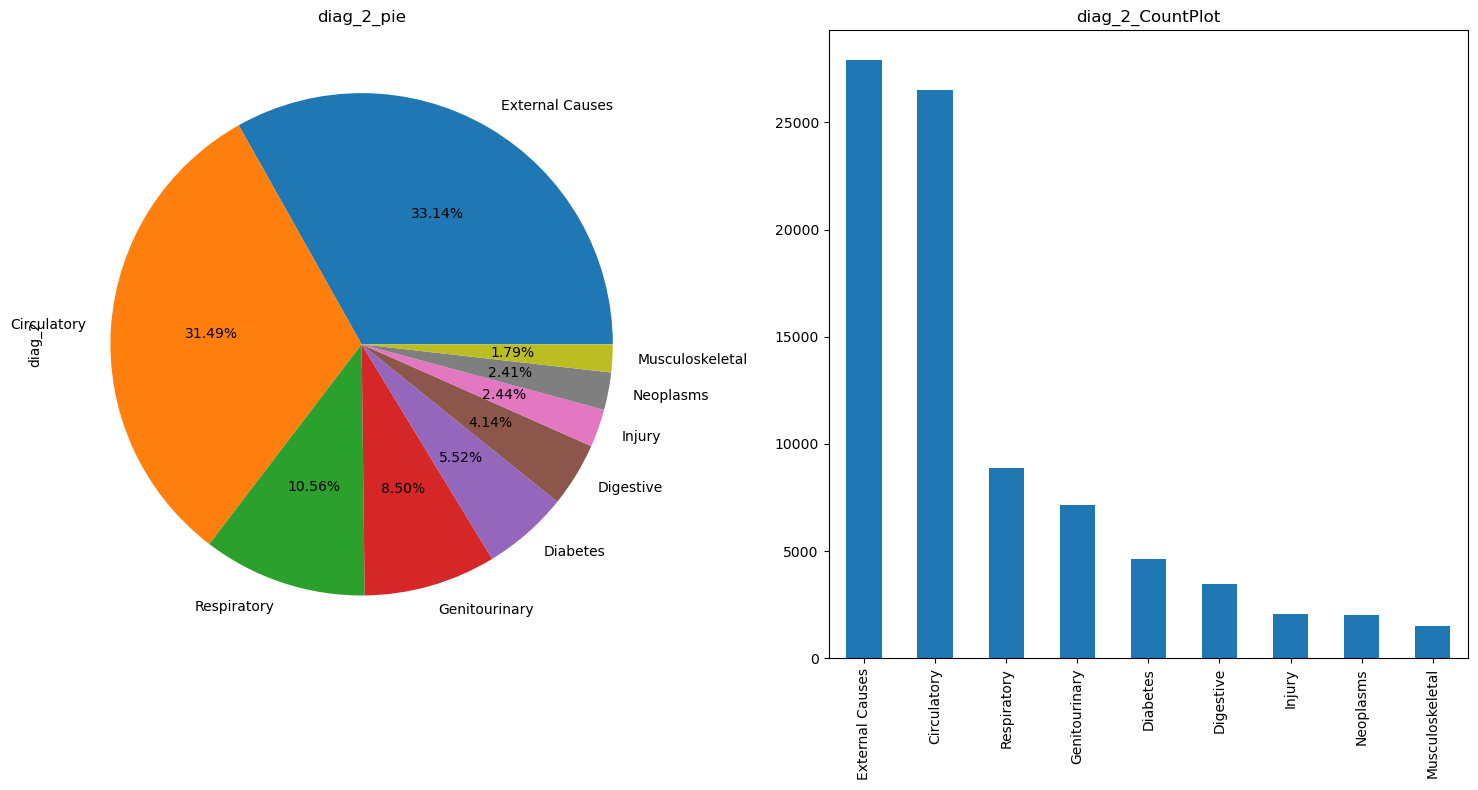

unique ['External Causes' 'Diabetes' 'Neoplasms' 'Circulatory' 'Respiratory'
 'Injury' 'Musculoskeletal' 'Genitourinary' 'Digestive']
mode 0    External Causes
Name: diag_2, dtype: object
count of all sub categories External Causes    27899
Circulatory        26516
Respiratory         8893
Genitourinary       7160
Diabetes            4646
Digestive           3485
Injury              2055
Neoplasms           2030
Musculoskeletal     1508
Name: diag_2, dtype: int64


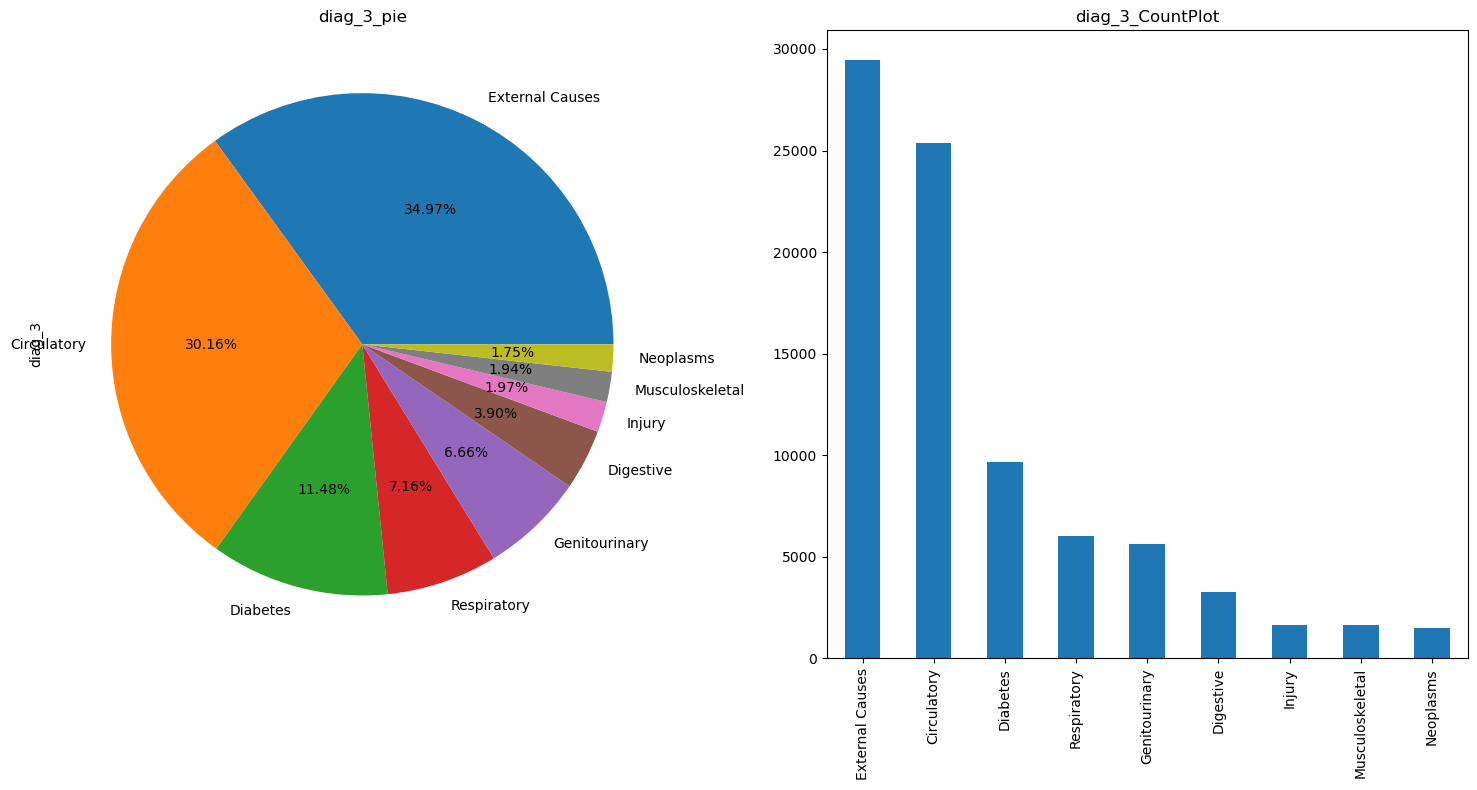

unique ['External Causes' 'Circulatory' 'Diabetes' 'Respiratory' 'Injury'
 'Neoplasms' 'Genitourinary' 'Musculoskeletal' 'Digestive']
mode 0    External Causes
Name: diag_3, dtype: object
count of all sub categories External Causes    29446
Circulatory        25391
Diabetes            9667
Respiratory         6027
Genitourinary       5611
Digestive           3285
Injury              1655
Musculoskeletal     1637
Neoplasms           1473
Name: diag_3, dtype: int64


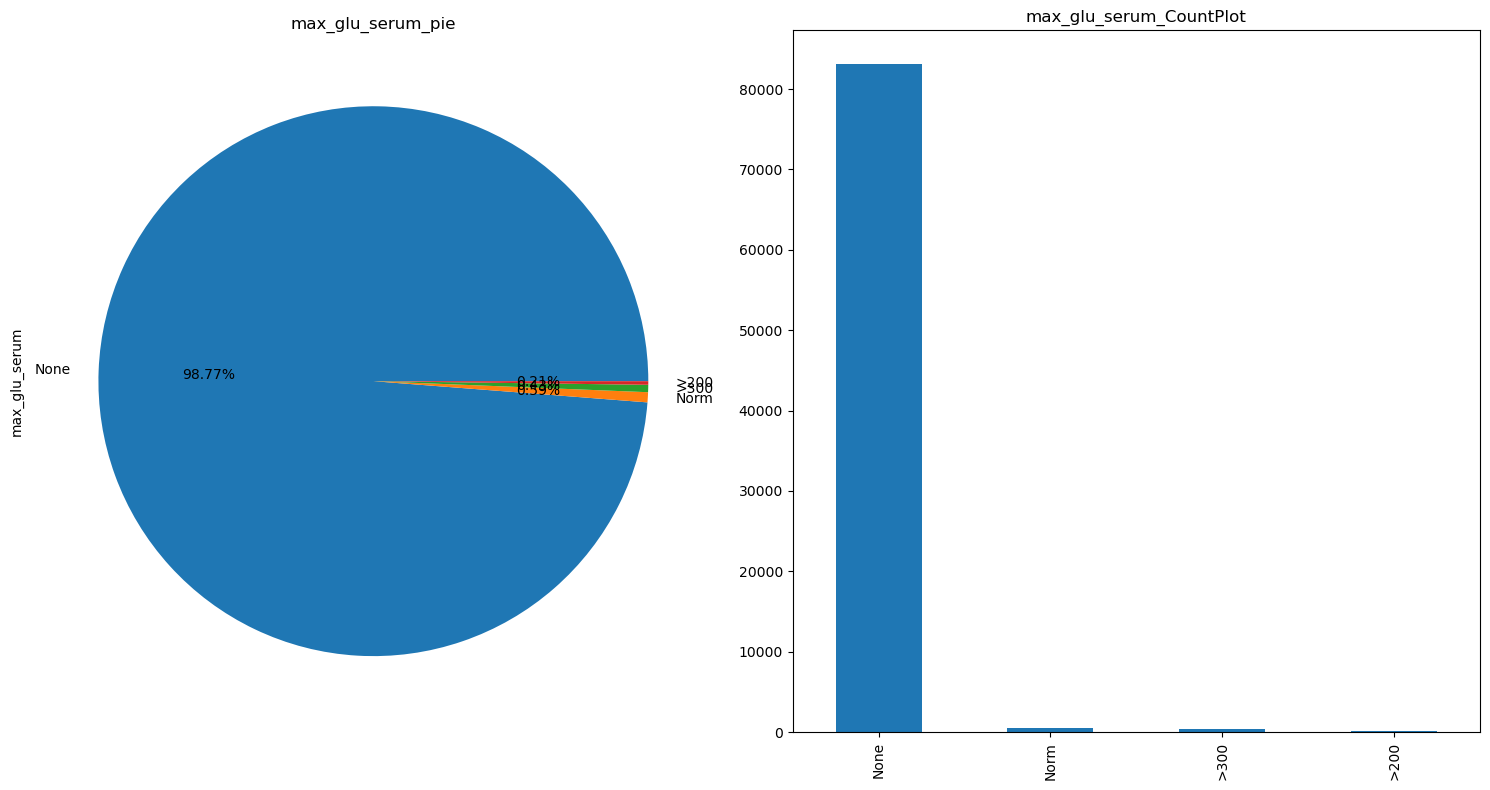

unique ['None' '>200' 'Norm' '>300']
mode 0    None
Name: max_glu_serum, dtype: object
count of all sub categories None    83157
Norm      497
>300      361
>200      177
Name: max_glu_serum, dtype: int64


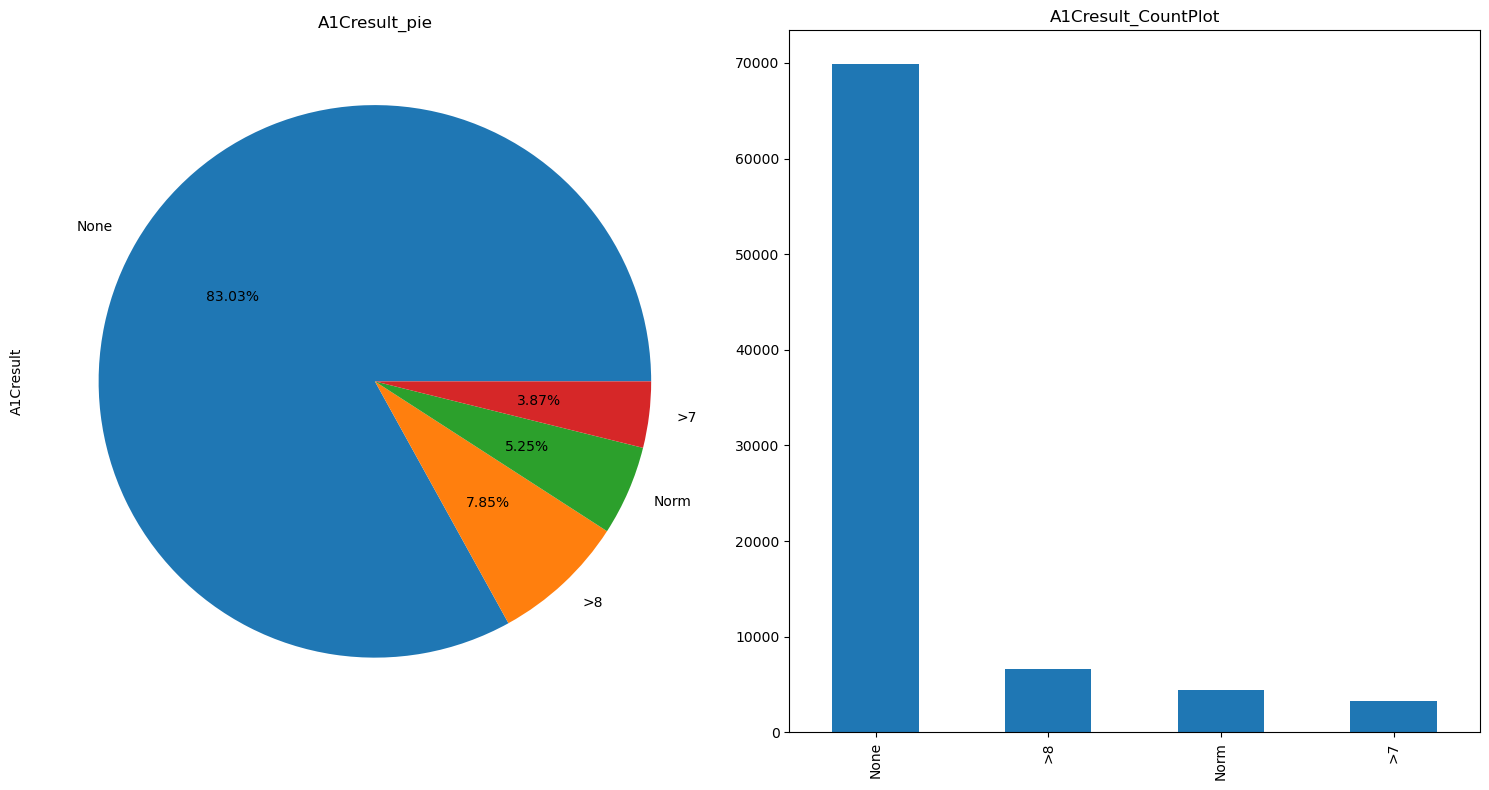

unique ['None' '>7' '>8' 'Norm']
mode 0    None
Name: A1Cresult, dtype: object
count of all sub categories None    69905
>8       6607
Norm     4423
>7       3257
Name: A1Cresult, dtype: int64


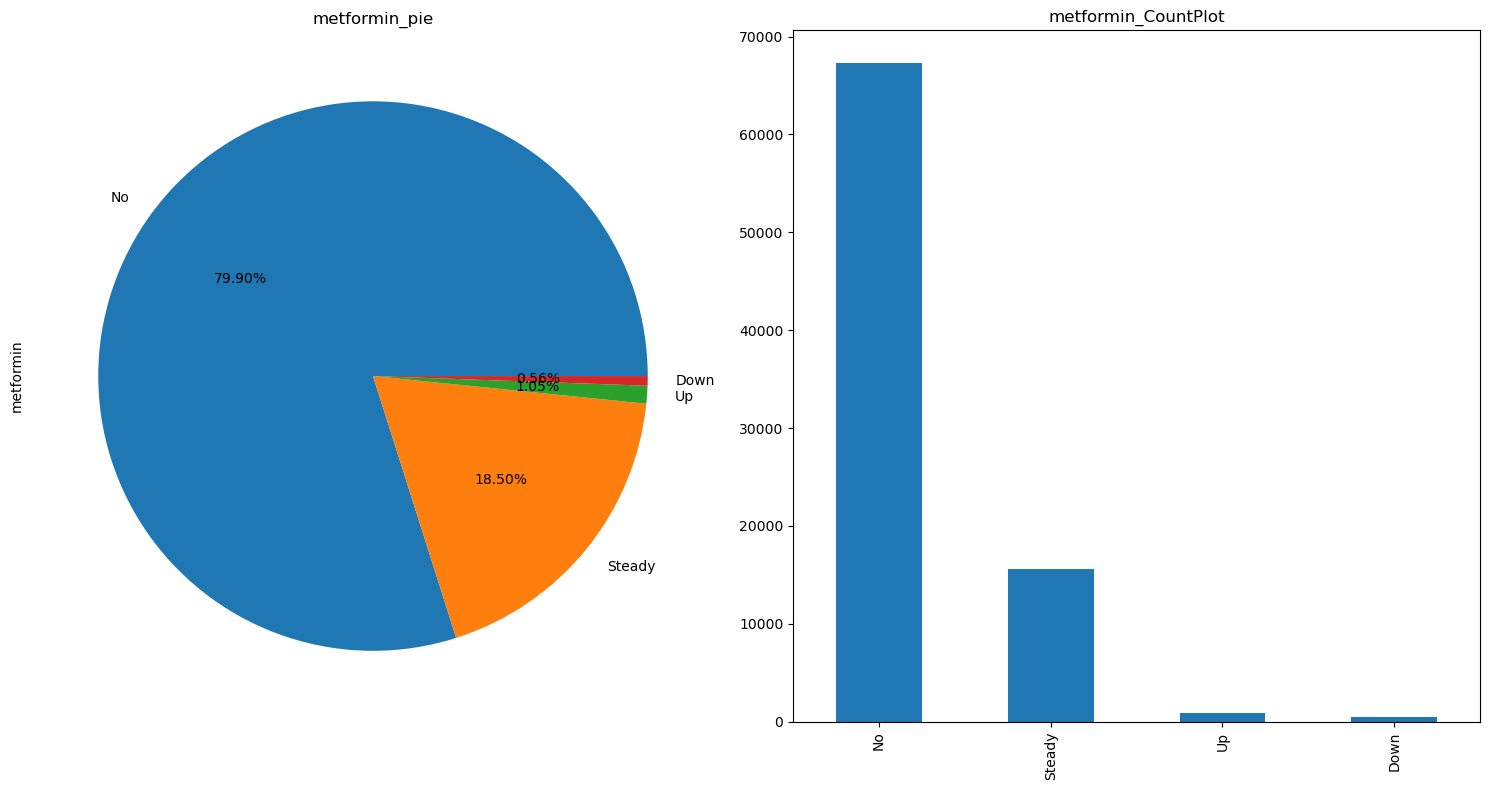

unique ['No' 'Steady' 'Up' 'Down']
mode 0    No
Name: metformin, dtype: object
count of all sub categories No        67267
Steady    15572
Up          880
Down        473
Name: metformin, dtype: int64


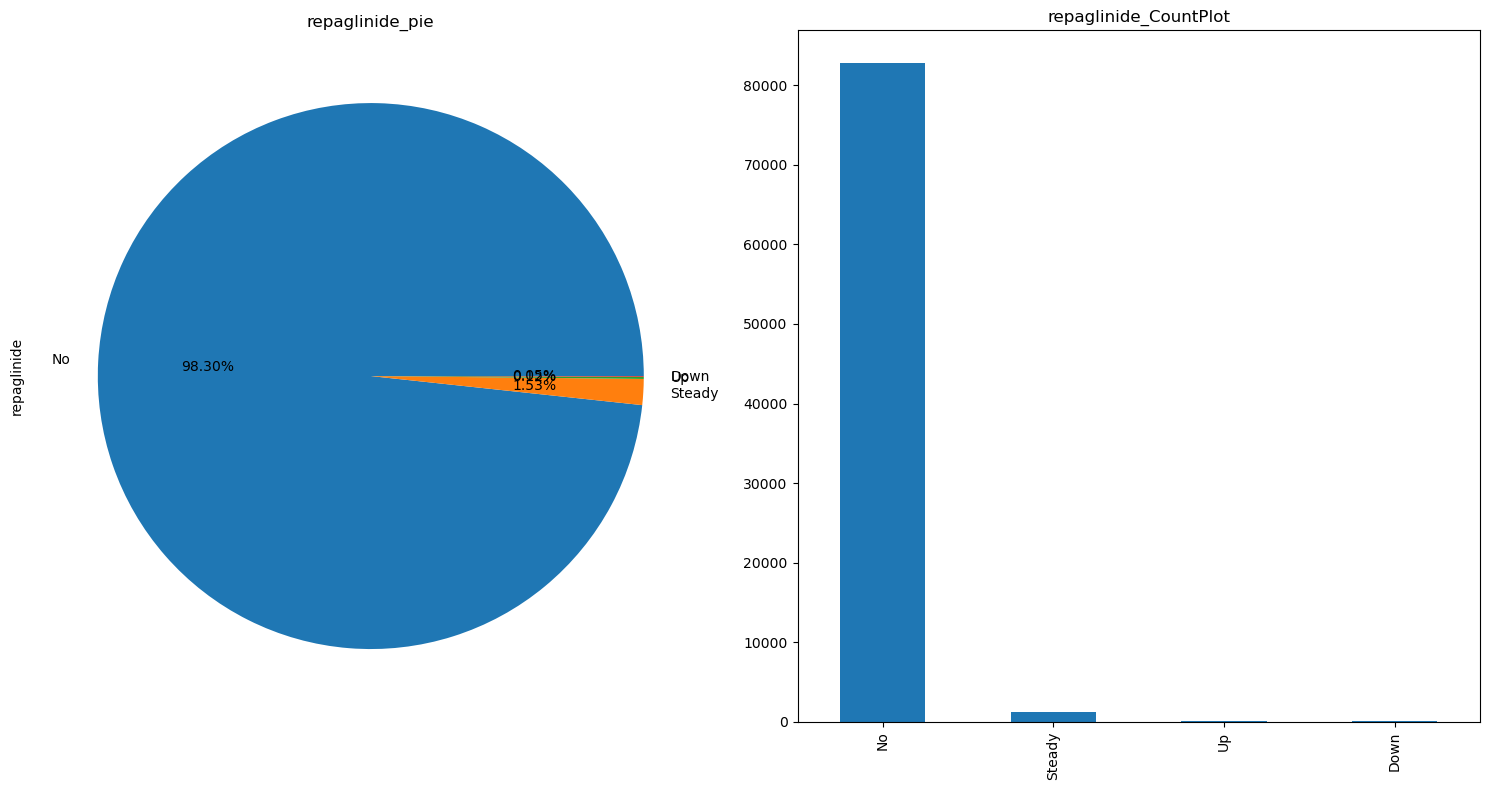

unique ['No' 'Up' 'Steady' 'Down']
mode 0    No
Name: repaglinide, dtype: object
count of all sub categories No        82762
Steady     1288
Up          102
Down         40
Name: repaglinide, dtype: int64


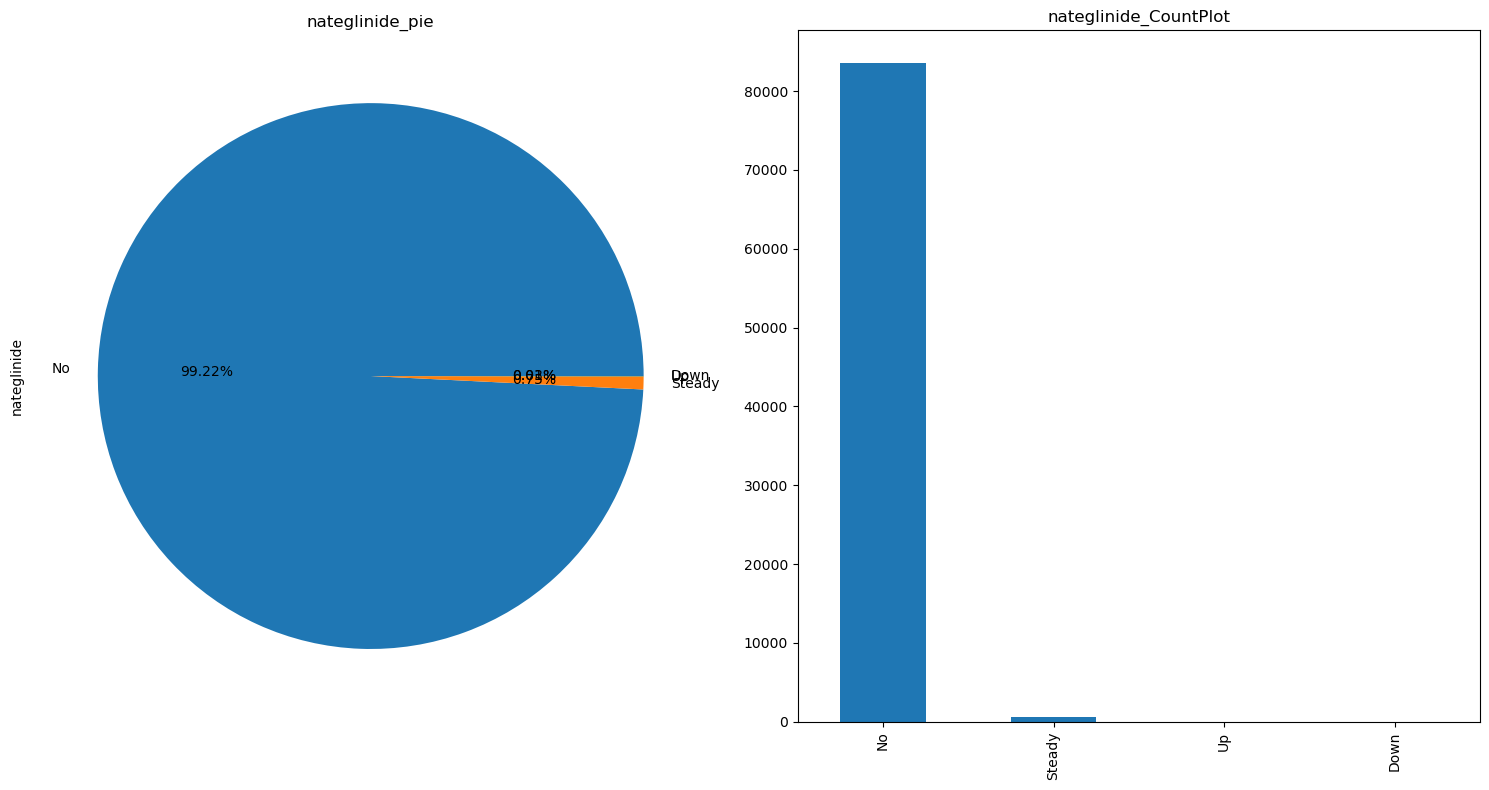

unique ['No' 'Steady' 'Down' 'Up']
mode 0    No
Name: nateglinide, dtype: object
count of all sub categories No        83532
Steady      628
Up           22
Down         10
Name: nateglinide, dtype: int64


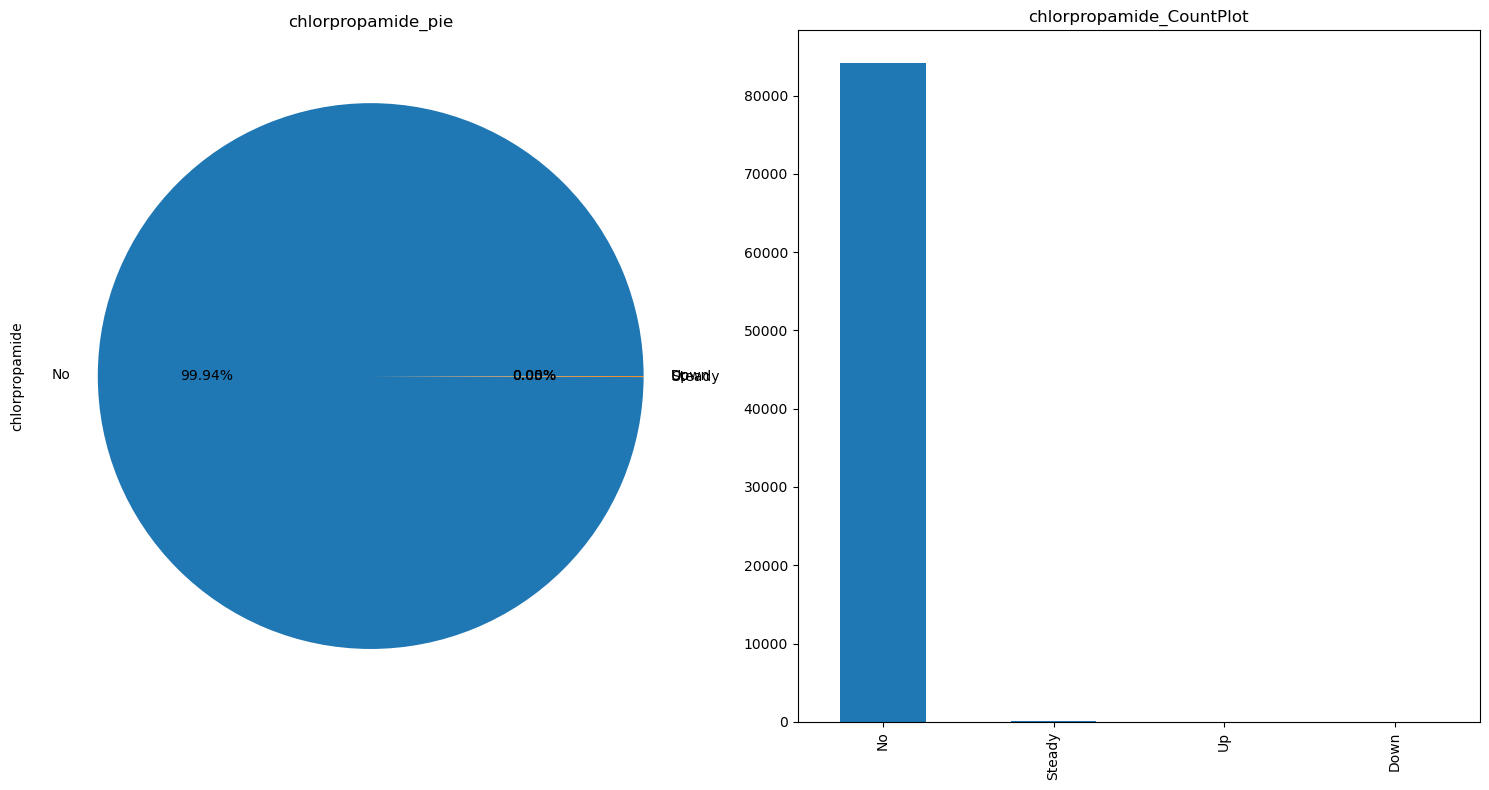

unique ['No' 'Steady' 'Down' 'Up']
mode 0    No
Name: chlorpropamide, dtype: object
count of all sub categories No        84142
Steady       45
Up            4
Down          1
Name: chlorpropamide, dtype: int64


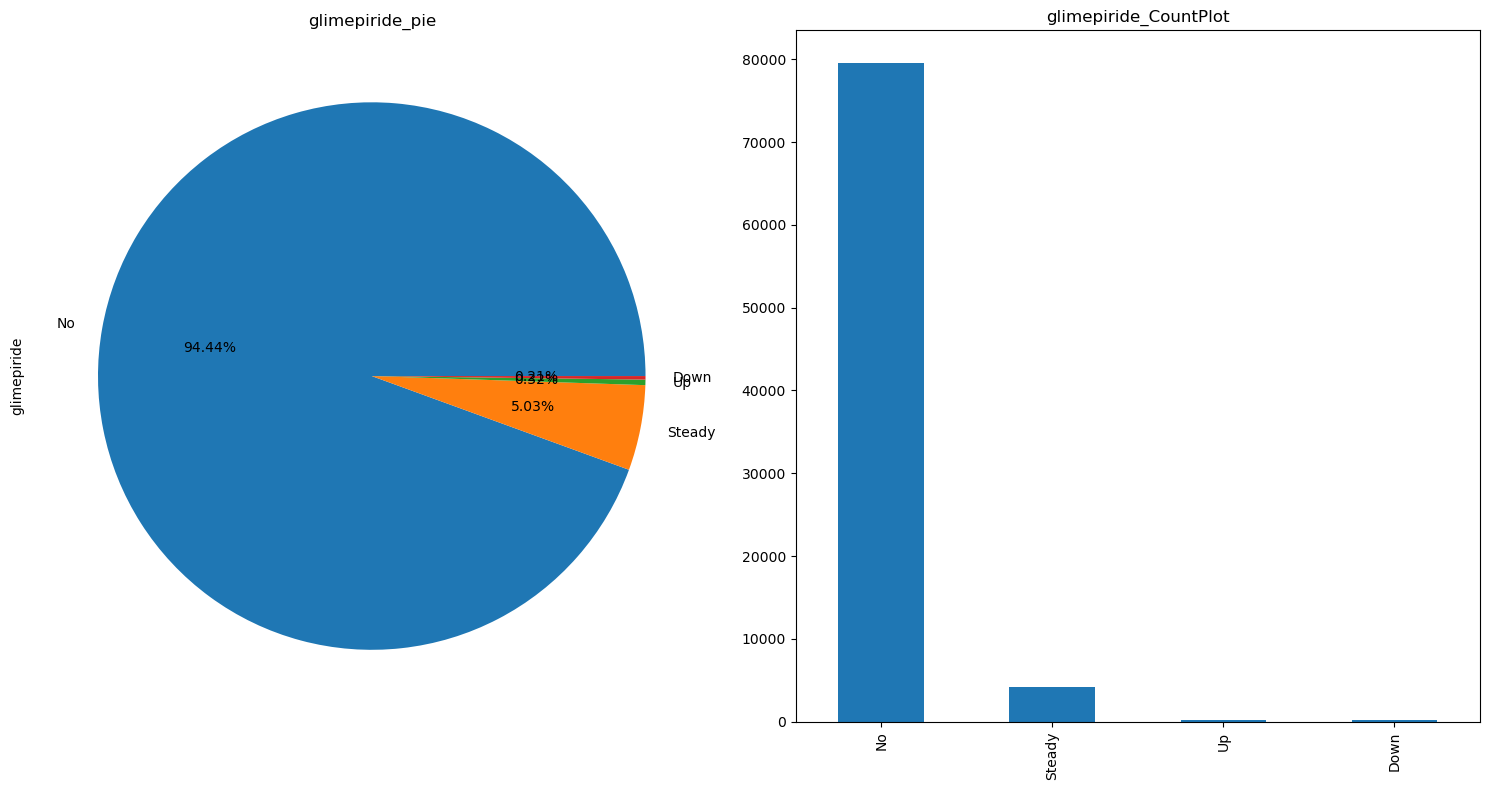

unique ['No' 'Steady' 'Up' 'Down']
mode 0    No
Name: glimepiride, dtype: object
count of all sub categories No        79510
Steady     4236
Up          272
Down        174
Name: glimepiride, dtype: int64


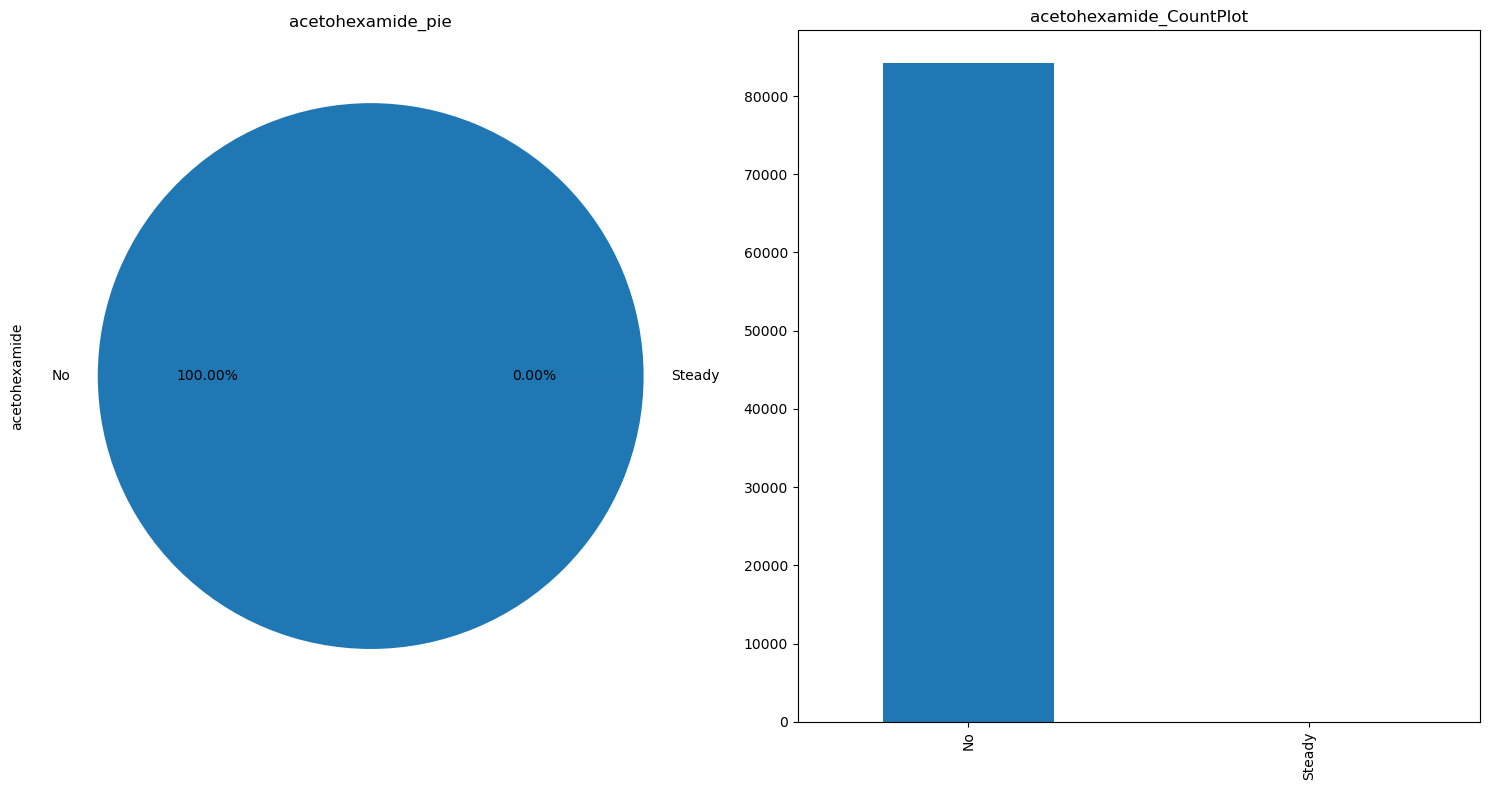

unique ['No' 'Steady']
mode 0    No
Name: acetohexamide, dtype: object
count of all sub categories No        84191
Steady        1
Name: acetohexamide, dtype: int64


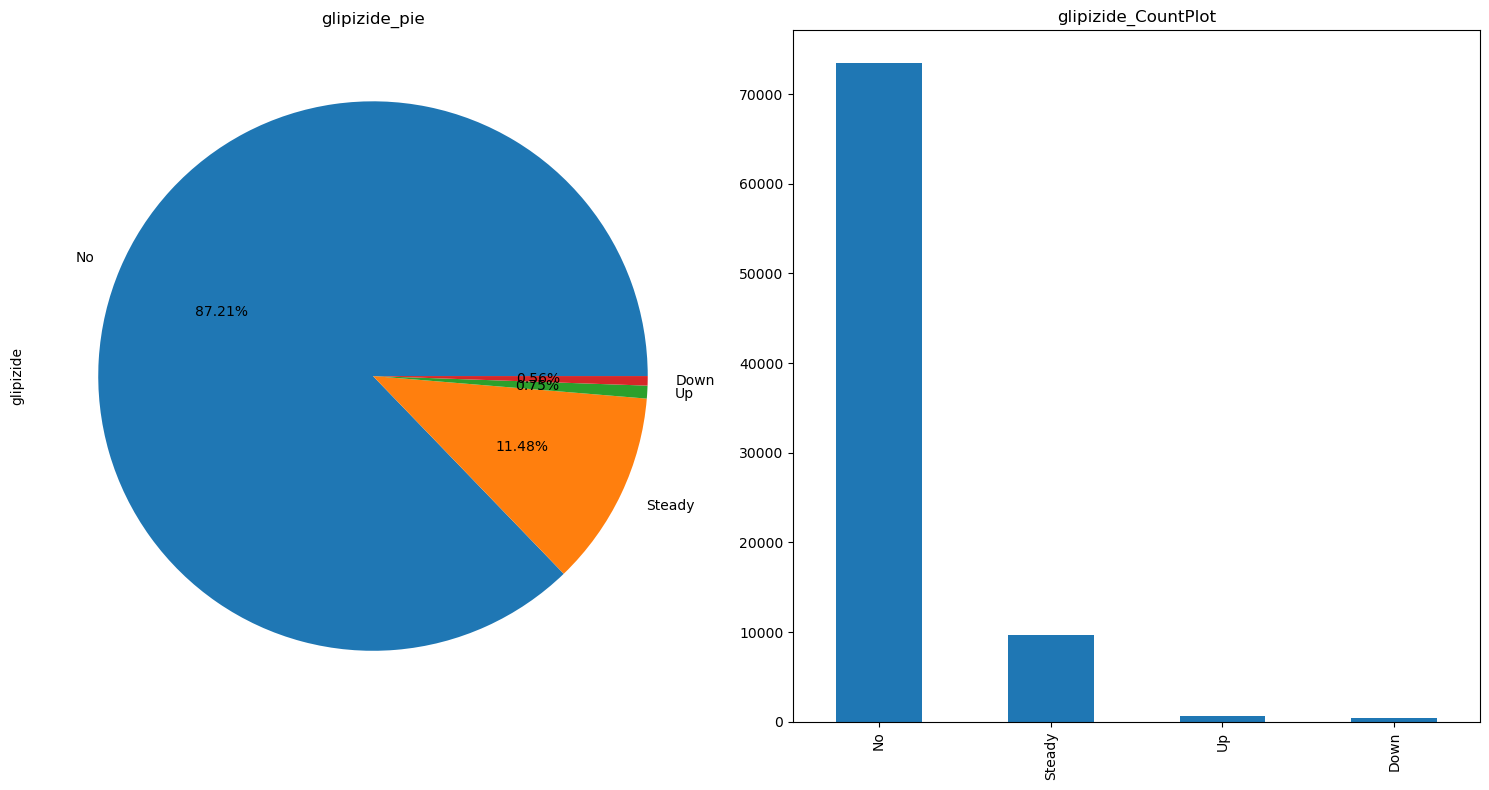

unique ['No' 'Steady' 'Down' 'Up']
mode 0    No
Name: glipizide, dtype: object
count of all sub categories No        73428
Steady     9662
Up          634
Down        468
Name: glipizide, dtype: int64


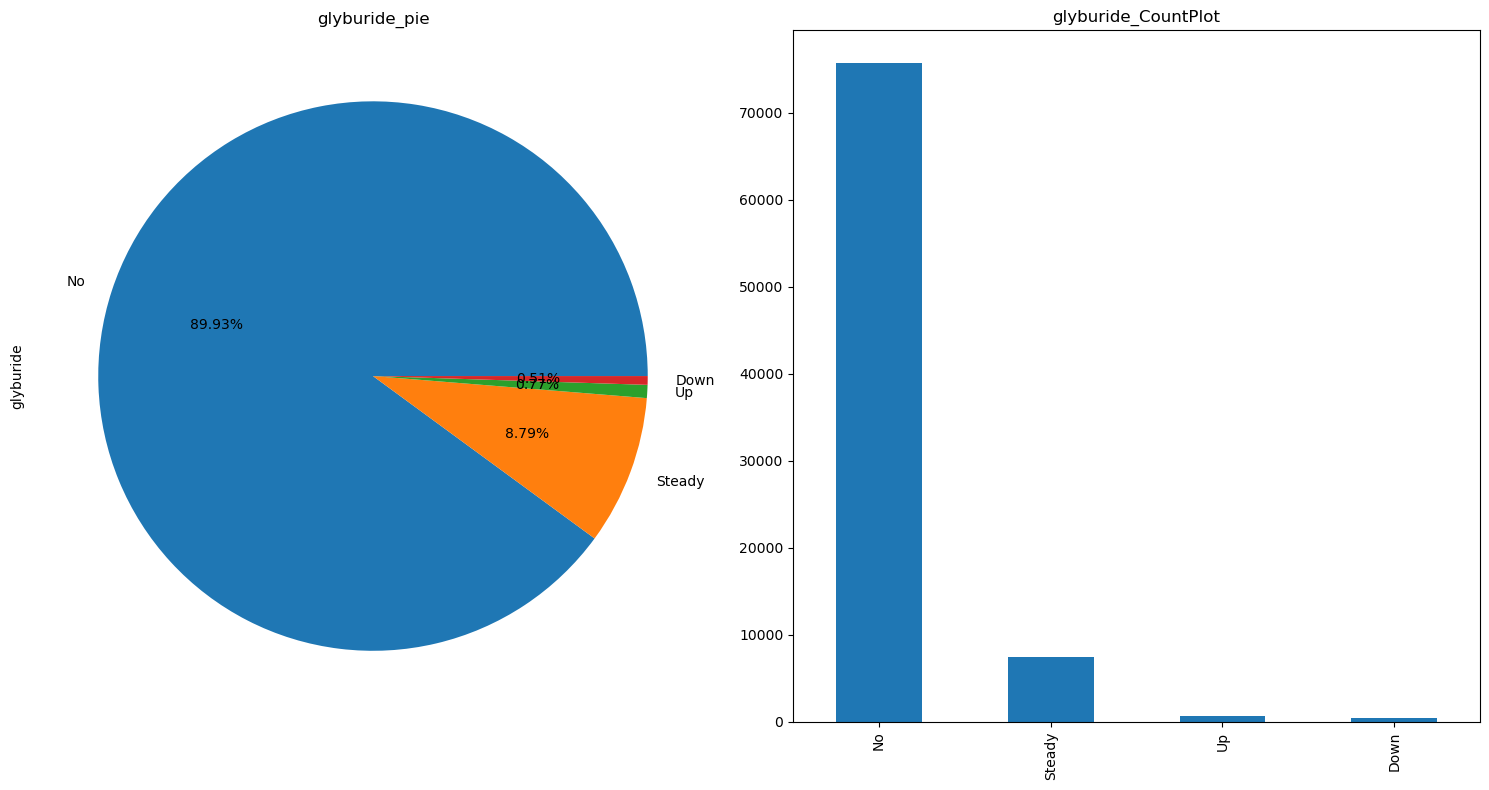

unique ['No' 'Steady' 'Up' 'Down']
mode 0    No
Name: glyburide, dtype: object
count of all sub categories No        75717
Steady     7397
Up          648
Down        430
Name: glyburide, dtype: int64


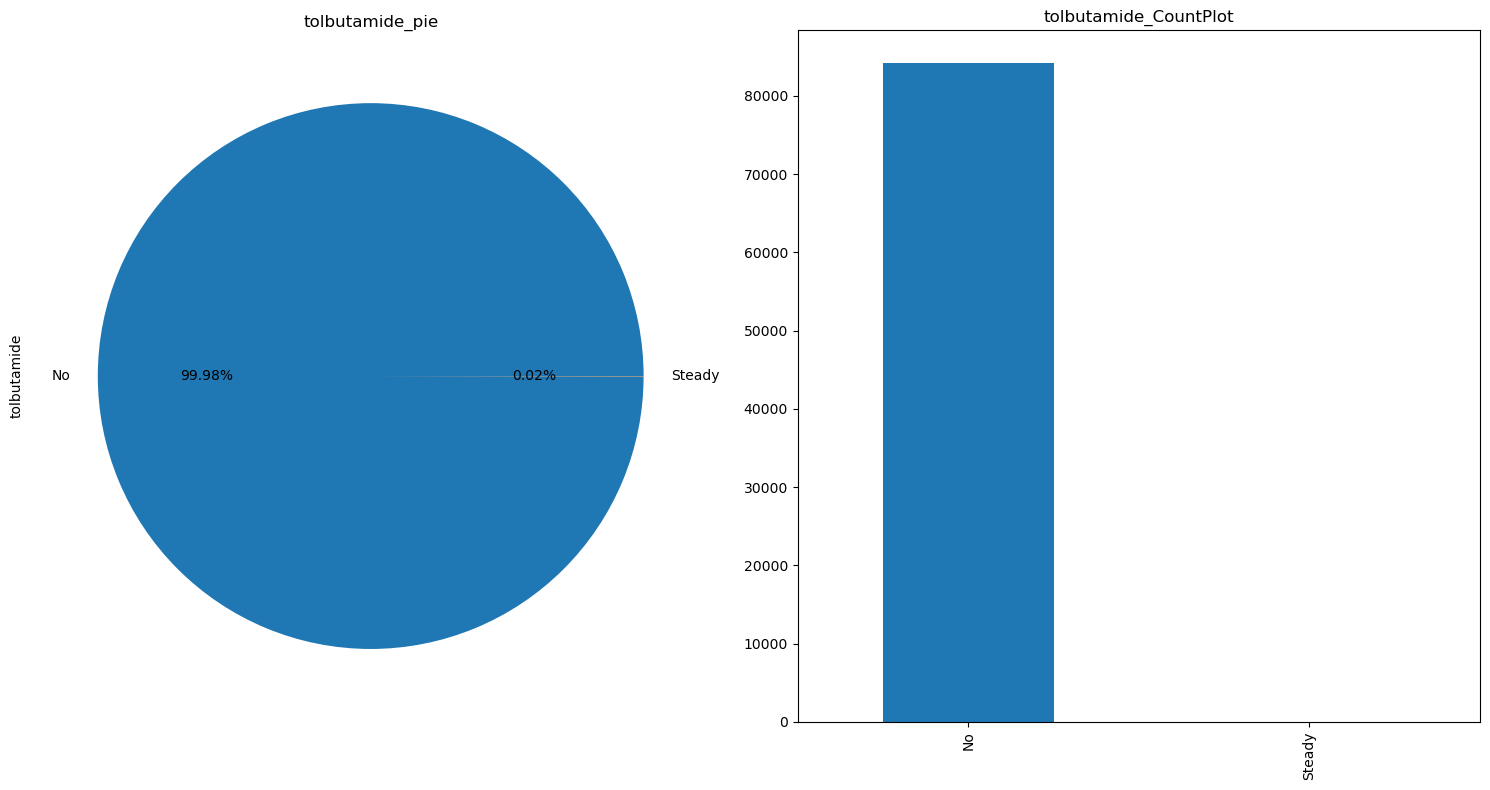

unique ['No' 'Steady']
mode 0    No
Name: tolbutamide, dtype: object
count of all sub categories No        84176
Steady       16
Name: tolbutamide, dtype: int64


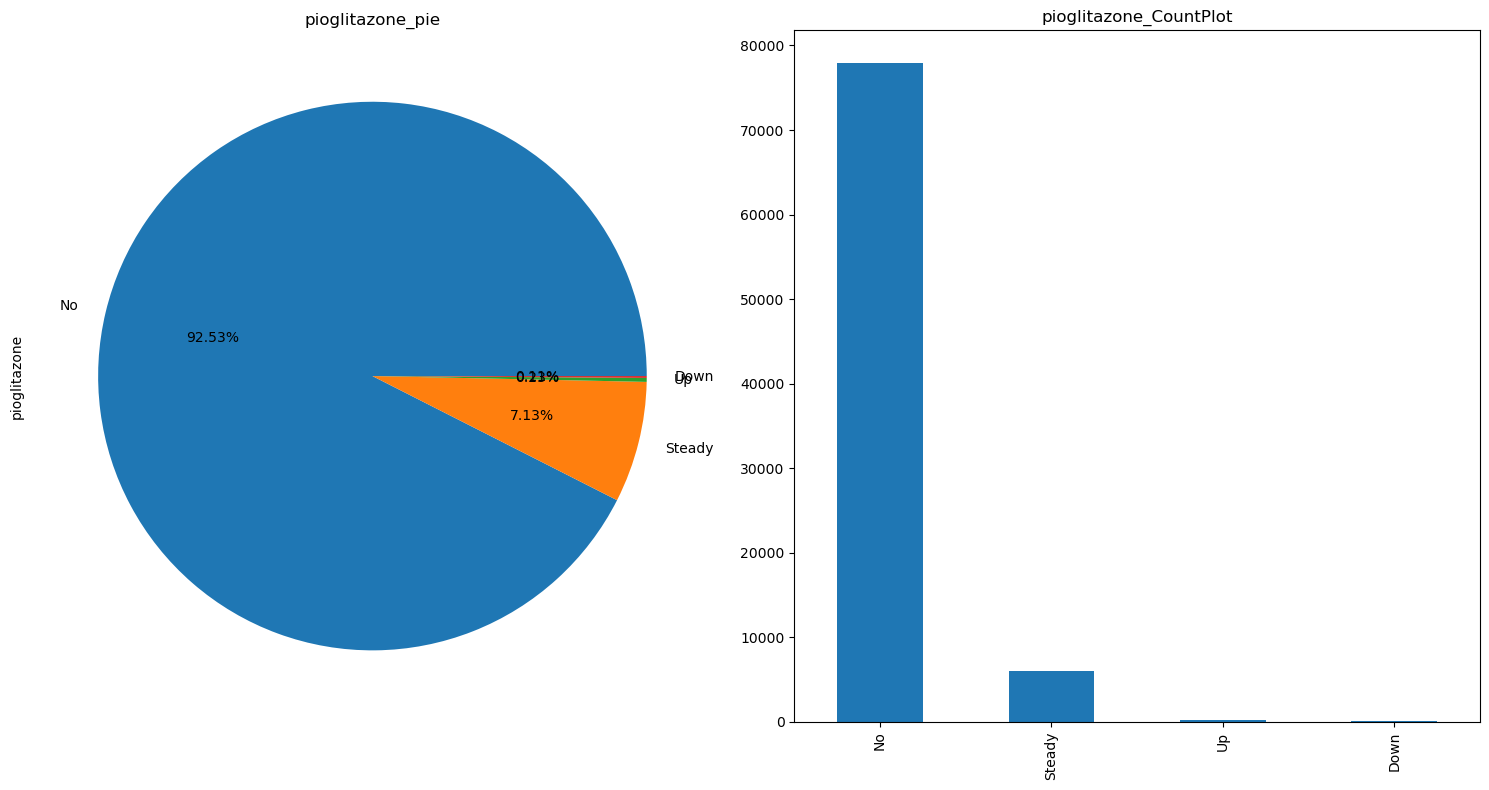

unique ['No' 'Up' 'Steady' 'Down']
mode 0    No
Name: pioglitazone, dtype: object
count of all sub categories No        77899
Steady     6007
Up          195
Down         91
Name: pioglitazone, dtype: int64


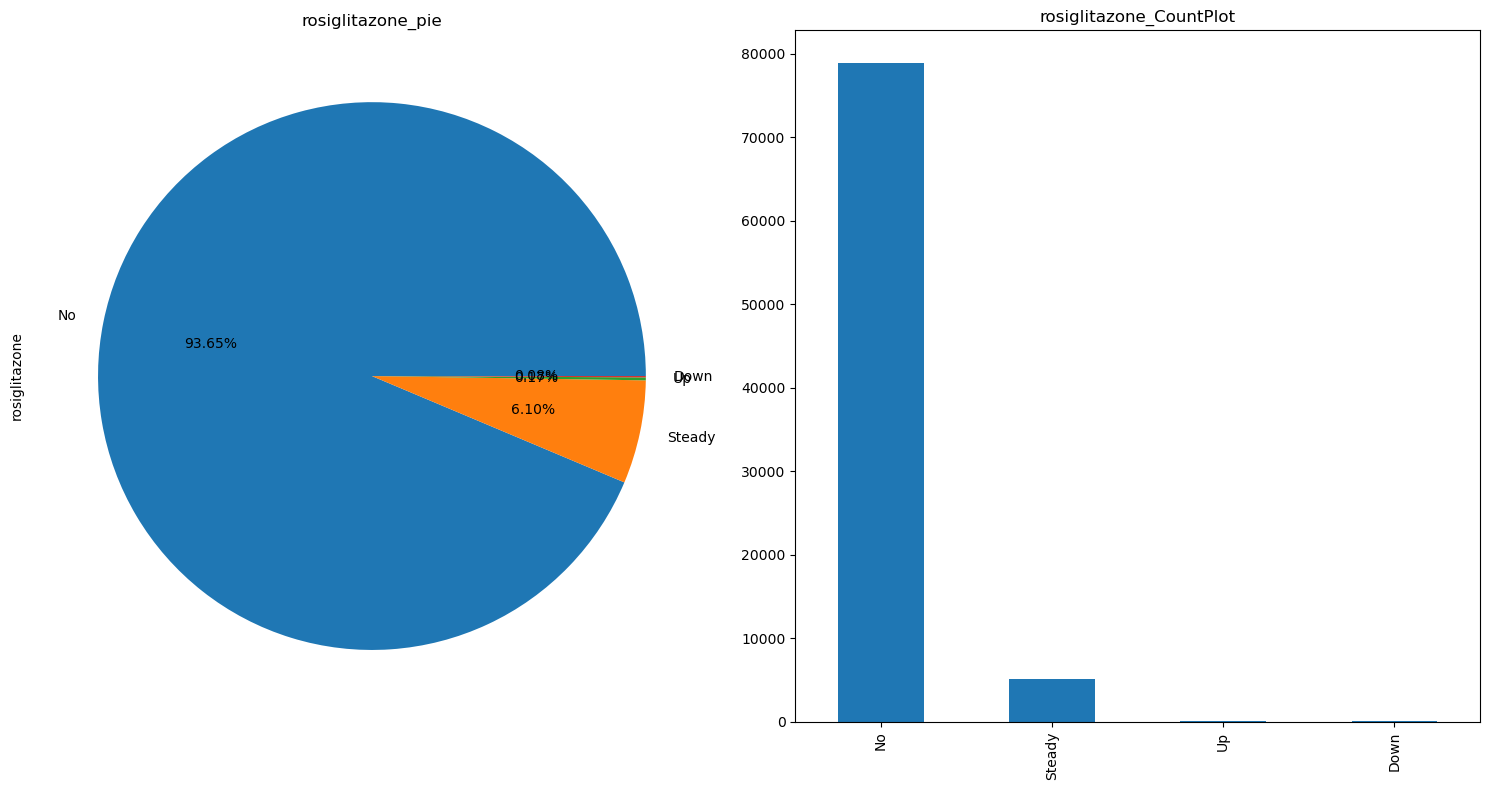

unique ['No' 'Steady' 'Up' 'Down']
mode 0    No
Name: rosiglitazone, dtype: object
count of all sub categories No        78849
Steady     5132
Up          146
Down         65
Name: rosiglitazone, dtype: int64


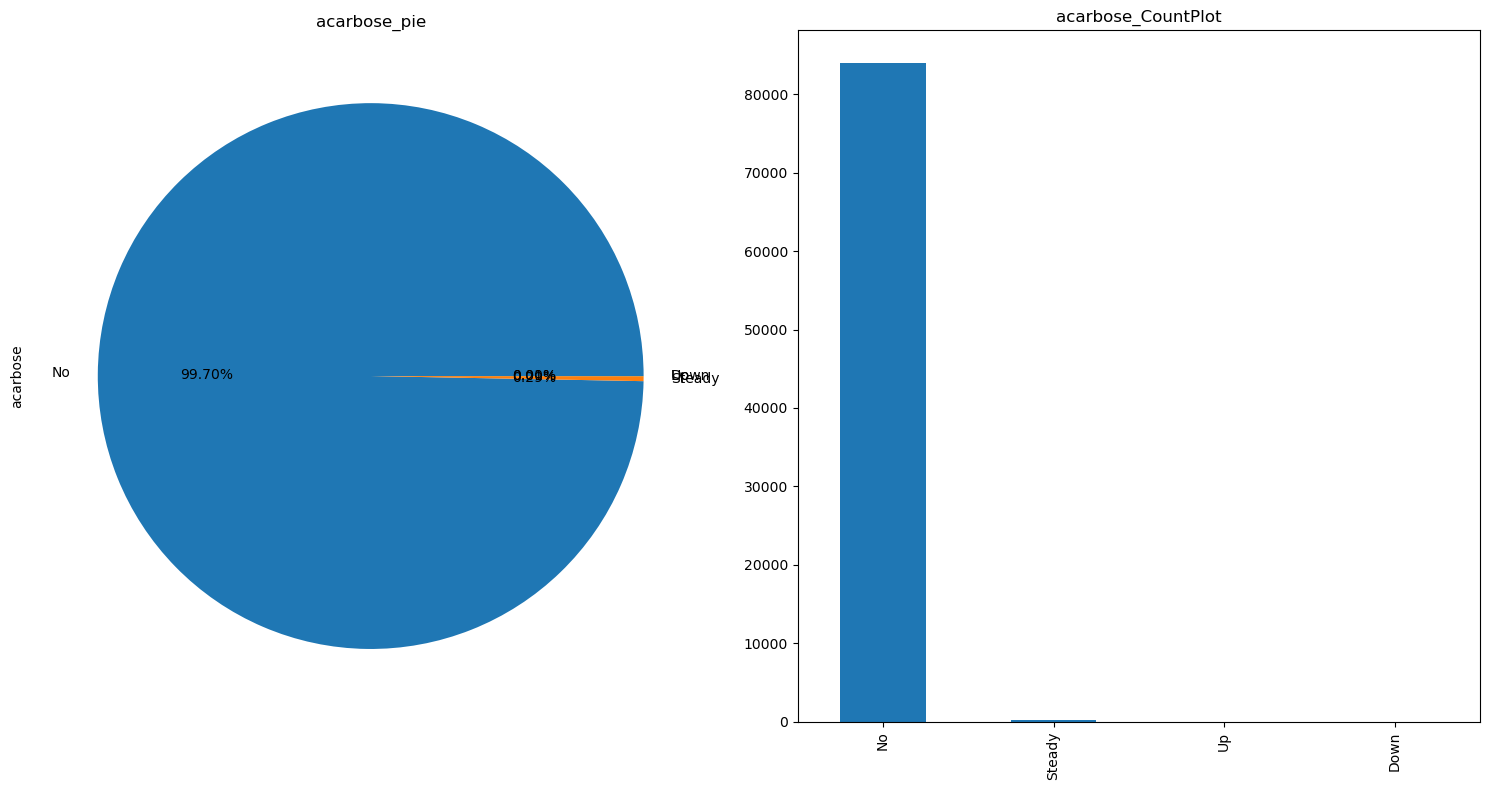

unique ['No' 'Steady' 'Up' 'Down']
mode 0    No
Name: acarbose, dtype: object
count of all sub categories No        83941
Steady      241
Up            7
Down          3
Name: acarbose, dtype: int64


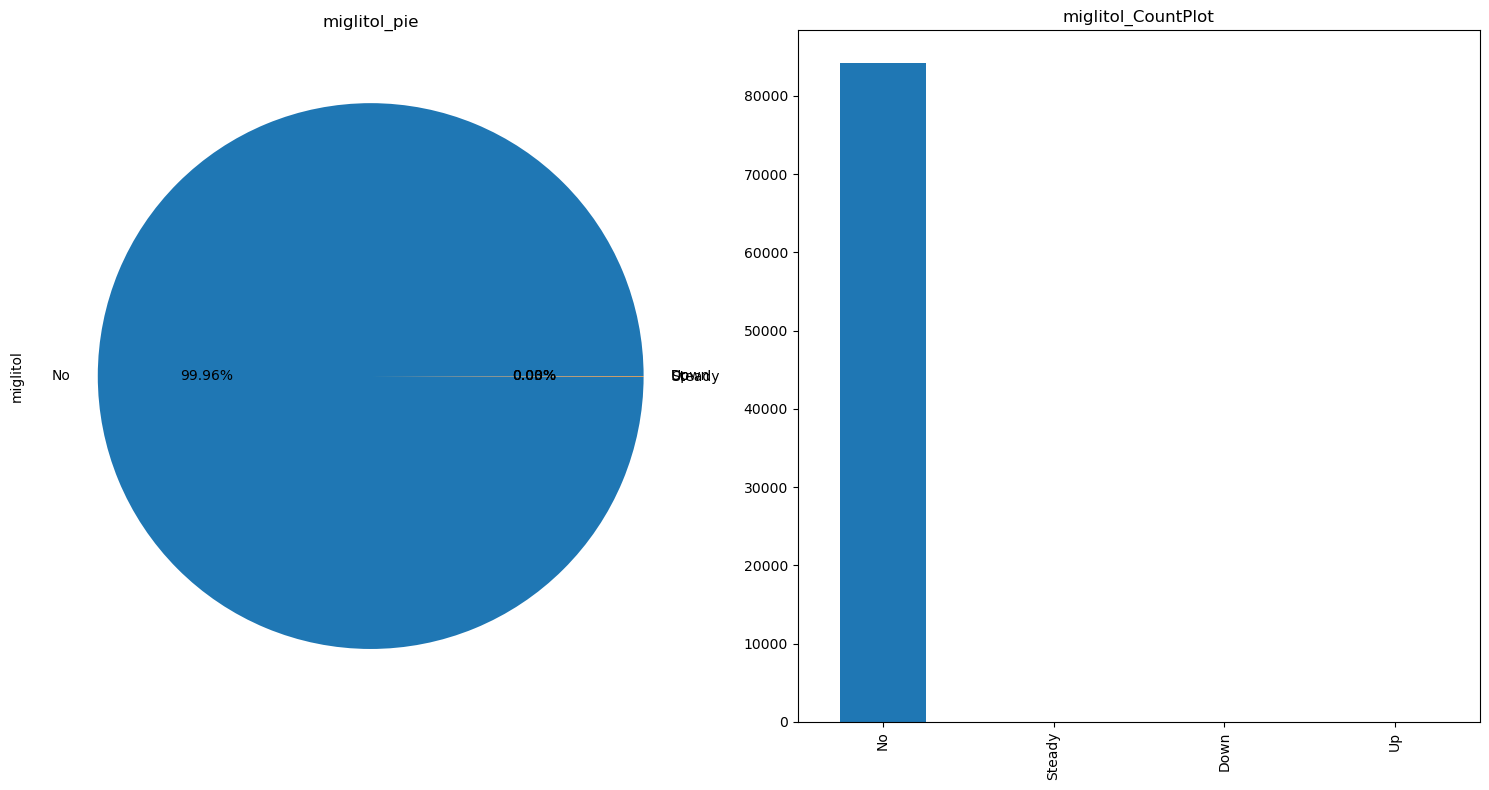

unique ['No' 'Steady' 'Down' 'Up']
mode 0    No
Name: miglitol, dtype: object
count of all sub categories No        84158
Steady       28
Down          4
Up            2
Name: miglitol, dtype: int64


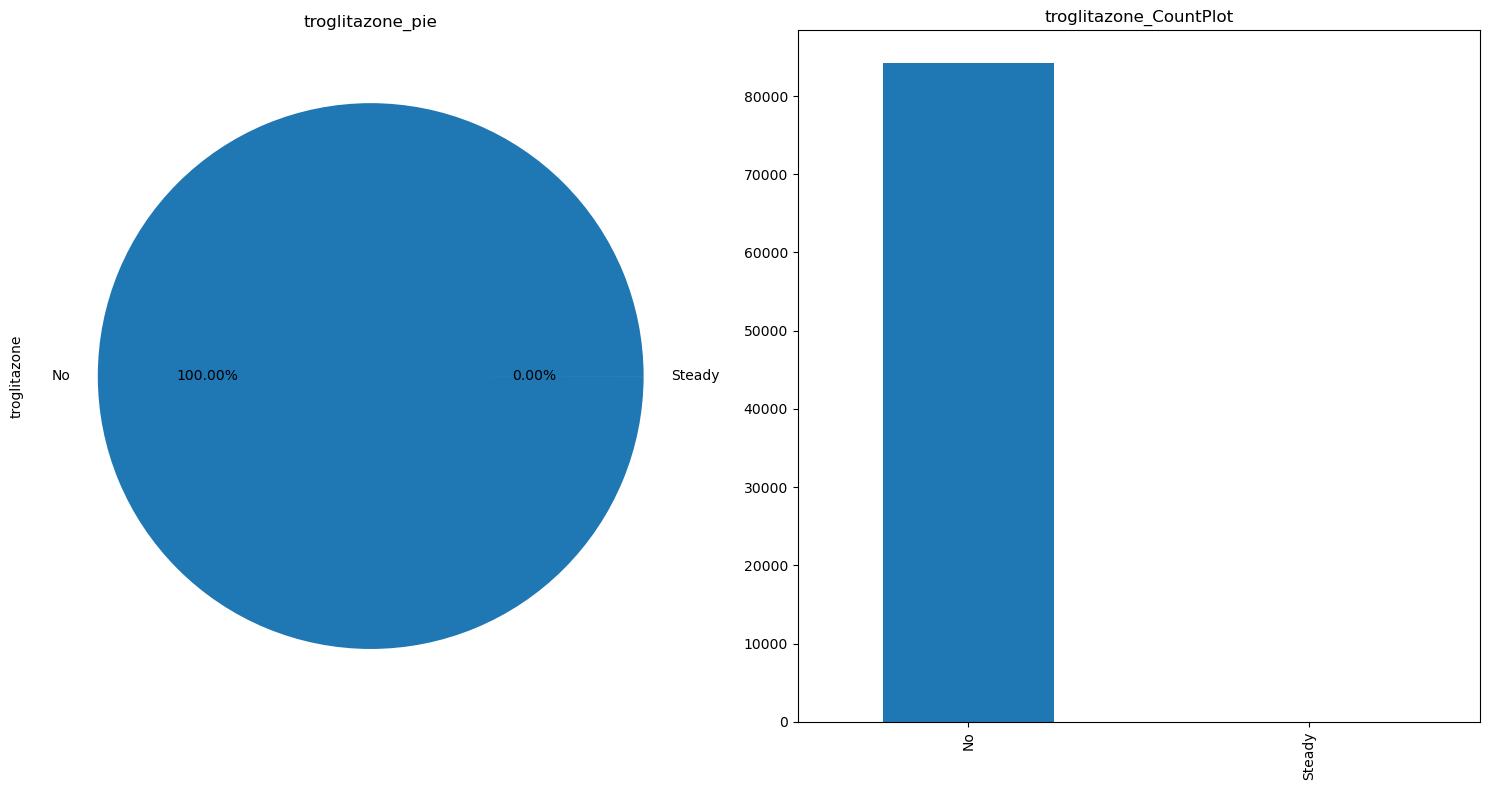

unique ['No' 'Steady']
mode 0    No
Name: troglitazone, dtype: object
count of all sub categories No        84190
Steady        2
Name: troglitazone, dtype: int64


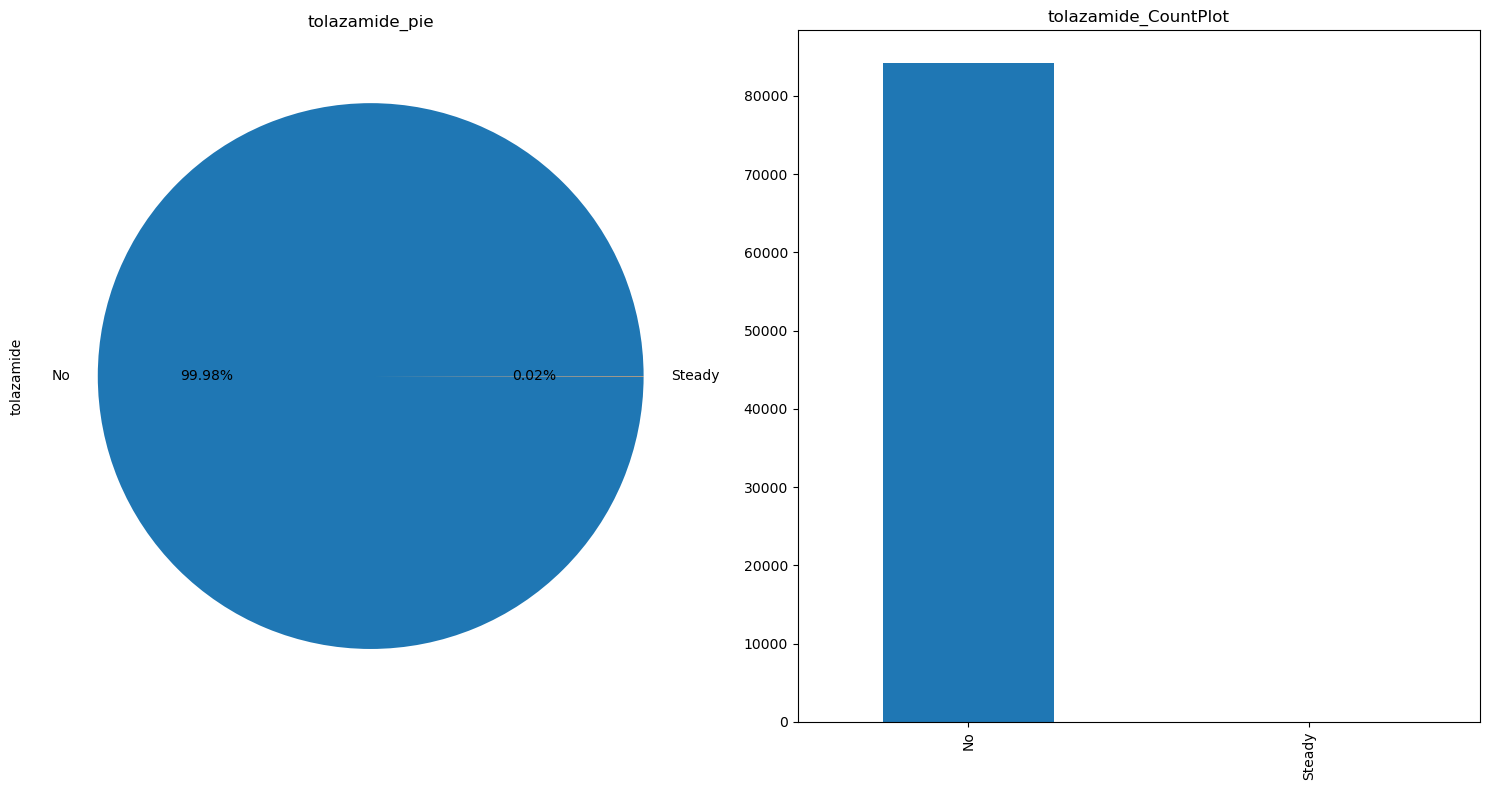

unique ['No' 'Steady']
mode 0    No
Name: tolazamide, dtype: object
count of all sub categories No        84173
Steady       19
Name: tolazamide, dtype: int64


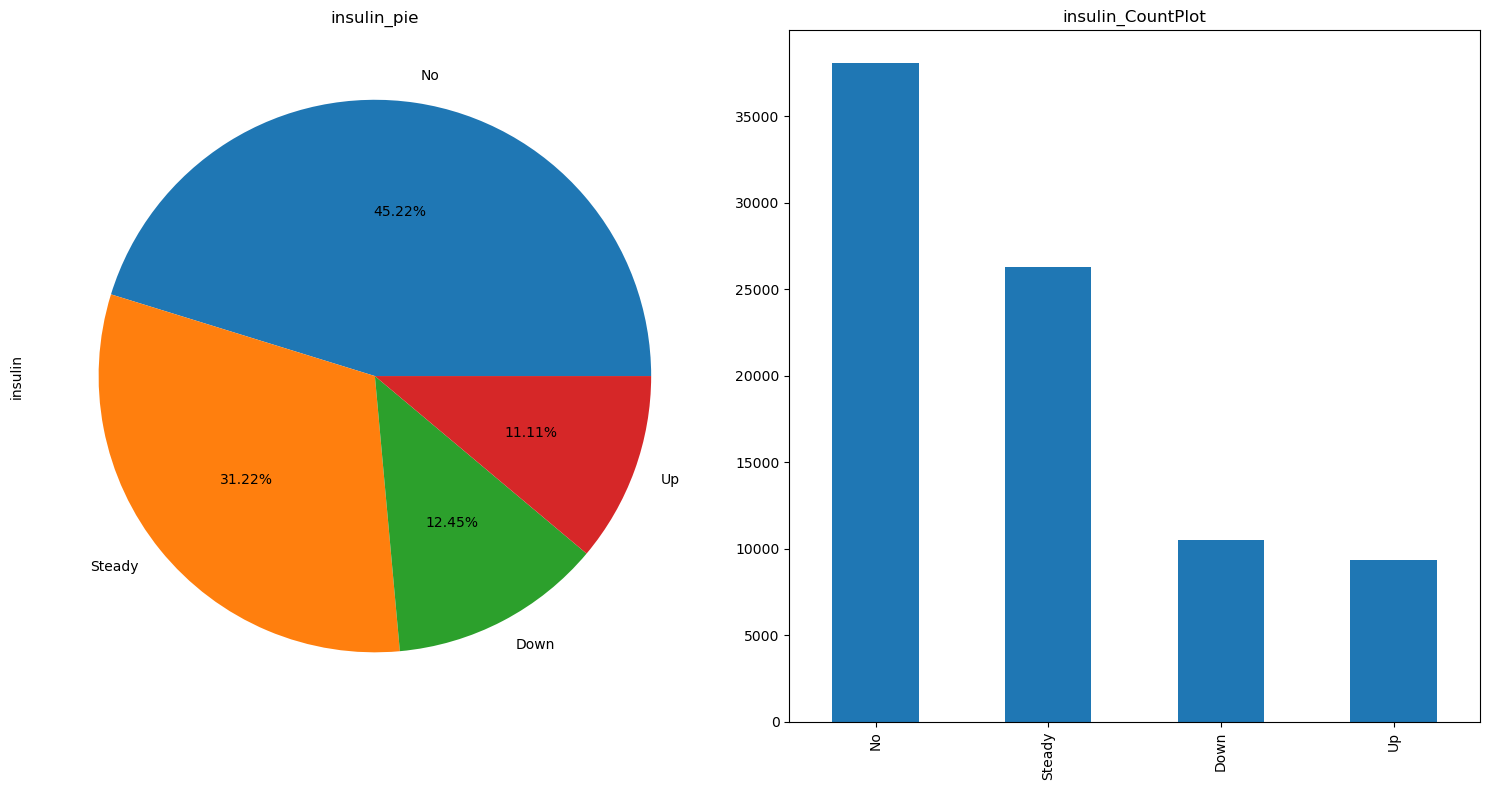

unique ['Up' 'No' 'Steady' 'Down']
mode 0    No
Name: insulin, dtype: object
count of all sub categories No        38073
Steady    26285
Down      10483
Up         9351
Name: insulin, dtype: int64


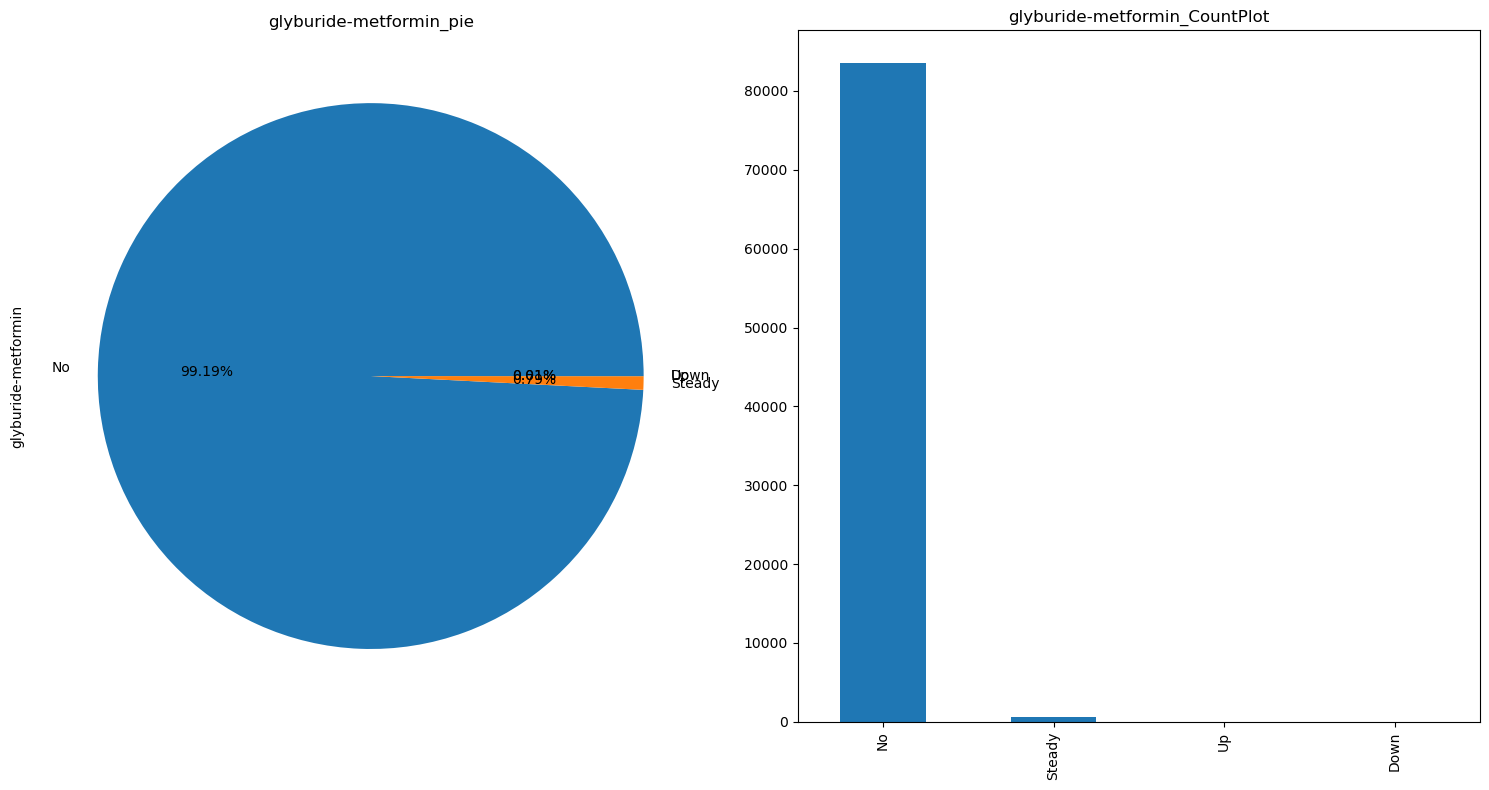

unique ['No' 'Steady' 'Down' 'Up']
mode 0    No
Name: glyburide-metformin, dtype: object
count of all sub categories No        83513
Steady      666
Up            7
Down          6
Name: glyburide-metformin, dtype: int64


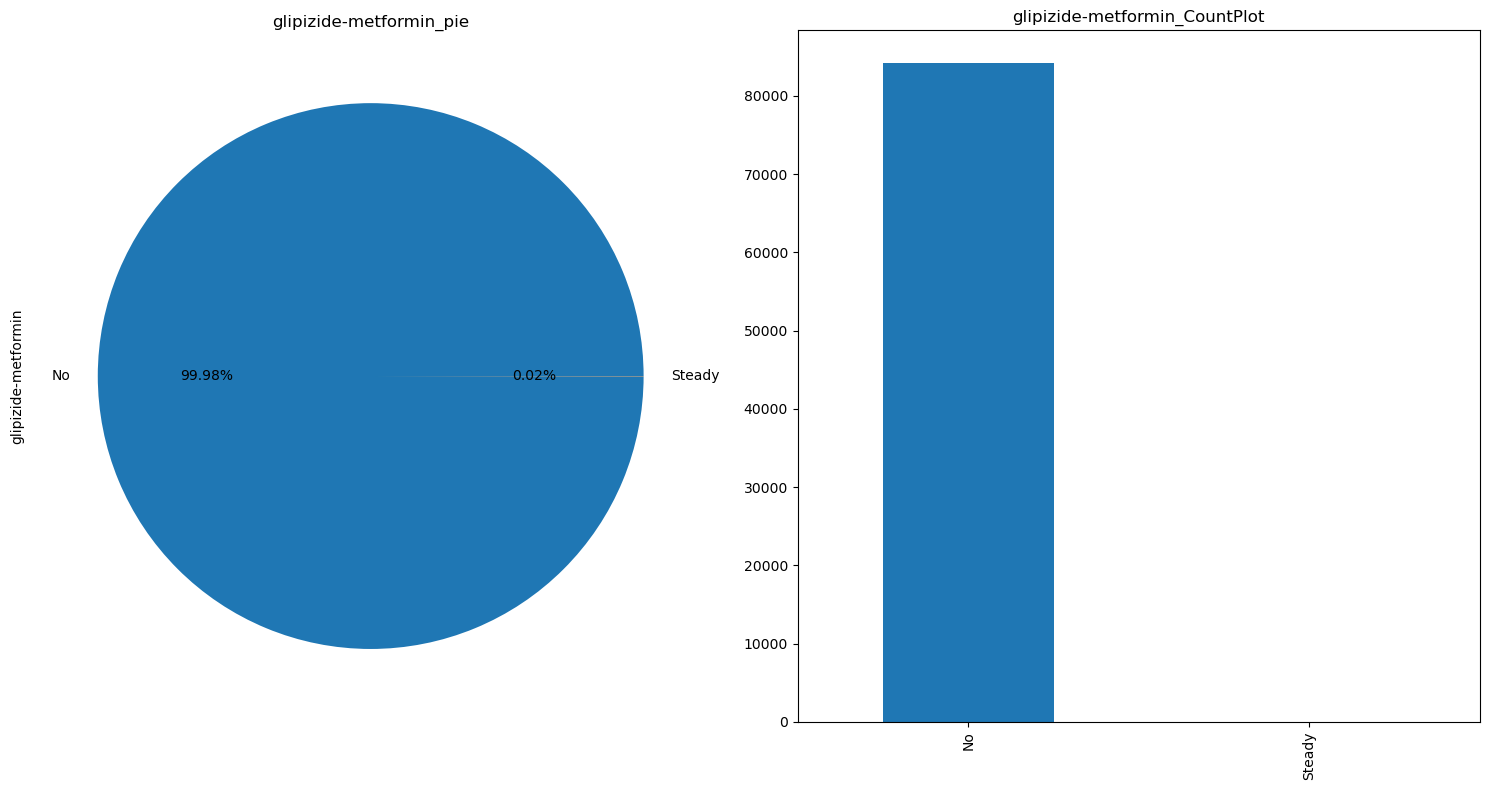

unique ['No' 'Steady']
mode 0    No
Name: glipizide-metformin, dtype: object
count of all sub categories No        84179
Steady       13
Name: glipizide-metformin, dtype: int64


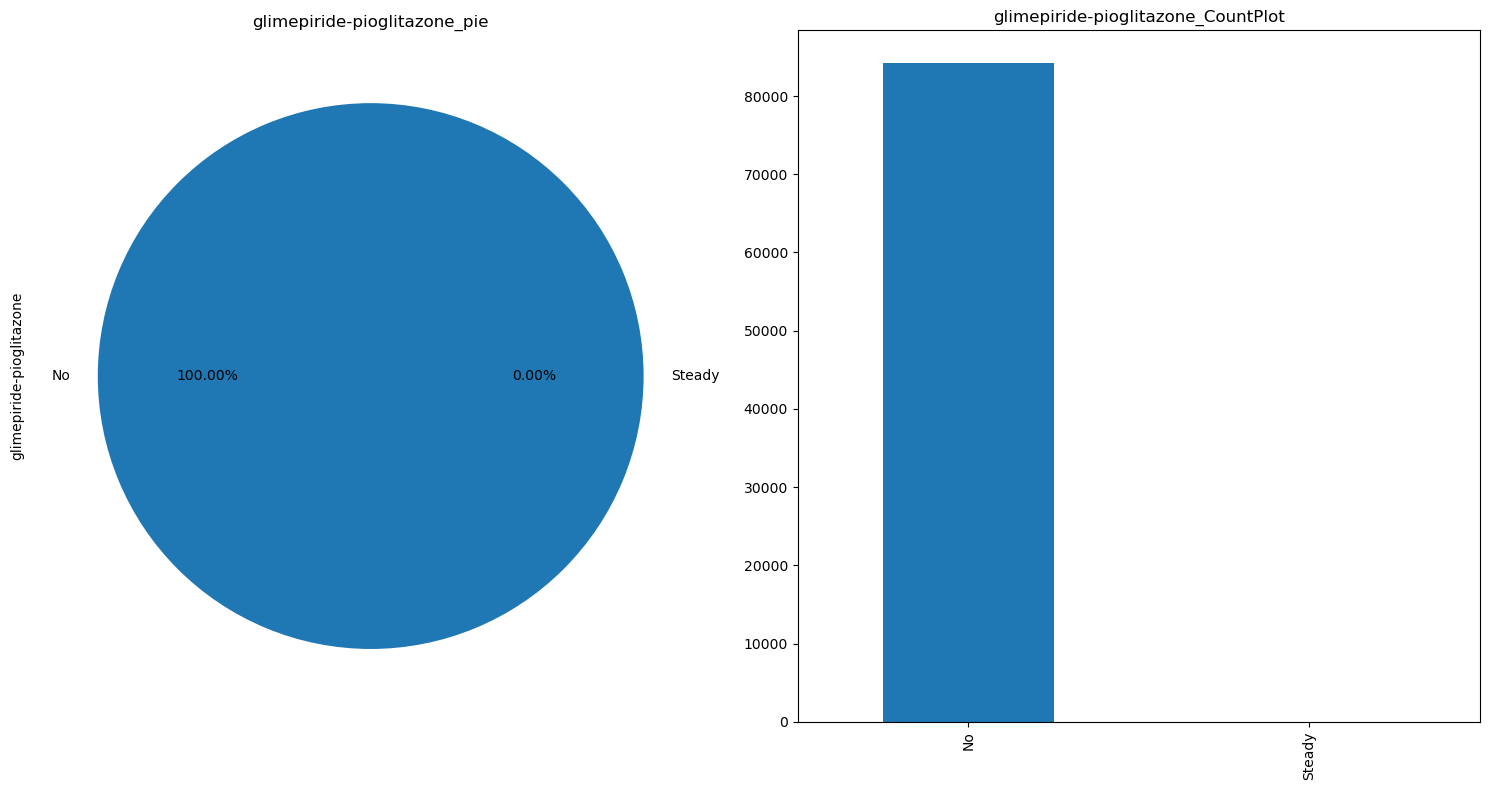

unique ['No' 'Steady']
mode 0    No
Name: glimepiride-pioglitazone, dtype: object
count of all sub categories No        84191
Steady        1
Name: glimepiride-pioglitazone, dtype: int64


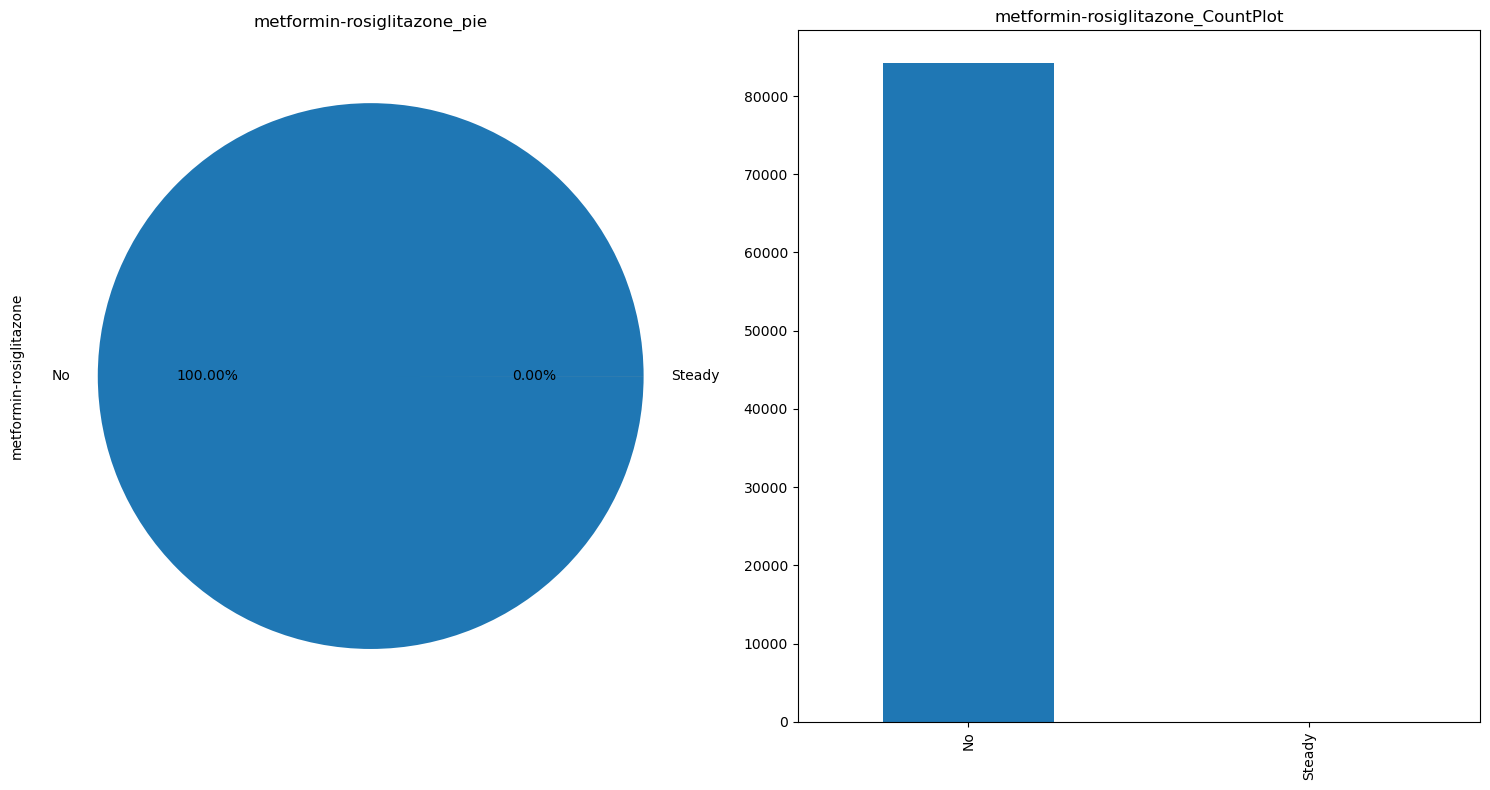

unique ['No' 'Steady']
mode 0    No
Name: metformin-rosiglitazone, dtype: object
count of all sub categories No        84190
Steady        2
Name: metformin-rosiglitazone, dtype: int64


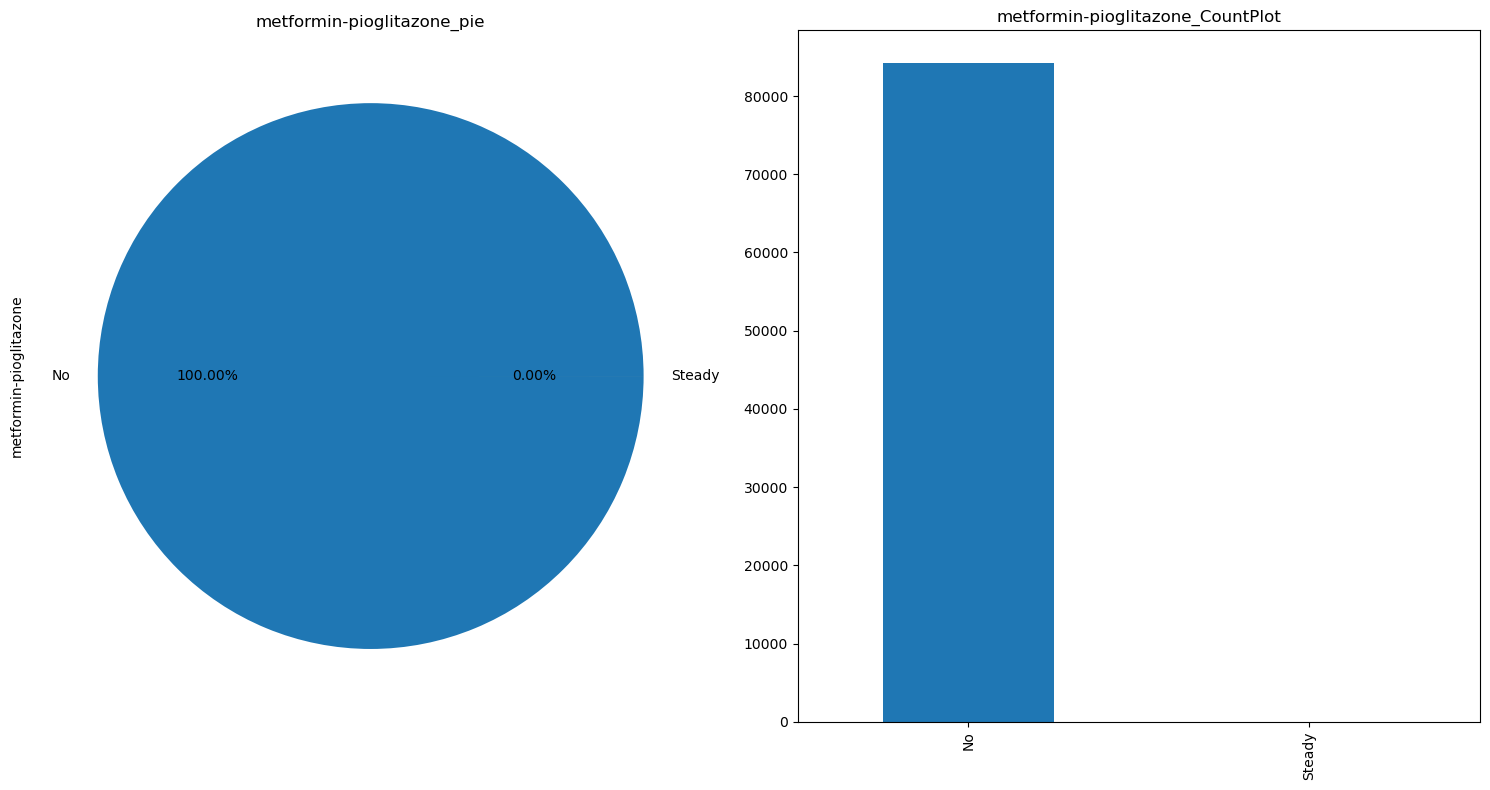

unique ['No' 'Steady']
mode 0    No
Name: metformin-pioglitazone, dtype: object
count of all sub categories No        84191
Steady        1
Name: metformin-pioglitazone, dtype: int64


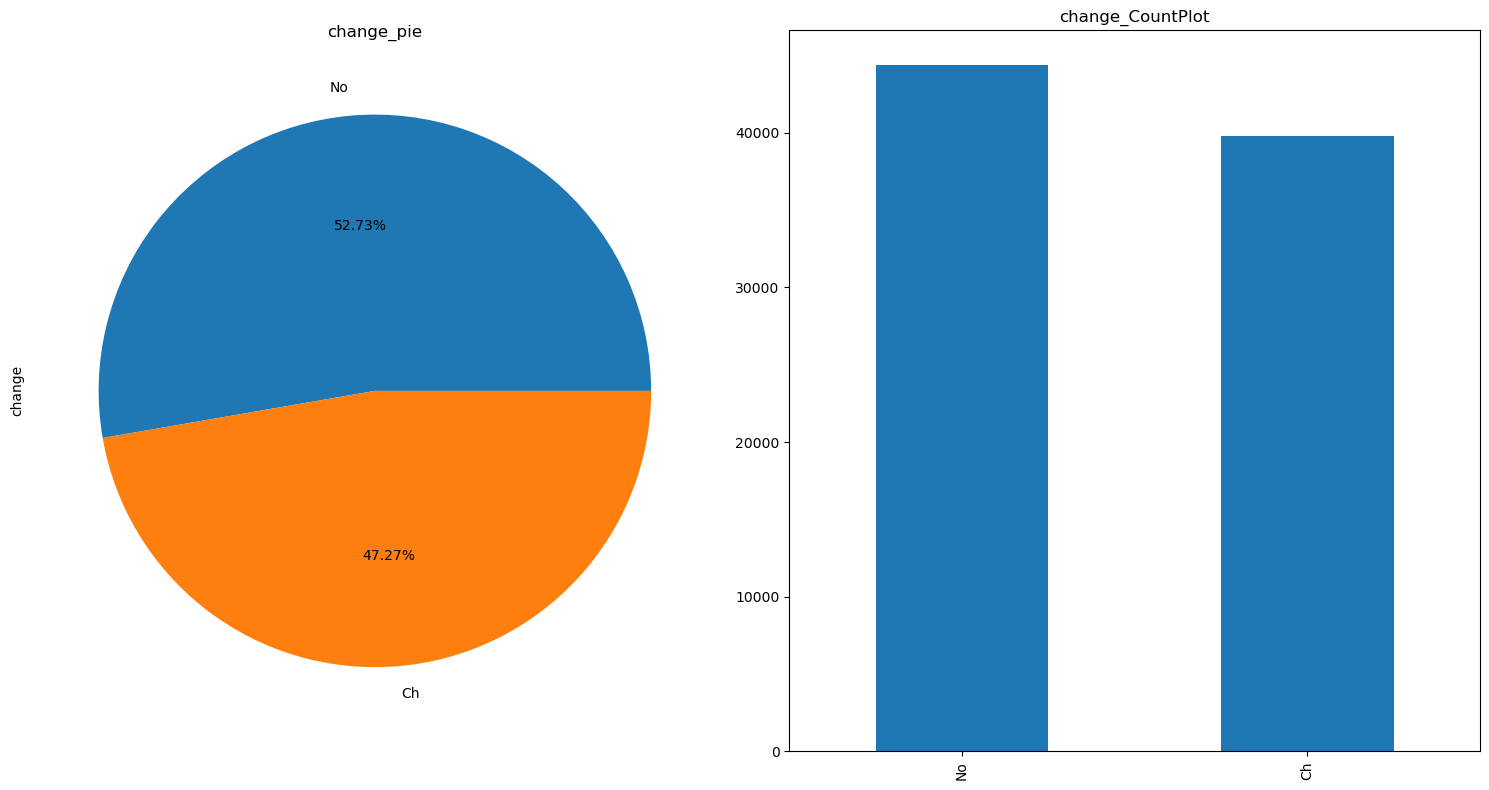

unique ['Ch' 'No']
mode 0    No
Name: change, dtype: object
count of all sub categories No    44392
Ch    39800
Name: change, dtype: int64


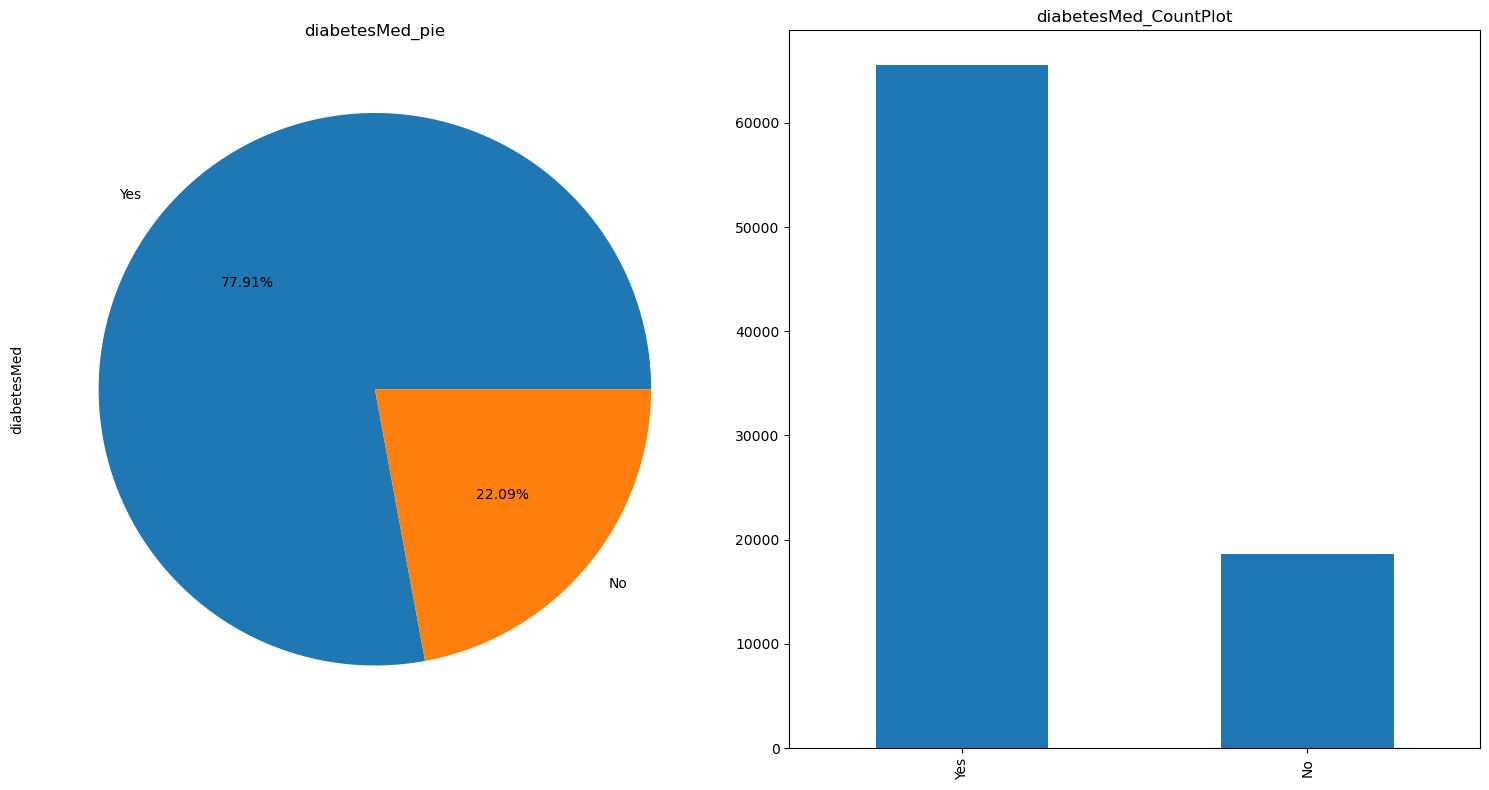

unique ['Yes' 'No']
mode 0    Yes
Name: diabetesMed, dtype: object
count of all sub categories Yes    65591
No     18601
Name: diabetesMed, dtype: int64


In [58]:
for i in cat:
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.title(i+'_pie')
    cat[i].value_counts().plot(kind='pie',autopct='%.2f%%')
    plt.subplot(1,2,2)
    plt.title(i+'_CountPlot')
    cat[i].value_counts().plot(kind='bar')
    plt.tight_layout()
    plt.show()
    print('unique',cat[i].unique())
    print('mode',cat[i].mode())
    print('count of all sub categories',cat[i].value_counts())

In [59]:
# BIVARIATE ANALYSIS

In [60]:
# plotting all the independent categorical variables with the target(readmitted)

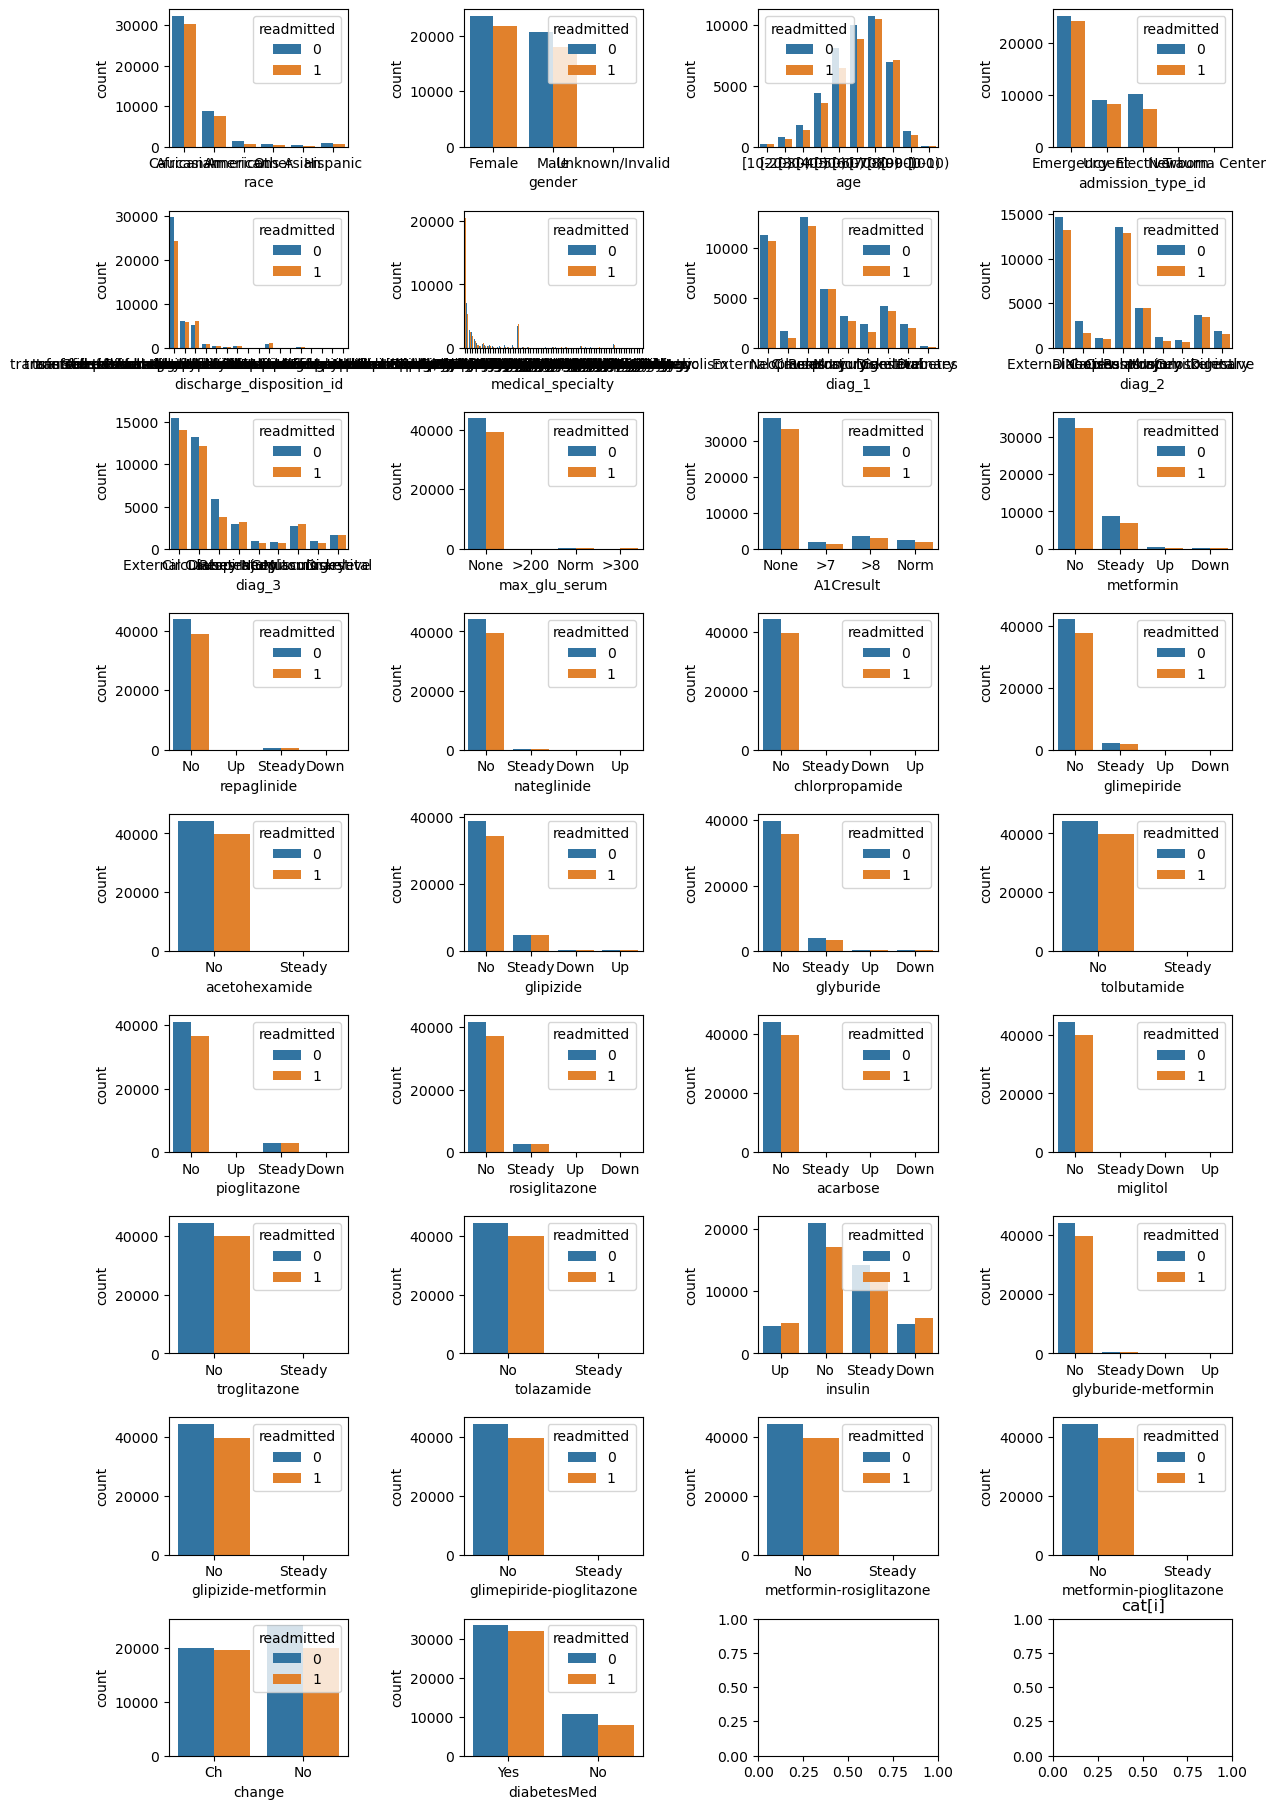

In [61]:
fig,ax=plt.subplots(9,4,figsize=(12,18))
for i,subplot in zip(cat,ax.flatten()):
    sns.countplot(hue=num['readmitted'],x=cat[i],ax=subplot)
    plt.title('cat[i]')
    plt.tight_layout()
    
plt.show()

In [62]:
# plotting all the independent numeric variables with the target(readmitted)

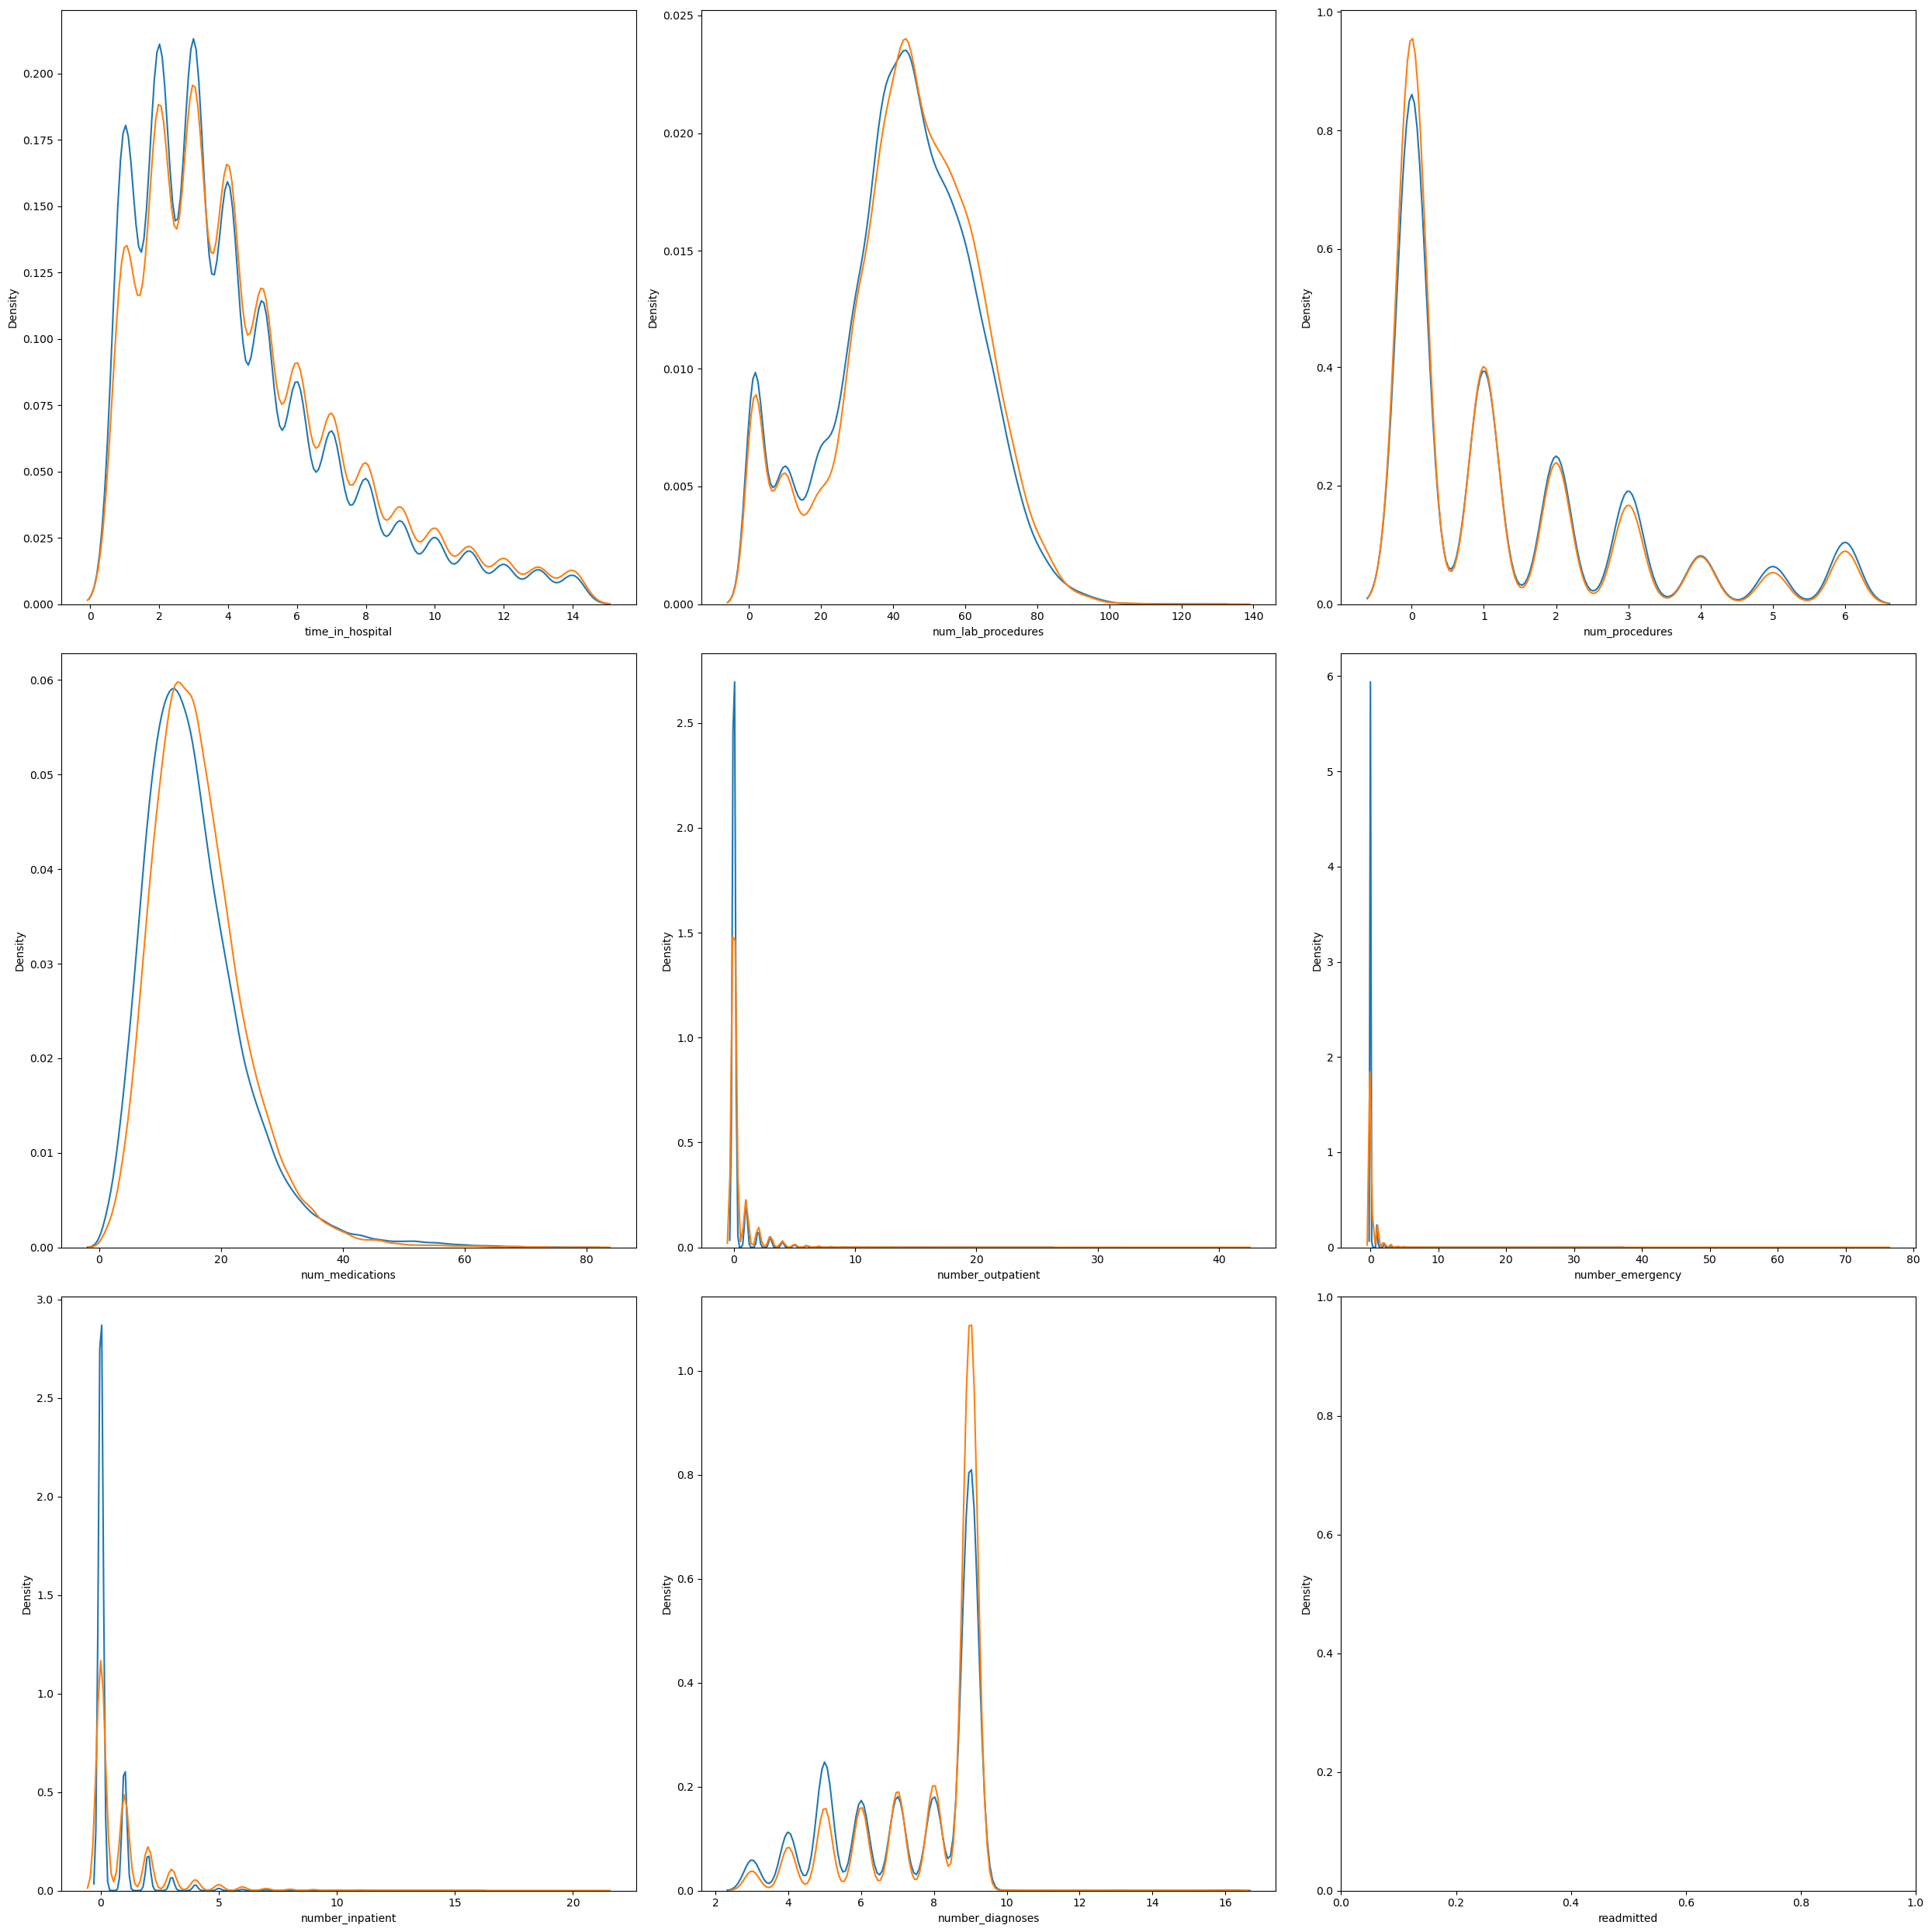

In [63]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(25,25))
j = 1
for i in num.columns:
    plt.subplot(3,3,j)
    sns.kdeplot(df1[df1['readmitted']==0][i])
    sns.kdeplot(df1[df1['readmitted']==1][i])
    j+=1
    plt.tight_layout()

In [64]:
# Examination and visualization of the effect of the target variable on insulin variable

In [65]:
cat['insulin'].value_counts()

No        38073
Steady    26285
Down      10483
Up         9351
Name: insulin, dtype: int64

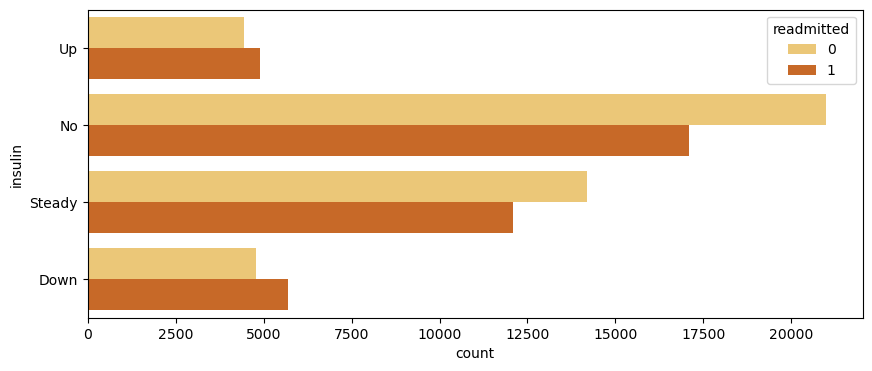

In [66]:
fig, ax =plt.subplots(figsize=(10,4))
sns.countplot(y=cat['insulin'], hue=num['readmitted'], palette="YlOrBr")
plt.show()

In [67]:
# Distribution of Diag_1, Diag_2 and Diag_3 Variables by Target Variable:

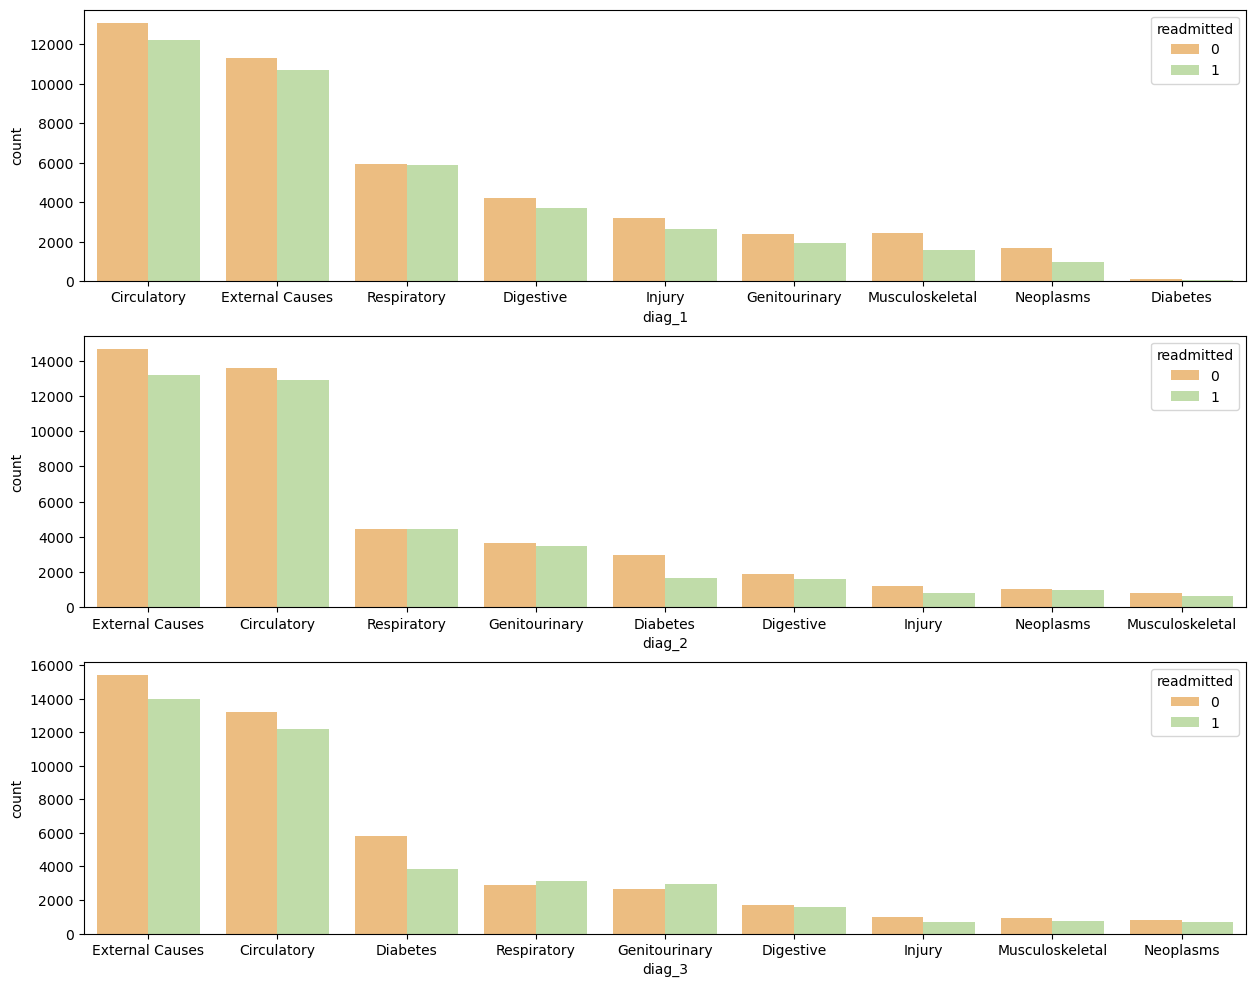

In [68]:
fig, ax =plt.subplots(nrows=3,ncols=1,figsize=(15,12))
count =0
for i in diag_list:
    sns.countplot(x=cat[i],hue=num['readmitted'], palette='Spectral', ax=ax[count], order = cat[i].value_counts().index);
    count = count+1

In [69]:
# Multivariate Analysis

<Axes: >

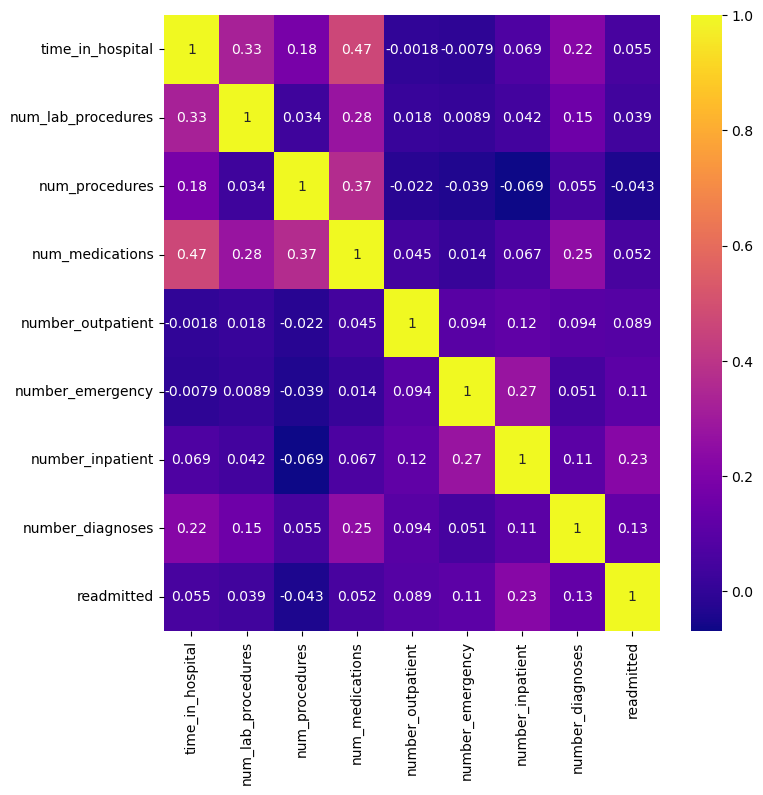

In [70]:
plt.figure(figsize=(8,8))
sns.heatmap(df1.corr(),annot=True,cmap='plasma')

# 5.Statistical tests

In [61]:
# CHI-SQUARE CONTIGENCY TEST

# The null and alternative hypothesis is:

# H0: diag_1 and readmitted are independent
# H1:  diag_1 and readmitted are not independent

In [62]:
from scipy.stats import chi2_contingency,chisquare
iv=[]
for i in df1.select_dtypes(include='object').columns:
    cs=pd.crosstab(df1[i],df1['readmitted'])
    p=chi2_contingency(cs)[1]
    if p>=0.05:
        iv.append(i)

In [63]:
iv

['nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glyburide',
 'tolbutamide',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone']

In [64]:
# statistical test for numerical data

In [65]:
iv_num=[]
from scipy.stats import jarque_bera
from scipy.stats import levene,ttest_ind,mannwhitneyu
for i in num.drop('readmitted',axis=1).columns:
    if jarque_bera(num[i])[1]<0.05:
        if levene(num[i],num['readmitted'])[1]<0.05:
            if ttest_ind(num[i],num['readmitted'])[1]>0.05:
                iv_num.append(i)
        else:
            if mannwhitneyu(num[i],num['readmitted'])[1]>=0.05:
                iv_num.append(i)
    else:
        if mannwhitneyu(num[i],num['readmitted'])[1]>=0.05:
            iv_num.append(i)

In [66]:
iv_num

[]

In [67]:
df1.drop(columns=iv,axis=1,inplace=True)

In [68]:
df1.shape

(84192, 29)

In [69]:
cat.columns


Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')

In [70]:
df1.drop('repaglinide',axis=1,inplace=True)

In [71]:
num.shape

(84192, 9)

In [72]:
df1.select_dtypes(include=np.number)

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1                      3                  59               0               18   
2                      2                  11               5               13   
3                      2                  44               1               16   
4                      1                  51               0                8   
5                      3                  31               6               16   
...                  ...                 ...             ...              ...   
101761                 3                  51               0               16   
101762                 5                  33               3               18   
101763                 1                  53               0                9   
101764                10                  45               2               21   
101765                 6                  13               3                3   

        number_outpatient  number_emergency  number_inpatient  \
1                       0                 0                 0   
2                       2                 0                 1   
3                       0                 0                 0   
4                       0                 0                 0   
5                       0                 0                 0   
...                   ...               ...               ...   
101761                  0                 0                 0   
101762                  0                 0                 1   
101763                  1                 0                 0   
101764                  0                 0                 1   
101765                  0                 0                 0   

        number_diagnoses  readmitted  
1                      9           1  
2                      6           0  
3                      7           0  
4                      5           0  
5                      9           1  
...                  ...         ...  
101761                 9           1  
101762                 9           0  
101763                13           0  
101764                 9           0  
101765                 9           0  

[84192 rows x 9 columns]

In [73]:
num.describe()

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count      84192.000000        84192.000000    84192.000000     84192.000000   
mean           4.385274           43.285051        1.337443        16.037023   
std            2.961396           19.406565        1.710203         8.069645   
min            1.000000            1.000000        0.000000         1.000000   
25%            2.000000           33.000000        0.000000        10.000000   
50%            4.000000           44.000000        1.000000        15.000000   
75%            6.000000           57.000000        2.000000        20.000000   
max           14.000000          132.000000        6.000000        81.000000   

       number_outpatient  number_emergency  number_inpatient  \
count       84192.000000      84192.000000      84192.000000   
mean            0.359155          0.208298          0.641427   
std             1.253120          0.982500          1.270488   
min             0.000000          0.000000          0.000000   
25%             0.000000          0.000000          0.000000   
50%             0.000000          0.000000          0.000000   
75%             0.000000          0.000000          1.000000   
max            42.000000         76.000000         21.000000   

       number_diagnoses    readmitted  
count      84192.000000  84192.000000  
mean           7.551276      0.472468  
std            1.833253      0.499244  
min            3.000000      0.000000  
25%            6.000000      0.000000  
50%            9.000000      0.000000  
75%            9.000000      1.000000  
max           16.000000      1.000000

In [74]:
# scaling

In [75]:
from sklearn.preprocessing import StandardScaler

ss=StandardScaler()
for i in num.drop('readmitted',axis=1):
    num[i]=ss.fit_transform(num[[i]])

In [76]:
num

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1              -0.467780            0.809780       -0.782042         0.243256   
2              -0.805461           -1.663625        2.141605        -0.376354   
3              -0.805461            0.036841       -0.197313        -0.004588   
4              -1.143141            0.397546       -0.782042        -0.995963   
5              -0.467780           -0.633040        2.726335        -0.004588   
...                  ...                 ...             ...              ...   
101761         -0.467780            0.397546       -0.782042        -0.004588   
101762          0.207581           -0.529981        0.972146         0.243256   
101763         -1.143141            0.500604       -0.782042        -0.872041   
101764          1.895984            0.088370        0.387417         0.615022   
101765          0.545262           -1.560566        0.972146        -1.615573   

        number_outpatient  number_emergency  number_inpatient  \
1               -0.286611         -0.212009         -0.504869   
2                1.309416         -0.212009          0.282234   
3               -0.286611         -0.212009         -0.504869   
4               -0.286611         -0.212009         -0.504869   
5               -0.286611         -0.212009         -0.504869   
...                   ...               ...               ...   
101761          -0.286611         -0.212009         -0.504869   
101762          -0.286611         -0.212009          0.282234   
101763           0.511403         -0.212009         -0.504869   
101764          -0.286611         -0.212009          0.282234   
101765          -0.286611         -0.212009         -0.504869   

        number_diagnoses  readmitted  
1               0.790252           1  
2              -0.846192           0  
3              -0.300711           0  
4              -1.391674           0  
5               0.790252           1  
...                  ...         ...  
101761          0.790252           1  
101762          0.790252           0  
101763          2.972179           0  
101764          0.790252           0  
101765          0.790252           0  

[84192 rows x 9 columns]

In [77]:
# transformation

In [78]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer()
for i in num.drop('readmitted',axis=1):
    num[i]=pt.fit_transform(num[[i]])

In [79]:
df1_num=num

In [80]:
df1_num

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1              -0.327548            0.801524       -0.980795         0.451823   
2              -0.891777           -1.570822        1.646414        -0.249084   
3              -0.891777           -0.031844        0.192272         0.199028   
4              -1.550041            0.345813       -0.980795        -1.166469   
5              -0.327548           -0.674983        1.793685         0.199028   
...                  ...                 ...             ...              ...   
101761         -0.327548            0.345813       -0.980795         0.199028   
101762          0.505774           -0.580055        1.208110         0.451823   
101763         -1.550041            0.457538       -0.980795        -0.967213   
101764          1.597767            0.020715        0.838232         0.780199   
101765          0.796529           -1.484811        1.208110        -2.271252   

        number_outpatient  number_emergency  number_inpatient  \
1               -0.436016         -0.361883         -0.704242   
2                2.329453         -0.361883          1.154105   
3               -0.436016         -0.361883         -0.704242   
4               -0.436016         -0.361883         -0.704242   
5               -0.436016         -0.361883         -0.704242   
...                   ...               ...               ...   
101761          -0.436016         -0.361883         -0.704242   
101762          -0.436016         -0.361883          1.154105   
101763           2.253303         -0.361883         -0.704242   
101764          -0.436016         -0.361883          1.154105   
101765          -0.436016         -0.361883         -0.704242   

        number_diagnoses  readmitted  
1               0.826405           1  
2              -0.992732           0  
3              -0.563614           0  
4              -1.337067           0  
5               0.826405           1  
...                  ...         ...  
101761          0.826405           1  
101762          0.826405           0  
101763          5.941276           0  
101764          0.826405           0  
101765          0.826405           0  

[84192 rows x 9 columns]

In [81]:
df1_cat=df1.select_dtypes(include='object')

In [82]:
df1_cat.shape

(84192, 19)

In [83]:
df1_cat.head()

race  gender      age admission_type_id  \
1        Caucasian  Female  [10-20)         Emergency   
2  AfricanAmerican  Female  [20-30)         Emergency   
3        Caucasian    Male  [30-40)         Emergency   
4        Caucasian    Male  [40-50)         Emergency   
5        Caucasian    Male  [50-60)            Urgent   

  discharge_disposition_id medical_specialty           diag_1  \
1       Discharged to home            Others  External Causes   
2       Discharged to home            Others  External Causes   
3       Discharged to home            Others  External Causes   
4       Discharged to home            Others        Neoplasms   
5       Discharged to home            Others      Circulatory   

            diag_2           diag_3 max_glu_serum A1Cresult metformin  \
1  External Causes  External Causes          None      None        No   
2         Diabetes  External Causes          None      None        No   
3  External Causes      Circulatory          None      None        No   
4        Neoplasms         Diabetes          None      None        No   
5      Circulatory         Diabetes          None      None        No   

  glipizide pioglitazone rosiglitazone acarbose insulin change diabetesMed  
1        No           No            No       No      Up     Ch         Yes  
2    Steady           No            No       No      No     No         Yes  
3        No           No            No       No      Up     Ch         Yes  
4    Steady           No            No       No  Steady     Ch         Yes  
5        No           No            No       No  Steady     No         Yes

In [84]:
# encoding categorical columns

In [85]:
from sklearn.preprocessing import OrdinalEncoder

oe=OrdinalEncoder(categories=[['Others', 'InternalMedicine', 'Family/GeneralPractice',
       'Cardiology', 'Surgery-General', 'Orthopedics', 'Gastroenterology',
       'Nephrology', 'Psychiatry', 'Orthopedics-Reconstructive',
       'Pulmonology', 'Surgery-Neuro',
       'Obsterics&Gynecology-GynecologicOnco', 'Pediatrics-CriticalCare',
       'Endocrinology', 'Urology', 'Radiology',
       'Pediatrics-Endocrinology', 'ObstetricsandGynecology',
       'Pediatrics', 'Pediatrics-Hematology-Oncology',
       'Surgery-Cardiovascular/Thoracic', 'Anesthesiology-Pediatric',
       'Emergency/Trauma', 'Psychology', 'Neurology',
       'Hematology/Oncology', 'Psychiatry-Child/Adolescent',
       'Surgery-Colon&Rectal', 'Podiatry', 'Pediatrics-Pulmonology',
       'Gynecology', 'Oncology', 'Pediatrics-Neurology',
       'Surgery-Plastic', 'Surgery-Thoracic',
       'Surgery-PlasticwithinHeadandNeck', 'Ophthalmology',
       'Surgery-Pediatric', 'Pediatrics-EmergencyMedicine',
       'PhysicalMedicineandRehabilitation', 'Otolaryngology',
       'InfectiousDiseases', 'Anesthesiology', 'AllergyandImmunology',
       'Surgery-Maxillofacial', 'Pediatrics-InfectiousDiseases',
       'Pediatrics-AllergyandImmunology', 'Dentistry', 'Surgeon',
       'Surgery-Vascular', 'Osteopath', 'Psychiatry-Addictive',
       'Surgery-Cardiovascular', 'PhysicianNotFound', 'Hematology',
       'Proctology', 'Rheumatology', 'Obstetrics', 'SurgicalSpecialty',
       'Radiologist', 'Pathology', 'Dermatology', 'SportsMedicine',
       'Speech', 'Hospitalist', 'OutreachServices',
       'Cardiology-Pediatric', 'Perinatology', 'Neurophysiology',
       'Endocrinology-Metabolism', 'DCPTEAM', 'Resident']])
df1_cat['medical_specialty']=oe.fit_transform(df1_cat[['medical_specialty']])

In [86]:
df1_cat['medical_specialty'].value_counts()

0.0     41138
1.0     12484
23.0     7325
2.0      5310
3.0      4289
        ...  
44.0        1
68.0        1
69.0        1
46.0        1
52.0        1
Name: medical_specialty, Length: 71, dtype: int64

In [87]:
df1_cat['medical_specialty']=df1_cat['medical_specialty'].replace({0:73})

In [88]:
df1_cat['age']=df1_cat['age'].replace({'[0-10)':0,'[10-20)':10,'[20-30)':20,'[30-40)':30,'[40-50)':40,'[50-60)':50,'[60-70)':60,'[70-80)':70,'[80-90)':80,'[90-100)':90})

In [89]:
df1_cat['age'].value_counts()

70    21286
60    18939
50    14555
80    14152
40     8027
30     3129
90     2251
20     1358
10      436
0        59
Name: age, dtype: int64

In [90]:
oe=OrdinalEncoder(categories=[[0,10,20,30,40,50,60,70,80,90]])
df1_cat['age']=oe.fit_transform(df1_cat[['age']])

In [91]:
df1_cat['age'].value_counts()

7.0    21286
6.0    18939
5.0    14555
8.0    14152
4.0     8027
3.0     3129
9.0     2251
2.0     1358
1.0      436
0.0       59
Name: age, dtype: int64

In [92]:
df1_cat['age']=df1_cat['age'].replace({0:10})

In [93]:
df1_cat['admission_type_id'].value_counts()

Emergency        49485
Elective         17383
Urgent           17296
Trauma Center       18
Newborn             10
Name: admission_type_id, dtype: int64

In [94]:
oe=OrdinalEncoder(categories=[['Trauma Center', 'Elective', 'Urgent','Newborn','Emergency']])
df1_cat['admission_type_id']=oe.fit_transform(df1_cat[['admission_type_id']])

In [95]:
df1_cat['admission_type_id'].value_counts()

4.0    49485
1.0    17383
2.0    17296
0.0       18
3.0       10
Name: admission_type_id, dtype: int64

In [96]:
df1_cat['admission_type_id']=df1_cat['admission_type_id'].replace({0:5})

In [97]:
# The expected values for normal fasting blood glucose concentration are 
# between 70 mg/dL (3.9 mmol/L) and 100 mg/dL (5.6 mmol/L). 


# If you had a random blood glucose test, a normal result depends on when you last ate. Most of the time, 
# the blood glucose level will be 125 mg/dL (6.9 mmol/L) or lower.
# >200=diabetic
# >300=severe

df1_cat['max_glu_serum'].value_counts()

None    83157
Norm      497
>300      361
>200      177
Name: max_glu_serum, dtype: int64

In [98]:
oe=OrdinalEncoder(categories=[['None','Norm','>200','>300']])
df1_cat['max_glu_serum']=oe.fit_transform(df1_cat[['max_glu_serum']])

In [99]:
df1_cat['max_glu_serum']=df1_cat['max_glu_serum'].replace({0:4})

In [100]:
#A normal A1C level is below 5.7%, 
# a level of 5.7% to 6.4% indicates prediabetes, 
# and a level of 6.5% or more indicates diabetes. Within the 5.7% to 6.4% prediabetes range, 
# the higher your A1C, the greater your risk is for developing type 2 diabetes.

# >7=diabetic
# >8=severe

df1_cat['A1Cresult'].value_counts()

None    69905
>8       6607
Norm     4423
>7       3257
Name: A1Cresult, dtype: int64

In [101]:
oe=OrdinalEncoder(categories=[['None','Norm','>7','>8']])
df1_cat['A1Cresult']=oe.fit_transform(df1_cat[['A1Cresult']])

In [102]:
df1_cat['A1Cresult']=df1_cat['A1Cresult'].replace({0:4})

In [103]:
# the feature indicates whether the drug was prescribed or there was a change in the dosage. 
# Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, 
# “steady” if the dosage did not change, and “no” if the drug was not prescribed

df1_cat['metformin'].value_counts()

No        67267
Steady    15572
Up          880
Down        473
Name: metformin, dtype: int64

In [104]:
oe=OrdinalEncoder(categories=[['No', 'Steady', 'Down','Up']])
df1_cat['metformin']=oe.fit_transform(df1_cat[['metformin']])

In [105]:
df1_cat['metformin']=df1_cat['metformin'].replace({0:4})

In [106]:
# Glipizide is used along with diet and exercise, and sometimes with other medications, 
# to treat type 2 diabetes (condition in which the body does not use insulin normally and, 
# therefore, cannot control the amount of sugar in the blood). 
# Glipizide is in a class of medications called sulfonylureas

# metaformin vs glipizide

# Glipizide is a sulfonylurea that tells your pancreas to release insulin.
# Metformin is a biguanide, 
# which lowers the amount of sugar your body makes and absorbs from food

df1_cat['glipizide'].value_counts()

No        73428
Steady     9662
Up          634
Down        468
Name: glipizide, dtype: int64

In [107]:
oe=OrdinalEncoder(categories=[['No', 'Steady', 'Down','Up']])
df1_cat['glipizide']=oe.fit_transform(df1_cat[['glipizide']])

In [108]:
df1_cat['glipizide']=df1_cat['glipizide'].replace({0:4})

In [109]:
# In closing, pioglitazone reduces postload hyperglycemia 
# while simultaneously improving insulin sensitivity better than metformin and gliclazide in patients with type 2 diabetes.

# metaformin vs piolitazone

# Pioglitazone works by helping your body use insulin better. 
# Metformin reduces the absorption of sugar from the stomach, 
# reduces the release of stored sugar from the liver, and helps your body use sugar better.

df1_cat['pioglitazone'].value_counts()

No        77899
Steady     6007
Up          195
Down         91
Name: pioglitazone, dtype: int64

In [110]:
oe=OrdinalEncoder(categories=[['No', 'Steady', 'Down','Up']])
df1_cat['pioglitazone']=oe.fit_transform(df1_cat[['pioglitazone']])

In [111]:
df1_cat['pioglitazone']=df1_cat['pioglitazone'].replace({0:4})

In [112]:
oe=OrdinalEncoder(categories=[['No', 'Steady', 'Down','Up']])
df1_cat['rosiglitazone']=oe.fit_transform(df1_cat[['rosiglitazone']])

In [113]:
df1_cat['rosiglitazone']=df1_cat['rosiglitazone'].replace({0:4})

In [114]:
oe=OrdinalEncoder(categories=[['No', 'Steady', 'Down','Up']])
df1_cat['acarbose']=oe.fit_transform(df1_cat[['acarbose']])

In [115]:
df1_cat['acarbose']=df1_cat['acarbose'].replace({0:4})

In [116]:
oe=OrdinalEncoder(categories=[['No', 'Steady', 'Down','Up']])
df1_cat['insulin']=oe.fit_transform(df1_cat[['insulin']])

In [117]:
df1_cat['insulin']=df1_cat['insulin'].replace({0:4})

In [118]:
oe=OrdinalEncoder(categories=[['No','Ch']])
df1_cat['change']=oe.fit_transform(df1_cat[['change']])

In [121]:
df1_cat['change'].value_counts()

2.0    44392
1.0    39800
Name: change, dtype: int64

In [120]:
df1_cat['change']=df1_cat['change'].replace({0:2})

In [122]:
oe=OrdinalEncoder(categories=[['No', 'Yes']])
df1_cat['diabetesMed']=oe.fit_transform(df1_cat[['diabetesMed']])

In [123]:
df1_cat['diabetesMed'].value_counts()

1.0    65591
0.0    18601
Name: diabetesMed, dtype: int64

In [124]:
df1_cat['diabetesMed']=df1_cat['diabetesMed'].replace({0:2})

In [125]:
df1_cat.head()

race  gender  age  admission_type_id discharge_disposition_id  \
1        Caucasian  Female  1.0                4.0       Discharged to home   
2  AfricanAmerican  Female  2.0                4.0       Discharged to home   
3        Caucasian    Male  3.0                4.0       Discharged to home   
4        Caucasian    Male  4.0                4.0       Discharged to home   
5        Caucasian    Male  5.0                2.0       Discharged to home   

   medical_specialty           diag_1           diag_2           diag_3  \
1               73.0  External Causes  External Causes  External Causes   
2               73.0  External Causes         Diabetes  External Causes   
3               73.0  External Causes  External Causes      Circulatory   
4               73.0        Neoplasms        Neoplasms         Diabetes   
5               73.0      Circulatory      Circulatory         Diabetes   

   max_glu_serum  A1Cresult  metformin  glipizide  pioglitazone  \
1            4.0        4.0        4.0        4.0           4.0   
2            4.0        4.0        4.0        1.0           4.0   
3            4.0        4.0        4.0        4.0           4.0   
4            4.0        4.0        4.0        1.0           4.0   
5            4.0        4.0        4.0        4.0           4.0   

   rosiglitazone  acarbose  insulin  change  diabetesMed  
1            4.0       4.0      3.0     1.0          1.0  
2            4.0       4.0      4.0     2.0          1.0  
3            4.0       4.0      3.0     1.0          1.0  
4            4.0       4.0      1.0     1.0          1.0  
5            4.0       4.0      1.0     2.0          1.0

In [126]:
df1_cat.shape

(84192, 19)

In [127]:
df1_cat.isnull().sum()

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
medical_specialty           0
diag_1                      0
diag_2                      0
diag_3                      0
max_glu_serum               0
A1Cresult                   0
metformin                   0
glipizide                   0
pioglitazone                0
rosiglitazone               0
acarbose                    0
insulin                     0
change                      0
diabetesMed                 0
dtype: int64

In [128]:
 df1_cat_dum=df1_cat[['race','gender','discharge_disposition_id','diag_1','diag_2','diag_3']]

In [129]:
df1_cat_dum=pd.get_dummies(df1_cat_dum,drop_first=True)

In [130]:
df1_cat_dum.shape

(84192, 47)

In [131]:
df1_cat.drop(columns=['race','gender','discharge_disposition_id','diag_1','diag_2','diag_3'],axis=1,inplace=True)

In [132]:
df1_cat_encoded=pd.concat([df1_cat,df1_cat_dum],axis=1)

In [133]:
df1_cat_encoded.shape

(84192, 60)

In [134]:
df1_num.shape

(84192, 9)

In [135]:
df1_new=pd.concat([df1_num,df1_cat_encoded],axis=1)

# 5.Data Splitting


In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
x=df1_new.drop(columns='readmitted')
y=df1_new['readmitted']
xtrain,xtest,ytrain,ytest=train_test_split(x,y,train_size=0.7)

# 6.Model building

# LOGISTIC REGRESSION

In [137]:
lr=LogisticRegression()
model=lr.fit(xtrain,ytrain)


In [138]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
pred_train=lr.predict(xtrain)
print(classification_report(ytrain,pred_train))

              precision    recall  f1-score   support

           0       0.62      0.73      0.67     31106
           1       0.63      0.50      0.56     27828

    accuracy                           0.62     58934
   macro avg       0.62      0.62      0.62     58934
weighted avg       0.62      0.62      0.62     58934



In [139]:
pred_test=lr.predict(xtest)
print(classification_report(ytest,pred_test))

              precision    recall  f1-score   support

           0       0.62      0.74      0.68     13308
           1       0.63      0.50      0.56     11950

    accuracy                           0.63     25258
   macro avg       0.63      0.62      0.62     25258
weighted avg       0.63      0.63      0.62     25258



In [142]:
perf_score1= pd.DataFrame(columns=["Model", "Accuracy","Recall","Precision","F1 Score"] )
from sklearn.metrics import recall_score,precision_score,f1_score

In [143]:
update_performance(name='LOG-REG-train',model=lr,test=ytrain,pred=pred_train)

In [144]:
update_performance(name='LOG-REG-test',model=lr,test=ytest,pred=pred_test)

In [145]:
perf_score1

Model  Accuracy    Recall  Precision  F1 Score
0  LOG-REG-train  0.624309  0.503845   0.627197  0.558795
1   LOG-REG-test  0.626534  0.501004   0.633076  0.559350

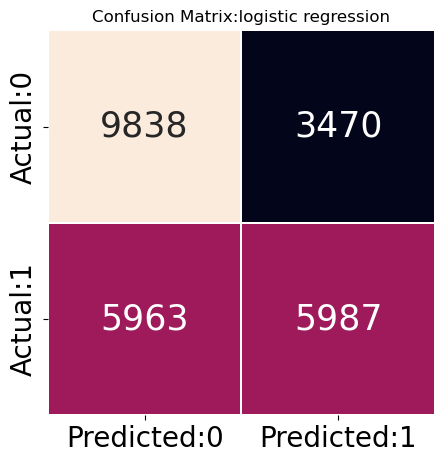

In [146]:
from sklearn.metrics import roc_curve,roc_auc_score, accuracy_score, precision_score, recall_score,f1_score

plt.figure(figsize=(5,5))
cm = confusion_matrix(ytest, pred_test)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Confusion Matrix:logistic regression')
plt.show()

In [147]:
from sklearn import metrics

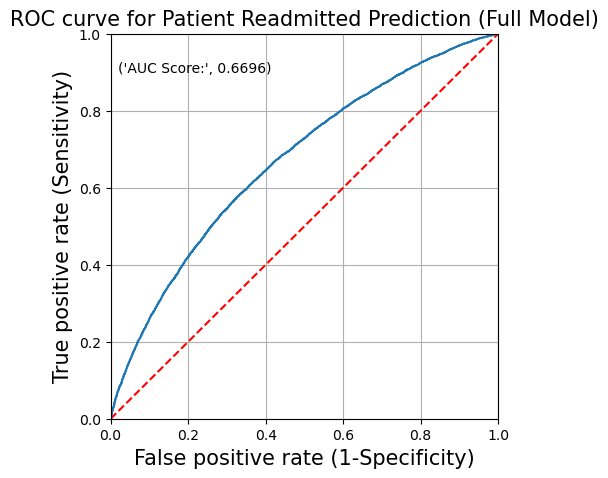

In [148]:
from sklearn.metrics import roc_curve,roc_auc_score, accuracy_score, precision_score, recall_score,f1_score

plt.figure(figsize=(5,5))
ypred_prob=lr.predict_proba(xtest)[:,1]
fpr, tpr, thresholds = roc_curve(ytest.reset_index(drop=True), ypred_prob,drop_intermediate=False)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for Patient Readmitted Prediction (Full Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest, ypred_prob),4)))
plt.grid(True)
plt.show()

In [149]:
# kappascore

from sklearn.metrics import cohen_kappa_score

print(cohen_kappa_score(ytest,pred_test))

0.24284363407450338


In [150]:
# roc_auc_score

roc_auc_score(ytest,ypred_prob)

0.6696476652920884

# Decision Tree Tuned

In [151]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

dt=DecisionTreeClassifier(random_state=10)
dt_params={'max_depth':np.arange(0,20),'min_samples_leaf':np.arange(2,10),
           'min_samples_split':np.arange(1,10),
           'criterion' : ['gini', 'entropy']}
from sklearn.model_selection import KFold
kf=KFold(n_splits=5,shuffle=True,random_state=10)

In [152]:
from sklearn.model_selection import GridSearchCV
dt_1=RandomizedSearchCV(dt,dt_params,cv=kf,scoring='r2')
dt_1.fit(xtrain,ytrain)
dt_1.best_params_

{'min_samples_split': 7,
 'min_samples_leaf': 9,
 'max_depth': 3,
 'criterion': 'entropy'}

In [153]:
dt_tuned=DecisionTreeClassifier(min_samples_split= 7,
 min_samples_leaf=9,
 max_depth=3,
 criterion='entropy')
dt_tuned.fit(xtrain,ytrain)

# testing

pred_test=dt_tuned.predict(xtest)
print(classification_report(ytest,pred_test))

              precision    recall  f1-score   support

           0       0.62      0.71      0.66     13308
           1       0.61      0.51      0.56     11950

    accuracy                           0.62     25258
   macro avg       0.62      0.61      0.61     25258
weighted avg       0.62      0.62      0.61     25258



In [154]:
# training

pred_train=dt_tuned.predict(xtrain)
print(classification_report(ytrain,pred_train))

              precision    recall  f1-score   support

           0       0.62      0.70      0.66     31106
           1       0.61      0.52      0.56     27828

    accuracy                           0.62     58934
   macro avg       0.62      0.61      0.61     58934
weighted avg       0.62      0.62      0.61     58934



In [155]:
update_performance(name='DT-train',model=dt_tuned,test=ytrain,pred=pred_train)

In [156]:
update_performance(name='DT-test',model=dt_tuned,test=ytest,pred=pred_test)

In [157]:
perf_score1

Model  Accuracy    Recall  Precision  F1 Score
0  LOG-REG-train  0.624309  0.503845   0.627197  0.558795
1   LOG-REG-test  0.626534  0.501004   0.633076  0.559350
2       DT-train  0.616927  0.519405   0.611008  0.561495
3        DT-test  0.616834  0.510962   0.614286  0.557880

# Naive Bayes

In [158]:
from sklearn.naive_bayes import GaussianNB
gb=GaussianNB()
model_gb=gb.fit(xtrain,ytrain)

# training
pred_train=gb.predict(xtrain)
print(classification_report(ytrain,pred_train))

              precision    recall  f1-score   support

           0       0.66      0.14      0.23     31106
           1       0.49      0.92      0.64     27828

    accuracy                           0.51     58934
   macro avg       0.58      0.53      0.44     58934
weighted avg       0.58      0.51      0.43     58934



In [159]:
# testing

pred_test=gb.predict(xtest)
print(classification_report(ytest,pred_test))

              precision    recall  f1-score   support

           0       0.66      0.15      0.24     13308
           1       0.49      0.92      0.64     11950

    accuracy                           0.51     25258
   macro avg       0.58      0.53      0.44     25258
weighted avg       0.58      0.51      0.43     25258



In [160]:
update_performance(name='NB-train',model=gb,test=ytrain,pred=pred_train)

In [161]:
update_performance(name='NB-test',model=gb,test=ytest,pred=pred_test)

In [162]:
from sklearn.neighbors import KNeighborsClassifier

pars = {'n_neighbors':[6,8,10,12,14,16,18],
       'algorithm':['auto','ball_tree','kd_tree','brute'],
       'p':[1,2],
       'metric':['minkowski','euclidean','manhattan','chebyshev','mahalanobis']}

In [163]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

grid_knn=RandomizedSearchCV(KNeighborsClassifier(),param_distributions=pars,refit=True,verbose=1)

print(grid_knn.fit(xtrain,ytrain))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'metric': ['minkowski', 'euclidean',
                                                   'manhattan', 'chebyshev',
                                                   'mahalanobis'],
                                        'n_neighbors': [6, 8, 10, 12, 14, 16,
                                                        18],
                                        'p': [1, 2]},
                   verbose=1)


In [164]:
# testing
pred_test=grid_knn.predict(xtest)
print(classification_report(ytest,pred_test))

              precision    recall  f1-score   support

           0       0.60      0.73      0.66     13308
           1       0.61      0.46      0.52     11950

    accuracy                           0.60     25258
   macro avg       0.61      0.60      0.59     25258
weighted avg       0.61      0.60      0.60     25258



In [213]:
# training

pred_train=grid_knn.predict(xtrain)
print(classification_report(ytrain,pred_train))

              precision    recall  f1-score   support

           0       0.65      0.78      0.71     30988
           1       0.69      0.53      0.60     27946

    accuracy                           0.66     58934
   macro avg       0.67      0.66      0.66     58934
weighted avg       0.67      0.66      0.66     58934



In [215]:
update_performance(name='KNN-train',model=grid_knn,test=ytrain,pred=pred_train)


In [216]:
update_performance(name='KNN-test',model=grid_knn,test=ytest,pred=pred_test)

# Random Forest

In [217]:
from sklearn.ensemble import RandomForestClassifier

In [218]:
rf = RandomForestClassifier(random_state=10)
rf.fit(xtrain,ytrain)

RandomForestClassifier(random_state=10)

In [384]:
from sklearn.metrics import accuracy_score,confusion_matrix

ypred_rf_train = rf.predict(xtrain)

# training

print(accuracy_score(ytrain,ypred_rf_train))
print(confusion_matrix(ytrain,ypred_rf_train))
print(classification_report(ytrain,ypred_rf_train))

1.0
[[31019     0]
 [    0 27915]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31019
           1       1.00      1.00      1.00     27915

    accuracy                           1.00     58934
   macro avg       1.00      1.00      1.00     58934
weighted avg       1.00      1.00      1.00     58934



In [219]:
# tuning RF

In [220]:
# rfc_params={'n_estimators' : np.arange(20,500), 'criterion' : ['gini', 'entropy'] ,
#            'max_depth':np.arange(1,20),'min_samples_leaf':np.arange(2,10),'min_samples_leaf':np.arange(1,10)}

In [221]:
import warnings
warnings.filterwarnings("ignore") 
rfc_params={'bootstrap': [True, False],
            'n_estimators' : np.arange(20,500),
            'criterion' : ['gini', 'entropy'] ,
           'max_depth':np.arange(1,20),
            'min_samples_leaf':np.arange(2,10),
            'min_samples_split':np.arange(1,10),
           'max_features':['auto','sqrt']}

In [222]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Assuming X_train and y_train are your training data
rf_model = RandomForestClassifier()

random_search = RandomizedSearchCV(
    rf,
    param_distributions=rfc_params,
    n_iter=50,  # Adjust the number of iterations as needed
    scoring='accuracy',
    cv=5,  # Adjust the number of cross-validation folds as needed
    verbose=2,
    n_jobs=-1  # Utilize multiple cores for parallel processing
)

random_search.fit(xtrain, ytrain)

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pallavipavuluri/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

Best Hyperparameters: {'n_estimators': 350, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 18, 'criterion': 'gini', 'bootstrap': True}


# Feature importance with RF

<Axes: >

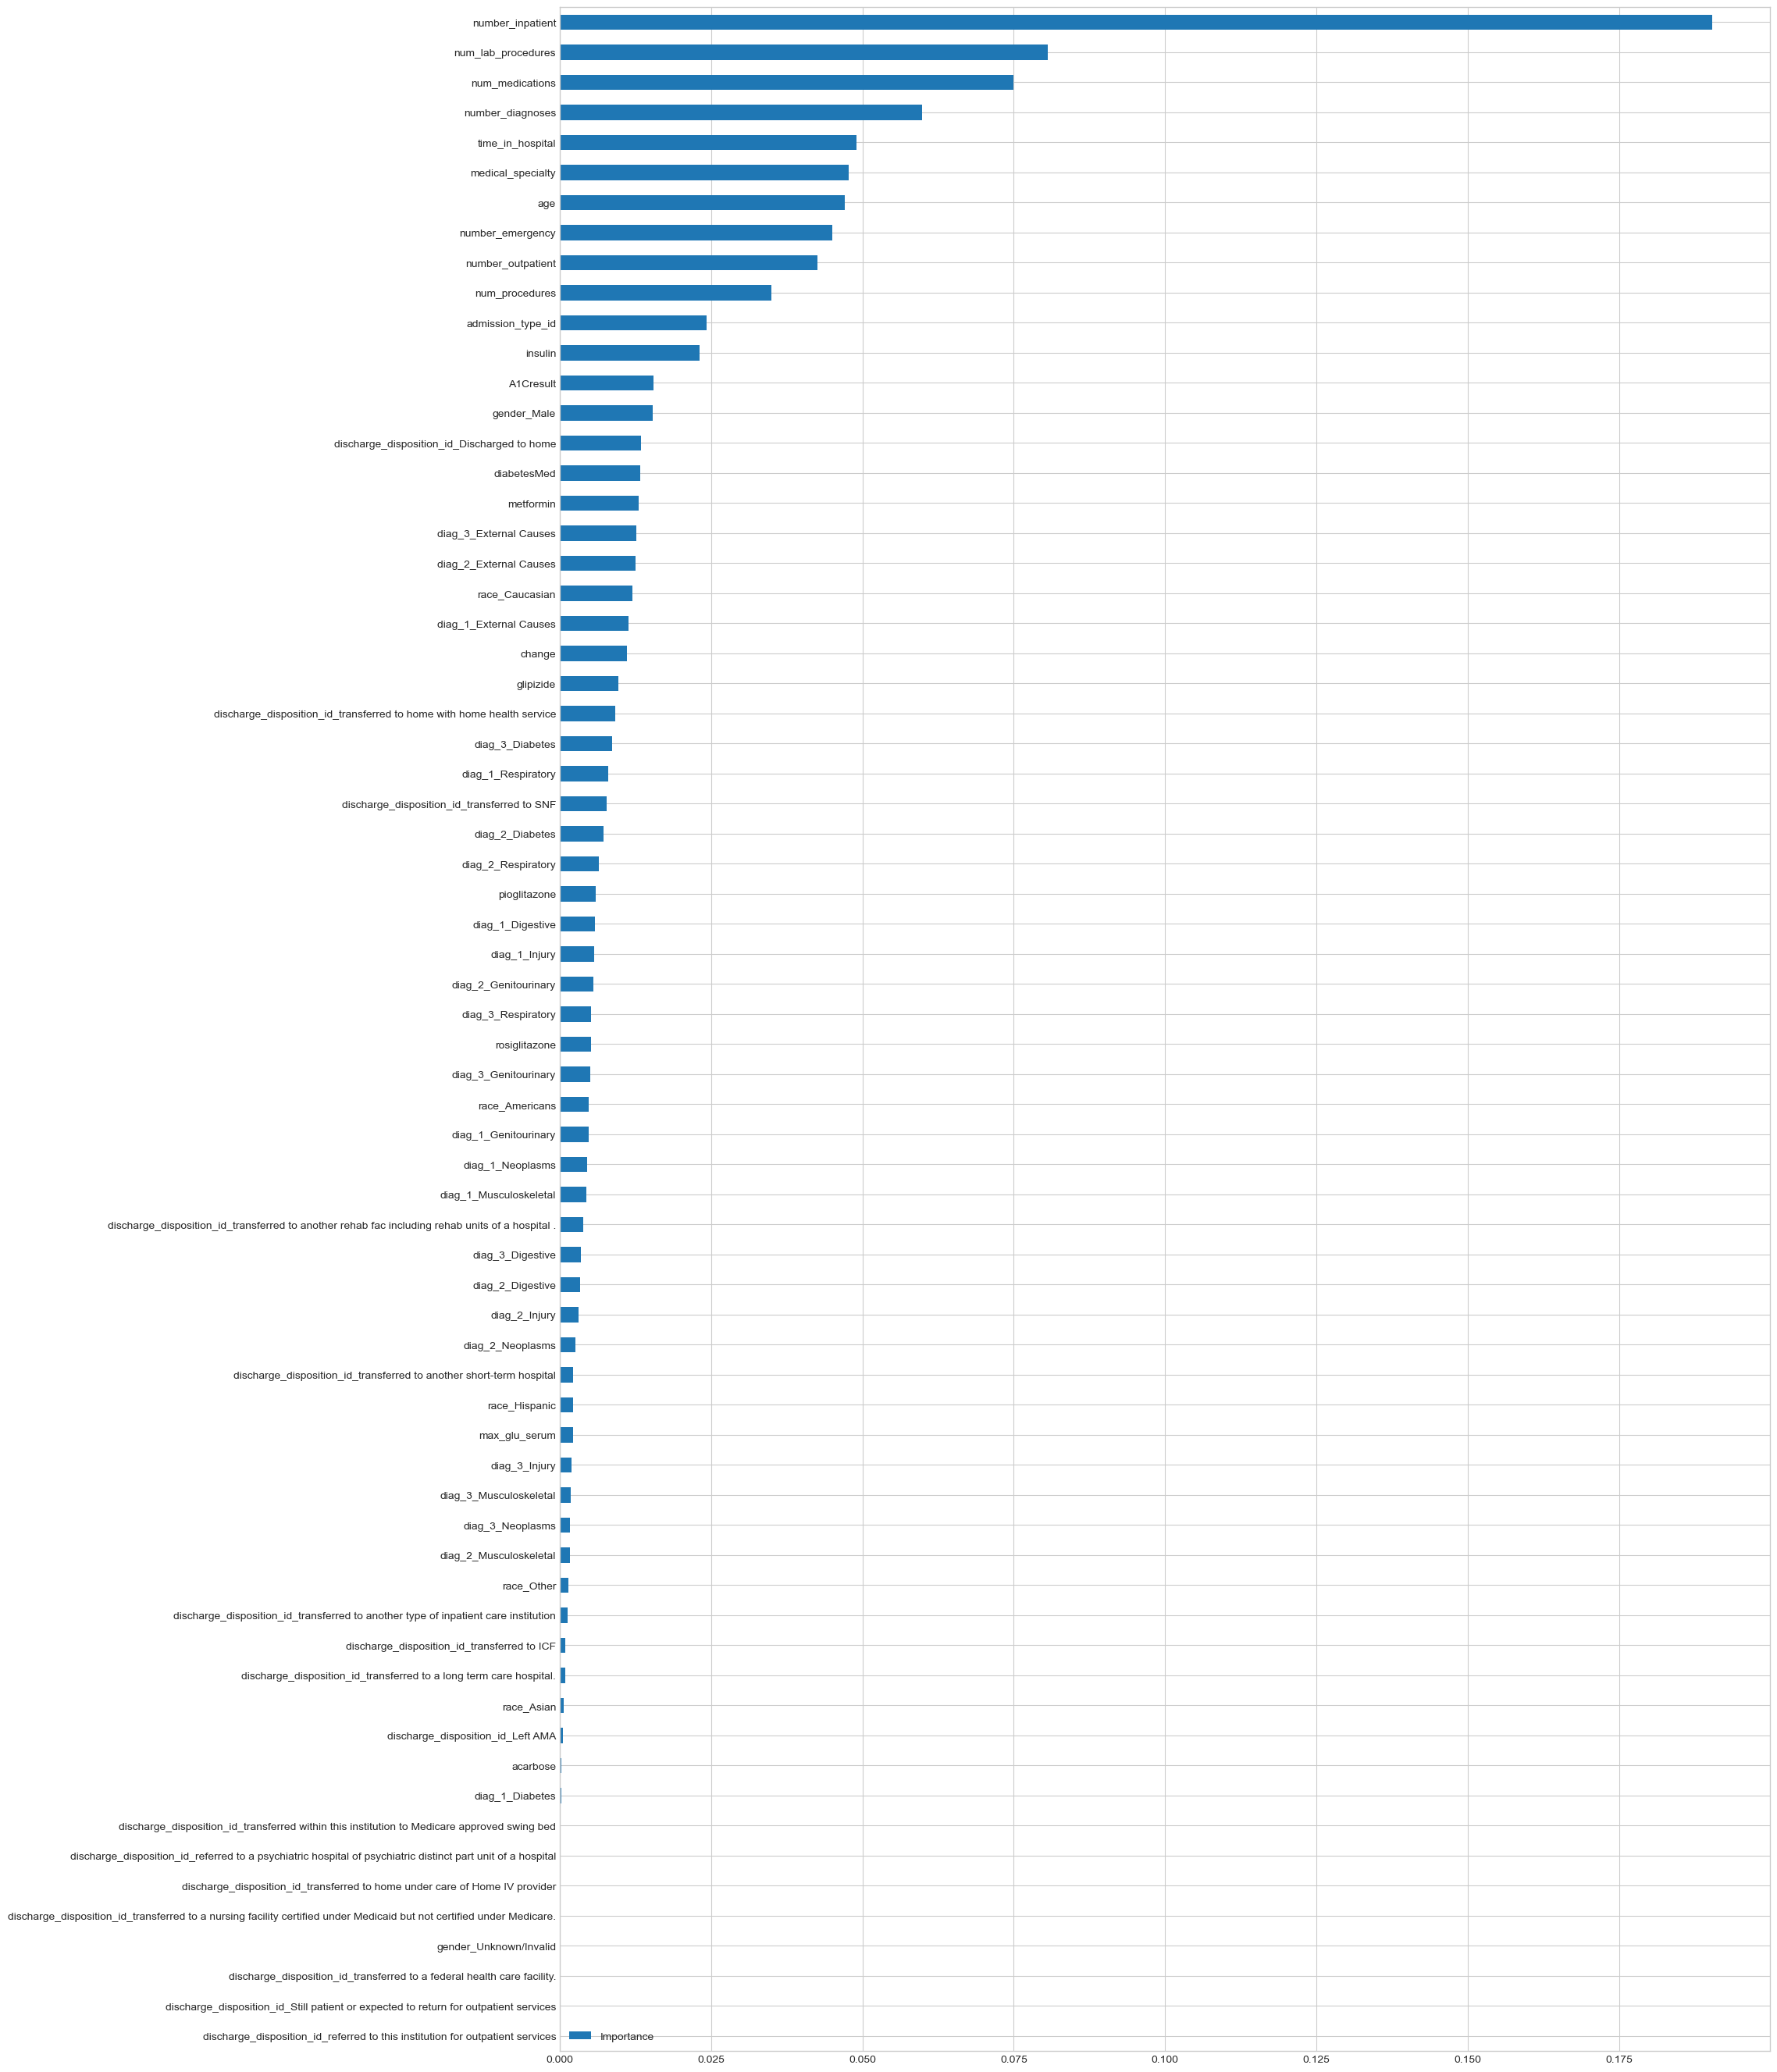

In [232]:
rf = RandomForestClassifier(n_estimators=299, min_samples_leaf= 4,min_samples_split= 3,max_depth= 18, 
                            criterion= 'gini',max_features= 'auto',bootstrap=False,random_state=10)
rfd_model=rf.fit(xtrain,ytrain)
plt.style.use('seaborn-whitegrid')
importance = rfd_model.feature_importances_
importance = pd.DataFrame(importance,index=xtrain.columns,columns=['Importance'])
importance.sort_values(by='Importance',ascending=True).plot(kind='barh',figsize=(20,len(importance)/2))

In [233]:
feature_imp= pd.Series(rfd_model.feature_importances_,index=xtrain.columns)
feature_imp

time_in_hospital          0.049009
num_lab_procedures        0.080564
num_procedures            0.034965
num_medications           0.074948
number_outpatient         0.042530
                            ...   
diag_3_Genitourinary      0.004980
diag_3_Injury             0.001973
diag_3_Musculoskeletal    0.001846
diag_3_Neoplasms          0.001733
diag_3_Respiratory        0.005189
Length: 68, dtype: float64

In [234]:
best_features = feature_imp.nlargest(40)
best_features

number_inpatient                                                         0.190419
num_lab_procedures                                                       0.080564
num_medications                                                          0.074948
number_diagnoses                                                         0.059900
time_in_hospital                                                         0.049009
medical_specialty                                                        0.047725
age                                                                      0.047102
number_emergency                                                         0.044959
number_outpatient                                                        0.042530
num_procedures                                                           0.034965
admission_type_id                                                        0.024269
insulin                                                                  0.023142
A1Cresult       

In [235]:
# training

from sklearn.metrics import accuracy_score,confusion_matrix

ypred_rf_train = rf.predict(xtrain)

print(accuracy_score(ytrain,ypred_rf_train))
print(confusion_matrix(ytrain,ypred_rf_train))
print(classification_report(ytrain,ypred_rf_train))

0.8129602606305358
[[27568  3420]
 [ 7603 20343]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83     30988
           1       0.86      0.73      0.79     27946

    accuracy                           0.81     58934
   macro avg       0.82      0.81      0.81     58934
weighted avg       0.82      0.81      0.81     58934



In [236]:
# testing

ypred_rf_test = rf.predict(xtest)

print(accuracy_score(ytest,ypred_rf_test))
print(confusion_matrix(ytest,ypred_rf_test))
print(classification_report(ytest,ypred_rf_test))

0.6305329004671787
[[9702 3724]
 [5608 6224]]
              precision    recall  f1-score   support

           0       0.63      0.72      0.68     13426
           1       0.63      0.53      0.57     11832

    accuracy                           0.63     25258
   macro avg       0.63      0.62      0.62     25258
weighted avg       0.63      0.63      0.63     25258



In [237]:
xtrain_importance = xtrain[best_features.index]
xtest_importance = xtest[best_features.index]

# BOOSTING

# Ada Boost

In [238]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

ab_tuned=AdaBoostClassifier(n_estimators=1,learning_rate=0.1)
ab_tuned.fit(xtrain,ytrain)
pred_test=ab_tuned.predict(xtest)
print(classification_report(ytest,pred_test))

              precision    recall  f1-score   support

           0       0.61      0.76      0.67     13426
           1       0.62      0.45      0.52     11832

    accuracy                           0.61     25258
   macro avg       0.61      0.60      0.60     25258
weighted avg       0.61      0.61      0.60     25258



# Ada Boost with best features

In [239]:
ab_tuned=AdaBoostClassifier(n_estimators=1,learning_rate=0.1)
ab_tuned.fit(xtrain_importance,ytrain)
pred_test=ab_tuned.predict(xtest_importance)
print(classification_report(ytest,pred_test))

              precision    recall  f1-score   support

           0       0.61      0.76      0.67     13426
           1       0.62      0.45      0.52     11832

    accuracy                           0.61     25258
   macro avg       0.61      0.60      0.60     25258
weighted avg       0.61      0.61      0.60     25258



# Gradient Boosting with best features

In [240]:

gb=GradientBoostingClassifier(random_state=0)
gb_params={'n_estimators':np.arange(1,30)}
kf=KFold(n_splits=5,shuffle=True,random_state=10)
gcv=RandomizedSearchCV(gb,gb_params,cv=kf,scoring='r2')
gcv.fit(xtrain_importance,ytrain)
gcv.best_params_


{'n_estimators': 24}

In [241]:
gb_tuned=GradientBoostingClassifier(n_estimators=24)
gb_tuned.fit(xtrain_importance,ytrain)
pred_test=gb_tuned.predict(xtest_importance)
print(classification_report(ytest,pred_test))

[CV] END bootstrap=True, criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=7, min_samples_split=7, n_estimators=109; total time=   6.5s
[CV] END bootstrap=True, criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=61; total time=   0.9s
[CV] END bootstrap=False, criterion=gini, max_depth=19, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=266; total time=  26.0s
[CV] END bootstrap=False, criterion=gini, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=417; total time=  33.6s
[CV] END bootstrap=False, criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=111; total time=   8.9s
[CV] END bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=359; total time=   9.3s
[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=sqrt, min_

# XG Boosting

In [242]:
!pip install xgboost
from xgboost import XGBClassifier

In [243]:
xgb=XGBClassifier(random_state=10,n_jobs=-1,max_depth=3)
xgb.fit(xtrain,ytrain)

ypred_xgb=xgb.predict(xtest)
print(classification_report(ytest,ypred_xgb))

              precision    recall  f1-score   support

           0       0.63      0.72      0.68     13426
           1       0.63      0.53      0.57     11832

    accuracy                           0.63     25258
   macro avg       0.63      0.63      0.62     25258
weighted avg       0.63      0.63      0.63     25258



In [244]:
ypred_xgb=xgb.predict(xtrain)
print(classification_report(ytrain,ypred_xgb))

              precision    recall  f1-score   support

           0       0.64      0.74      0.69     30988
           1       0.65      0.54      0.59     27946

    accuracy                           0.65     58934
   macro avg       0.65      0.64      0.64     58934
weighted avg       0.65      0.65      0.64     58934



In [245]:
xgb=XGBClassifier(random_state=10)
xgb_params={'n_estimators':np.arange(1,50)}
kf=KFold(n_splits=5,shuffle=True,random_state=10)
gcv=RandomizedSearchCV(xgb,xgb_params,cv=kf,scoring='r2')
gcv.fit(xtrain,ytrain)
gcv.best_params_


{'n_estimators': 43}

In [246]:
xgb=XGBClassifier(booster='gbtree',njobs=-1,gamma=3,max_depth=3,min_child_weight=3,
                  n_estimators=33,reg_lambda=1,random_state=10)

xgb.fit(xtrain,ytrain)
ypred_xgb=xgb.predict(xtest)
print(classification_report(ytest,ypred_xgb))

              precision    recall  f1-score   support

           0       0.63      0.74      0.68     13426
           1       0.63      0.50      0.56     11832

    accuracy                           0.63     25258
   macro avg       0.63      0.62      0.62     25258
weighted avg       0.63      0.63      0.62     25258



In [247]:
df1_new.shape

(84192, 69)

# Using feature selection (RFE) with XGBoost

In [248]:
from sklearn.feature_selection import RFE
est = XGBClassifier()
selector = RFE(estimator=est,n_features_to_select=30)
selector.fit(xtrain,ytrain)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=None, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=None,
                            max_leaves=None, min_child_weight=None, missing=nan,
                            monotone_constraints=None, multi_strategy=None,
                            n_estimators=None, n_jobs=None,
                            num_parallel_tree=None, random_state=None, ...),
    n_features_to_select=30)

In [249]:
 selector.get_support()

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False, False,  True, False,
       False, False,  True,  True, False,  True,  True, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False,  True, False, False,
       False,  True,  True,  True,  True,  True, False,  True, False,
       False, False,  True, False,  True, False,  True, False, False,
       False, False, False, False, False])

In [250]:
fi = pd.DataFrame(index=xtrain.columns,data={'feature':selector.get_support()})
fi[fi['feature']==True]

feature
num_lab_procedures                                     True
num_procedures                                         True
num_medications                                        True
number_outpatient                                      True
number_emergency                                       True
number_inpatient                                       True
number_diagnoses                                       True
age                                                    True
admission_type_id                                      True
medical_specialty                                      True
A1Cresult                                              True
metformin                                              True
rosiglitazone                                          True
diabetesMed                                            True
race_Americans                                         True
race_Caucasian                                         True
race_Hispanic                                          True
discharge_disposition_id_Discharged to home            True
discharge_disposition_id_transferred to SNF            True
discharge_disposition_id_transferred to another...     True
discharge_disposition_id_transferred to home wi...     True
diag_1_External Causes                                 True
diag_1_Genitourinary                                   True
diag_1_Injury                                          True
diag_1_Musculoskeletal                                 True
diag_1_Neoplasms                                       True
diag_2_Diabetes                                        True
diag_2_Injury                                          True
diag_2_Neoplasms                                       True
diag_3_Diabetes                                        True

In [251]:
y_train_predict = selector.predict(xtrain)
y_test_predict = selector.predict(xtest)
print('Train report\n', classification_report(ytrain,y_train_predict))
print('test report\n',classification_report(ytest,y_test_predict))

Train report
               precision    recall  f1-score   support

           0       0.70      0.76      0.73     30988
           1       0.71      0.63      0.67     27946

    accuracy                           0.70     58934
   macro avg       0.70      0.70      0.70     58934
weighted avg       0.70      0.70      0.70     58934

test report
               precision    recall  f1-score   support

           0       0.63      0.69      0.66     13426
           1       0.61      0.55      0.58     11832

    accuracy                           0.62     25258
   macro avg       0.62      0.62      0.62     25258
weighted avg       0.62      0.62      0.62     25258



In [252]:
df1_new.to_csv('output_file2.csv', index=False)

In [ ]:
# This study leveraged data that cover demographic, clinical procedure-related and diagnostic-related features, 
# as well as medication information for all ages to build a predictive model in order to identify diabetic patients 
# who have higher likelihood of being readmitted within 30 days.
# Based on my analysis of four machine learning algorithms, including Logistic Regression, Decision Tree, Random Forest,Naïve Bayes 
# and different models in terms of accuracy, Kappa, ROC curve, and confusion matrix, the best model for this purpose has been found to be Random Forest, which yielded an accuracy of 64%.
# Some of the key factors that affect readmission rate are the number of times a patient spent in the hospital, the number of diagnoses, 
# the number of lab procedures and the number of medications.
# Other not as critical reference information includes admission type, admission source, primary diagnosis, dosage of insulin, value of HbA1c and so on.
# Based on the results from this study, hospitals are advised to work not only on inpatient treatment but also on continued care after discharge.

In [140]:
def per_measures(model,test,pred):


  accuracy    =accuracy_score(test,pred)
  f1score     =f1_score(test,pred)
  recall      =recall_score(test,pred)
  precision   =precision_score(test,pred)
  # aic         =model.aic
  # reliability = cohen_kappa_score(test,pred)



  return (accuracy,recall,precision,f1score,)

In [141]:
def update_performance (name,
                        model,
                        test,
                        pred
                           ):

    # assign 'comp_perf' as global variable
    global perf_score1


    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    perf_score1 = perf_score1.append({'Model'       : name,
                                    'Accuracy'    : per_measures(model,test,pred)[0],
                                    'Recall'      : per_measures(model,test,pred)[1],
                                    'Precision'   : per_measures(model,test,pred)[2],
                                    'F1 Score'    : per_measures(model,test,pred)[3]
                                    # 'AIC'         : per_measures(model,ytest,ypred)[4],
                                    # 'Reliability' : per_measures(model,ytest,ypred)[5]

                                     },
                                   ignore_index = True)

# PCA with XGB

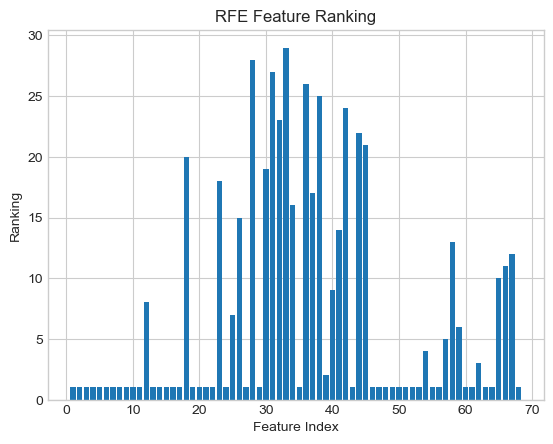

In [253]:
# # Create a base model (Logistic Regression in this example)
# model = LogisticRegression()
from sklearn.feature_selection import RFE

# Create the RFE model and select the number of features to retain
num_features_to_select = 40
rfe = RFE(rf, n_features_to_select=num_features_to_select)

# Fit the RFE model to the training data
rfe.fit(xtrain, ytrain)

# Get the selected features
selected_features = rfe.support_

# Transform the original data to include only the selected features
xtrain_selected = rfe.transform(xtrain)
xtest_selected = rfe.transform(xtest)

# Train a model using the selected features
rf.fit(xtrain_selected, ytrain)

# Make predictions on the test set
y_pred = rf.predict(xtest_selected)


# Plotting feature importances
feature_ranking = rfe.ranking_
plt.bar(range(1, len(feature_ranking) + 1), feature_ranking)
plt.xlabel('Feature Index')
plt.ylabel('Ranking')
plt.title('RFE Feature Ranking')
plt.show()

In [254]:
# Evaluate the performance of the model
accuracy = accuracy_score(ytest, y_pred)
print(f"Accuracy with {num_features_to_select} selected features: {accuracy:.2f}")


Accuracy with 40 selected features: 0.63


In [255]:
feat=pd.DataFrame(index=xtrain.columns, data={'feature':rfe.get_support()})
feat


feature
time_in_hospital           True
num_lab_procedures         True
num_procedures             True
num_medications            True
number_outpatient          True
...                         ...
diag_3_Genitourinary       True
diag_3_Injury             False
diag_3_Musculoskeletal    False
diag_3_Neoplasms          False
diag_3_Respiratory         True

[68 rows x 1 columns]

In [256]:
rfe_filtered_features=feat[feat['feature']==True].index
rfe_filtered_features

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age', 'admission_type_id',
       'medical_specialty', 'A1Cresult', 'metformin', 'glipizide',
       'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesMed',
       'race_Americans', 'race_Caucasian', 'gender_Male',
       'discharge_disposition_id_Discharged to home',
       'discharge_disposition_id_transferred to SNF',
       'discharge_disposition_id_transferred to home with home health service',
       'diag_1_Digestive', 'diag_1_External Causes', 'diag_1_Genitourinary',
       'diag_1_Injury', 'diag_1_Musculoskeletal', 'diag_1_Neoplasms',
       'diag_1_Respiratory', 'diag_2_Diabetes', 'diag_2_External Causes',
       'diag_2_Genitourinary', 'diag_2_Respiratory', 'diag_3_Diabetes',
       'diag_3_External Causes', 'diag_3_Genitourinary', 'diag_3_Respiratory'],
      dtype='object')

In [257]:
df1_rfe=df1_new[['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age', 'admission_type_id',
       'medical_specialty', 'A1Cresult', 'metformin', 'glipizide',
       'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesMed',
       'race_Caucasian', 'gender_Male',
       'discharge_disposition_id_Discharged to home',
       'discharge_disposition_id_transferred to SNF',
       'discharge_disposition_id_transferred to home with home health service',
       'diag_1_Digestive', 'diag_1_External Causes', 'diag_1_Genitourinary',
       'diag_1_Injury', 'diag_1_Musculoskeletal', 'diag_1_Neoplasms',
       'diag_1_Respiratory', 'diag_2_Diabetes', 'diag_2_External Causes',
       'diag_2_Genitourinary', 'diag_2_Respiratory', 'diag_3_Diabetes',
       'diag_3_Digestive', 'diag_3_External Causes', 'diag_3_Genitourinary',
       'diag_3_Respiratory']]

df1_rfe.head()

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1         -0.332433            0.803396       -0.983093         0.441802   
2         -0.894079           -1.569470        1.694661        -0.277604   
3         -0.894079           -0.034192        0.194270         0.176654   
4         -1.545678            0.344900       -0.983093        -1.168932   
5         -0.332433           -0.677380        1.694661         0.176654   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  \
1          -0.436016         -0.361883         -0.708024          0.854959   
2           2.329453         -0.361883          1.207126         -1.036818   
3          -0.436016         -0.361883         -0.708024         -0.632534   
4          -0.436016         -0.361883         -0.708024         -1.343418   
5          -0.436016         -0.361883         -0.708024          0.854959   

   age  admission_type_id  ...  diag_1_Respiratory  diag_2_Diabetes  \
1  1.0                4.0  ...                   0                0   
2  2.0                4.0  ...                   0                1   
3  3.0                4.0  ...                   0                0   
4  4.0                4.0  ...                   0                0   
5  5.0                2.0  ...                   0                0   

   diag_2_External Causes  diag_2_Genitourinary  diag_2_Respiratory  \
1                       1                     0                   0   
2                       0                     0                   0   
3                       1                     0                   0   
4                       0                     0                   0   
5                       0                     0                   0   

   diag_3_Diabetes  diag_3_Digestive  diag_3_External Causes  \
1                0                 0                       1   
2                0                 0                       1   
3                0                 0                       0   
4                1                 0                       0   
5                1                 0                       0   

   diag_3_Genitourinary  diag_3_Respiratory  
1                     0                   0  
2                     0                   0  
3                     0                   0  
4                     0                   0  
5                     0                   0  

[5 rows x 40 columns]

# Dimension reduction

In [259]:
from sklearn.decomposition import PCA
from numpy.linalg import eig
cov_mat = df1_rfe.cov()
cov_mat


time_in_hospital  \
time_in_hospital                                            1.000012   
num_lab_procedures                                          0.352280   
num_procedures                                              0.183491   
num_medications                                             0.474398   
number_outpatient                                          -0.002348   
number_emergency                                            0.003049   
number_inpatient                                            0.087213   
number_diagnoses                                            0.237136   
age                                                         0.169336   
admission_type_id                                           0.014983   
medical_specialty                                          -0.284108   
A1Cresult                                                  -0.056413   
metformin                                                   0.007473   
glipizide                                                  -0.008791   
pioglitazone                                               -0.000776   
rosiglitazone                                              -0.006352   
insulin                                                    -0.082607   
change                                                     -0.061625   
diabetesMed                                                -0.031152   
race_Caucasian                                             -0.002468   
gender_Male                                                -0.019771   
discharge_disposition_id_Discharged to home                -0.146989   
discharge_disposition_id_transferred to SNF                 0.075528   
discharge_disposition_id_transferred to home wi...          0.055621   
diag_1_Digestive                                            0.001068   
diag_1_External Causes                                      0.022268   
diag_1_Genitourinary                                       -0.001391   
diag_1_Injury                                               0.006733   
diag_1_Musculoskeletal                                     -0.003823   
diag_1_Neoplasms                                            0.009393   
diag_1_Respiratory                                         -0.008420   
diag_2_Diabetes                                            -0.027255   
diag_2_External Causes                                      0.006878   
diag_2_Genitourinary                                        0.008596   
diag_2_Respiratory                                          0.017841   
diag_3_Diabetes                                            -0.038652   
diag_3_Digestive                                            0.001082   
diag_3_External Causes                                      0.011561   
diag_3_Genitourinary                                        0.013503   
diag_3_Respiratory                                          0.015275   

                                                    num_lab_procedures  \
time_in_hospital                                              0.352280   
num_lab_procedures                                            1.000012   
num_procedures                                                0.020417   
num_medications                                               0.283288   
number_outpatient                                             0.008934   
number_emergency                                              0.026514   
number_inpatient                                              0.038862   
number_diagnoses                                              0.165386   
age                                                           0.032264   
admission_type_id                                             0.315042   
medical_specialty                                            -0.567883   
A1Cresult                                                    -0.174294   
metformin                                                     0.063297   
glipizide                                                    -0

In [260]:
eig_val,eig_vec = np.linalg.eig(cov_mat)
print('eig_val : ',eig_val)
print('eig_vec : ',eig_vec)

eig_val :  [1.07166302e+03 2.67681338e+00 2.19714309e+00 1.91023771e+00
 1.64629357e+00 1.45371107e+00 1.35599652e+00 9.23496526e-01
 8.42916184e-01 7.91763139e-01 7.81769368e-01 7.53856218e-01
 6.28396670e-01 6.12432807e-01 5.20344037e-01 5.08480283e-01
 4.46013165e-01 2.74347314e-01 2.43684373e-01 2.23240886e-01
 2.11529742e-01 1.85461234e-01 1.74648578e-01 1.61701027e-01
 1.34343715e-01 1.15144674e-01 2.12932195e-02 2.34076522e-02
 9.25852217e-02 9.01794094e-02 3.03244984e-02 3.46995355e-02
 3.98640659e-02 4.45597760e-02 4.95735546e-02 8.38411152e-02
 7.78612164e-02 5.98069846e-02 6.80211264e-02 6.59208982e-02]
eig_vec :  [[ 2.63263397e-04  2.29747952e-01  3.59649641e-01 ... -1.24457350e-02
  -8.44310051e-03 -1.39848698e-02]
 [ 5.26847692e-04  1.44009999e-01  3.24777206e-01 ...  6.19413659e-03
  -2.02788415e-02 -1.90324622e-02]
 [ 1.65735290e-03  3.12357763e-02  1.71095576e-01 ... -6.47428516e-03
   1.70176245e-02  2.11536079e-02]
 ...
 [-1.34591768e-06 -3.61685792e-02  2.44141153e-

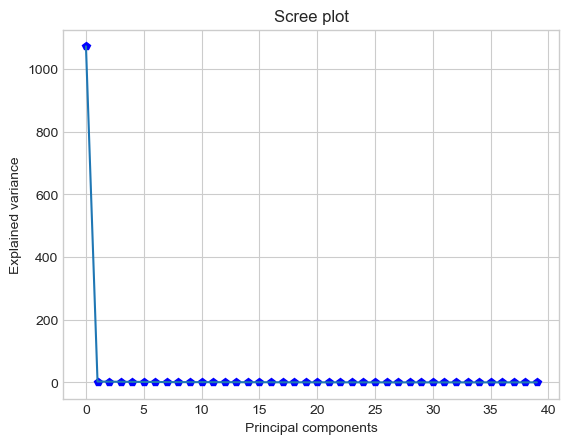

In [261]:
plt.plot(eig_val,'bp')
plt.plot(eig_val)
plt.title('Scree plot')
plt.xlabel('Principal components')
plt.ylabel('Explained variance')
plt.show()

In [262]:
percent_var = []
for i in eig_val:
    variation = (i/sum(eig_val))*100
    percent_var.append(variation)

In [263]:
pca = PCA(n_components=20,random_state=10)
components = pca.fit_transform(df1_rfe)
df_PCA = pd.DataFrame(data=components,columns = ['PC {}'.format(i) for i in range(1,21)])
df_PCA.head(10)

PC 1      PC 2      PC 3      PC 4      PC 5      PC 6      PC 7  \
0 -31.893089  4.391143 -1.779492 -1.168353  1.485055 -0.110947 -1.203332   
1 -31.888668  4.153974  0.091187  0.201180  1.890098 -0.401090  1.131822   
2 -31.886400  3.247656 -0.416797 -0.577420  0.452359 -0.306084 -1.177325   
3 -31.879849  2.698096 -0.164214 -1.568550 -2.033813 -0.082766 -0.561330   
4 -31.878203  1.079629 -1.091898  1.620660 -1.207012 -1.572108 -0.809879   
5 -31.867506  0.457036 -1.519172  2.115190 -1.886946  1.559624 -0.289285   
6 -31.896673 -0.927197  0.909102 -1.224095  0.893024  0.344557 -1.491464   
7 -31.878597 -2.511419 -2.051967  1.641522 -1.107352  0.060114 -1.179777   
8  40.123254 -3.246132 -0.776394  2.256465 -1.788248 -0.778085 -0.489204   
9 -31.891479  1.359119 -2.491544 -0.330849 -0.144418 -0.783321 -1.451704   

       PC 8      PC 9     PC 10     PC 11     PC 12     PC 13     PC 14  \
0 -0.025911 -0.194104 -0.744556  0.316194  1.503246  0.524733 -0.277455   
1  3.260291  0.968008 -1.364342  1.378300 -1.655020 -0.358622 -0.314005   
2  0.221263  0.208505  0.052593  0.508979 -0.213627  0.162231 -0.015336   
3  2.971528 -0.306370 -0.019763 -0.446382 -0.082539 -0.418693 -0.072055   
4 -0.100852  0.503665  0.327284  1.148970  0.347345 -0.521084  0.066771   
5 -0.934887 -0.033243  0.211259 -1.392349 -0.054631 -0.685741  0.220866   
6 -0.210685 -0.174885  0.102720 -0.960664  0.039657  0.047476 -0.105862   
7  2.465875 -0.576508  0.284159 -1.006005 -0.197706  0.029423 -0.708292   
8 -0.436269  0.101647  0.471139 -0.264537 -0.327824  0.154512 -1.759121   
9 -0.219530  0.192790 -0.003732  0.880156  0.180937  0.490263 -0.856696   

      PC 15     PC 16     PC 17     PC 18     PC 19     PC 20  
0  0.637346 -0.778299 -0.297561  0.808710 -0.014247 -0.362798  
1 -0.810526  0.709678  0.125395  0.610942 -0.470771 -0.526698  
2  0.437047 -0.342914 -0.305474  0.254249  0.680658  0.205628  
3  0.039248 -0.886924 -0.067364 -0.526721  0.187984  0.652582  
4 -0.324387 -0.236447  0.155471 -0.699291  0.098330  0.328804  
5 -0.003141 -1.553472  0.008636 -0.166566  0.663811 -0.506072  
6  0.293328 -1.031848  0.119475 -1.086172  0.231858  0.132499  
7 -0.422484 -0.770540  0.108256 -0.038984 -0.195258 -1.172840  
8  1.573844  1.271300  1.490893 -0.090563 -0.552797  0.329392  
9 -0.672225 -0.026151  0.510117 -0.455408 -0.838755 -0.186854

In [264]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif = [vif(df_PCA.values,i) for i in range (df_PCA.shape[1])]
VIF = pd.DataFrame(data={'VIF':vif},index=df_PCA.columns)
VIF

VIF
PC 1   1.0
PC 2   1.0
PC 3   1.0
PC 4   1.0
PC 5   1.0
PC 6   1.0
PC 7   1.0
PC 8   1.0
PC 9   1.0
PC 10  1.0
PC 11  1.0
PC 12  1.0
PC 13  1.0
PC 14  1.0
PC 15  1.0
PC 16  1.0
PC 17  1.0
PC 18  1.0
PC 19  1.0
PC 20  1.0

In [265]:
x=df_PCA
y=df1_new['readmitted']

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.20, random_state=10)

# XGB with PCA

In [266]:
xgb=XGBClassifier(random_state=10,n_jobs=-1,max_depth=3)
xgb.fit(x_train,y_train)

ypred_xgb=xgb.predict(x_test)
print(classification_report(y_test,ypred_xgb))

              precision    recall  f1-score   support

           0       0.62      0.70      0.66      8900
           1       0.61      0.52      0.56      7939

    accuracy                           0.61     16839
   macro avg       0.61      0.61      0.61     16839
weighted avg       0.61      0.61      0.61     16839

